In [1]:
%pylab
%matplotlib inline
%reload_ext autoreload

import pandas as pd
import sys
import seaborn as sns
sys.path.append('../../src')
if sys.platform != 'darwin':
    os.environ["R_HOME"] = r"C:\\Program Files\\R\\R-3.6.0" # change as needed
%load_ext rpy2.ipython

import abrTools as at
import os
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,classification_report
from collections import Counter
import pretty_confusion_matrix as pcm
from scipy.signal import savgol_filter


fs = 195000.0/2.0 # Acquisition sampling rate

from datetime import date
savefolder = os.path.join('..','results',str(date.today()))


from matplotlib.pyplot import errorbar
rcParams["font.family"] = "Arial"
rcParams['axes.linewidth'] = 5
rcParams["xtick.major.size"] = 20
rcParams["xtick.major.width"] = 5
rcParams["xtick.major.pad"] = 10

rcParams["ytick.major.size"] = 20
rcParams["ytick.major.width"] = 5
rcParams["xtick.minor.size"] = 10
rcParams["xtick.minor.width"] = 5

rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
markersize=50
fontSize = 54*1.5
import matplotlib.gridspec as gridspec

Using matplotlib backend: module://matplotlib_inline.backend_inline
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# 1- Wave parameters over time

In [2]:
masterWave1 = at.createWave1Dataset(datafolder = '../../data',age='1month')
masterWave1_2 = at.createWave1Dataset(datafolder = '../../data',age='3month')
masterWave1_3 = at.createWave1Dataset(datafolder = '../../data',age='6month')
masterWave1_4 = at.createWave1Dataset(datafolder = '../../data',age='9month')
masterWave1_5 = at.createWave1Dataset(datafolder = '../../data',age='12month')


df = pd.concat([masterWave1,masterWave1_2,masterWave1_3,masterWave1_4,masterWave1_5])
df = df.query('Freq==100') # Select only the click
df = df.query('Intensity>=15') #Select only intensities above 15
df = df.query("Intensity  in [ 55, 75, 95]") #Select only these intensities for speed
mouseList = df.query("Age == '12month'")['ID'].unique() #chose only mice which have been investigated thorughout
df = df.query("ID in @mouseList")
#df['Intensity'] = df['Intensity'].astype('category')

/Users/federico/Desktop/ABR-ML 2/ABR-ML-analysis/notebooks/Paper/../../src/abrTools.py:1112: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  masterAll = pd.concat([masterAll,rowsToAddDf],ignore_index=True)
/Users/federico/Desktop/ABR-ML 2/ABR-ML-analysis/notebooks/Paper/../../src/abrTools.py:1112: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  masterAll = pd.concat([masterAll,rowsToAddDf],ignore_index=True)
/Users/federico/Desktop/ABR-ML 2/ABR-ML-analysis/notebooks/Paper/../../src/abrTools.py:1086:

In [4]:
df2 = df.copy()
df2 = df2.rename({'Wave1 amp':'w1a','Wave1 latency':'w1l'},axis=1)
df2 = df2.query("Strain=='6N'")
df2['Intensity'] = df2['Intensity'].astype('category')

In [5]:
%%R -i df2 -o out2,out0,out1,out3,ss
res.aov <- aov(w1a ~ Age+Intensity, df2) # 'accuracy', 'test_precision_scorer_avg',     'test_recall_scorer_avg', 'roc_auc_score'
ss <- summary(res.aov)

out2 <- as.data.frame(TukeyHSD(res.aov)[2])
out0 <- as.data.frame(TukeyHSD(res.aov)[0])
out1 <- as.data.frame(TukeyHSD(res.aov)[1])
out3 <- as.data.frame(TukeyHSD(res.aov)[3])

/Users/federico/miniforge3/envs/machinelearning/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '
/Users/federico/miniforge3/envs/machinelearning/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "Freq". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'int'> and <class 'numpy.int64'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '
/Users/federico/miniforge3/envs/machinelearning/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "Intensity". Fall back to string conversion. The 

In [6]:
ss

o{'None':                 Df       Sum Sq     Mean Sq     F value         Pr(>F)
Age            4.0  2491.698761  622.924690  397.577974  4.839448e-175
Intensity      2.0   174.095470   87.047735   55.557698   4.790067e-23
Residuals    668.0  1046.621594    1.566799         NaN            NaN, }

In [10]:
out1

Age.diff   Age.lwr   Age.upr  Age.p.adj
1month-12month  5.268693  4.851967  5.685419   0.000000
3month-12month  3.671892  3.255166  4.088618   0.000000
6month-12month  1.980441  1.563715  2.397167   0.000000
9month-12month  0.758529  0.341803  1.175255   0.000008
3month-1month  -1.596801 -2.013527 -1.180075   0.000000
6month-1month  -3.288252 -3.704978 -2.871526   0.000000
9month-1month  -4.510164 -4.926890 -4.093438   0.000000
6month-3month  -1.691451 -2.108177 -1.274725   0.000000
9month-3month  -2.913363 -3.330089 -2.496637   0.000000
9month-6month  -1.221912 -1.638638 -0.805186   0.000000

In [11]:
out2

Intensity.diff  Intensity.lwr  Intensity.upr  Intensity.p.adj
75-55        1.158640       0.881433       1.435846         0.000000
95-55        0.971496       0.694290       1.248703         0.000000
95-75       -0.187143      -0.464350       0.090063         0.252469

In [7]:
df

Freq Intensity      P1_x      P1_y      N1_x      N1_y P2_x P2_y N2_x  \
4     100        55  1.558974  2.998076  2.030769 -3.444368  NaN  NaN  NaN   
8     100        75  1.435897  4.781419  1.907692 -5.026052  NaN  NaN  NaN   
12    100        95  1.394872  5.213882  1.856410 -4.614110  NaN  NaN  NaN   
118   100        55  1.517949  3.209721  1.958974 -3.847874  NaN  NaN  NaN   
122   100        75  1.384615  5.436439  1.917949 -5.117016  NaN  NaN  NaN   
...   ...       ...       ...       ...       ...       ...  ...  ...  ...   
1003  100        55       NaN       NaN       NaN       NaN  NaN  NaN  NaN   
1026  100        55       NaN       NaN       NaN       NaN  NaN  NaN  NaN   
1067  100        55       NaN       NaN       NaN       NaN  NaN  NaN  NaN   
1108  100        55       NaN       NaN       NaN       NaN  NaN  NaN  NaN   
1129  100        55       NaN       NaN       NaN       NaN  NaN  NaN  NaN   

     N2_y  ... N3_y P4_x P4_y N4_x N4_y Strain      Age      ID  Wave1 amp  \
4     NaN  ...  NaN  NaN  NaN  NaN  NaN     6N   1month  326243   6.442444   
8     NaN  ...  NaN  NaN  NaN  NaN  NaN     6N   1month  326243   9.807471   
12    NaN  ...  NaN  NaN  NaN  NaN  NaN     6N   1month  326243   9.827992   
118   NaN  ...  NaN  NaN  NaN  NaN  NaN     6N   1month  326244   7.057595   
122   NaN  ...  NaN  NaN  NaN  NaN  NaN     6N   1month  326244  10.553455   
...   ...  ...  ...  ...  ...  ...  ...    ...      ...     ...        ...   
1003  NaN  ...  NaN  NaN  NaN  NaN  NaN     6N  12month  333796          0   
1026  NaN  ...  NaN  NaN  NaN  NaN  NaN     6N  12month  333798          0   
1067  NaN  ...  NaN  NaN  NaN  NaN  NaN     6N  12month  335028          0   
1108  NaN  ...  NaN  NaN  NaN  NaN  NaN     6N  12month  334601          0   
1129  NaN  ...  NaN  NaN  NaN  NaN  NaN     6N  12month  334603          0   

     Wave1 latency  
4         1.558974  
8         1.435897  
12        1.394872  
118       1.517949  
122       1.384615  
...            ...  
1003           NaN  
1026           NaN  
1067           NaN  
1108           NaN  
1129           NaN  

[945 rows x 23 columns]

In [8]:
import matplotlib.gridspec as gridspec
from scipy.stats import median_abs_deviation


def makeFigure(df,strain,variable,ylabel,colorcycle,ylim=None,avgFunc='mean',stdFunc='std'):
    f= figure(figsize=(17,14))
    if strain =='Repaired':
        supt = '6N-Repaired'
    else:
        supt = strain

    f.suptitle(supt,fontsize=fontSize)
    gs= gridspec.GridSpec(1, 1,figure=f)


    dff = df.query("Strain==@strain")

    ax = plt.subplot(gs[0])
    for id in dff['ID'].unique():
        for intensity in dff['Intensity'].unique():
            df2 = dff.query('ID==@id & Intensity==@intensity')
            plot(df2['Age'].apply(lambda x: {'1month':0,'3month':1,'6month':2,'9month':3,'12month':4}[x]),df2[variable].values.T,linewidth=2,alpha=0.2,label=intensity,color=colorcycle[intensity])
    
    if stdFunc == 'std':
        stdString = 'std'
    elif stdFunc =='mad':
        stdFunc = median_abs_deviation
        stdString = 'median_abs_deviation'

    dfavg = dff.groupby(['Age','Intensity'])[variable].agg([avgFunc,stdFunc]).reset_index()
    dfavg['Age'] = dfavg['Age'].apply(lambda x: {'1month':0,'3month':1,'6month':2,'9month':3,'12month':4}[x])
    dfavg.sort_values('Age',inplace=True)

    for intensity in dff['Intensity'].unique():
        df2 = dfavg.query('Intensity==@intensity')
        errorbar(df2['Age'],df2[avgFunc],df2[stdString],color=colorcycle[intensity],fmt='o-',
                markersize=markersize,clip_on=False,capsize=10,linewidth=3,capthick=3)
    

    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.left.set_visible(True)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_visible(True)

    ax.set_xlabel('Age (months)')
    ax.set_ylabel(ylabel)
    ax.set_xticks(arange(5),[1,3,6,9,12])
    ax.spines['left'].set_position(('axes', -0.02))
    ax.spines['bottom'].set_position(('axes', -0.05))
    #ax.tick_params(axis='y', which='minor', left=True)
    ax.tick_params(axis="y", direction="out", which="minor", right=False, top=False,left=True)
    ax.tick_params(axis="x", direction="out", which="minor", right=False, top=False,left=False,bottom=True)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontSize)
    if ylim is not None:
        ax.set_ylim(ylim)
    gs.tight_layout(f) 
    return f,ax


def makeFigureMAE(df,strain,variable,ylabel,colorcycle,inputAge = '[\'1month\', \'3month\']',ylim=None,avgFunc='mean',stdFunc='std',scatterSpread=1/30,title = ''):
    f= figure(figsize=(17,14))

    if strain =='Repaired':
        supt = '6N-Repaired'
    else:
        supt = strain
    f.suptitle(supt,fontsize=fontSize)
    gs= gridspec.GridSpec(1, 1,figure=f)


    dff = df.query("Strain==@strain & InputAge==@inputAge")

    ax = plt.subplot(gs[0])
    scalefactor=2
    if len(dff['Intensity'].unique())==3:
        centre = -0.05 
    else:
        centre = 0
    offsets = {35:(-0.15+centre)*scalefactor,55:(-0.05+centre)*scalefactor,75:(0.05+centre)*scalefactor,95:(0.15+centre)*scalefactor,85:0}
    for intensity in dff['Intensity'].unique():
        for age in ['6month','9month','12month']:
            df2 = dff.query('Intensity==@intensity & Age==@age')
            plot(df2['Age'].apply(lambda x: {'6month':0,'9month':1,'12month':2}[x])+offsets[intensity]+randn(df2.shape[0])*scatterSpread,df2[variable].values.T,'o',
                markersize=markersize*0.35,alpha=0.3,label=intensity,markeredgewidth=0,color=colorcycle[intensity])
    
    if stdFunc == 'std':
        stdString = 'std'
    elif stdFunc =='mad':
        stdFunc = median_abs_deviation
        stdString = 'median_abs_deviation'

    dfavg = dff.groupby(['Age','Intensity'])[variable].agg([avgFunc,stdFunc]).reset_index()
    dfavg['Age'] = dfavg['Age'].apply(lambda x:  {'6month':0,'9month':1,'12month':2}[x])
    dfavg.sort_values('Age',inplace=True)

    symbols = ["d","v","P"]
    for intensity in dff['Intensity'].unique():
        for jj,age in enumerate([0,1,2]):
            df2 = dfavg.query('Intensity==@intensity & Age==@age')
            print(df2)
            errorbar(df2['Age']+offsets[intensity],df2[avgFunc],df2[stdString],color=colorcycle[intensity],fmt=symbols[jj],
                    markersize=markersize,clip_on=False,capsize=10,linewidth=3,capthick=3)
    
    f.suptitle(title,fontsize=fontSize,y=1)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.left.set_visible(True)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_visible(True)

    ax.set_xlabel('Age (months)')
    ax.set_ylabel(ylabel)
    ax.set_xticks(arange(3),[6,9,12])
    ax.spines['left'].set_position(('axes', -0.02))
    ax.spines['bottom'].set_position(('axes', -0.05))
    #ax.tick_params(axis='y', which='minor', left=True)
    ax.tick_params(axis="y", direction="out", which="minor", right=False, top=False,left=True)
    ax.tick_params(axis="x", direction="out", which="minor", right=False, top=False,left=False,bottom=True)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontSize)
    if ylim is not None:
        ax.set_ylim(ylim)
    gs.tight_layout(f) 
    return f,ax

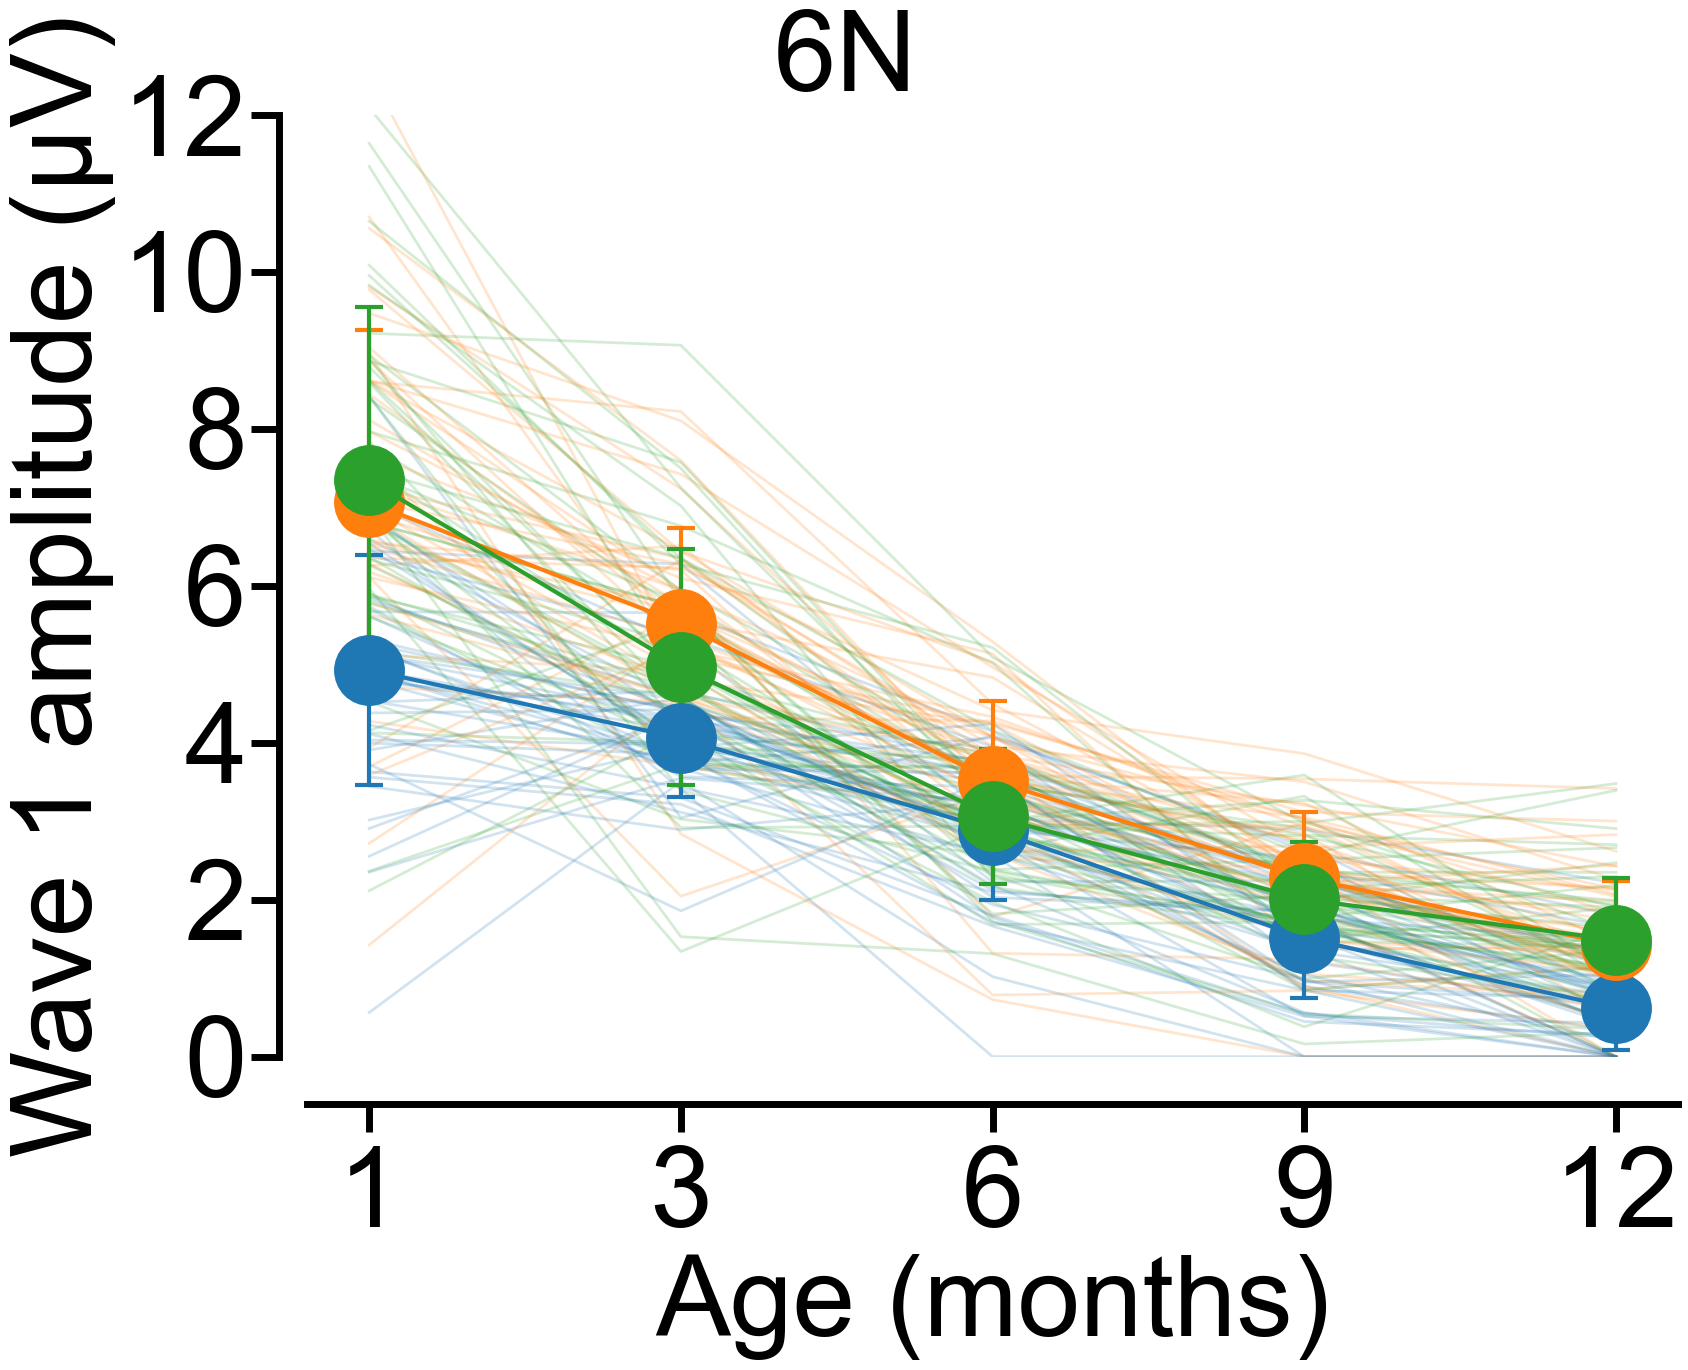

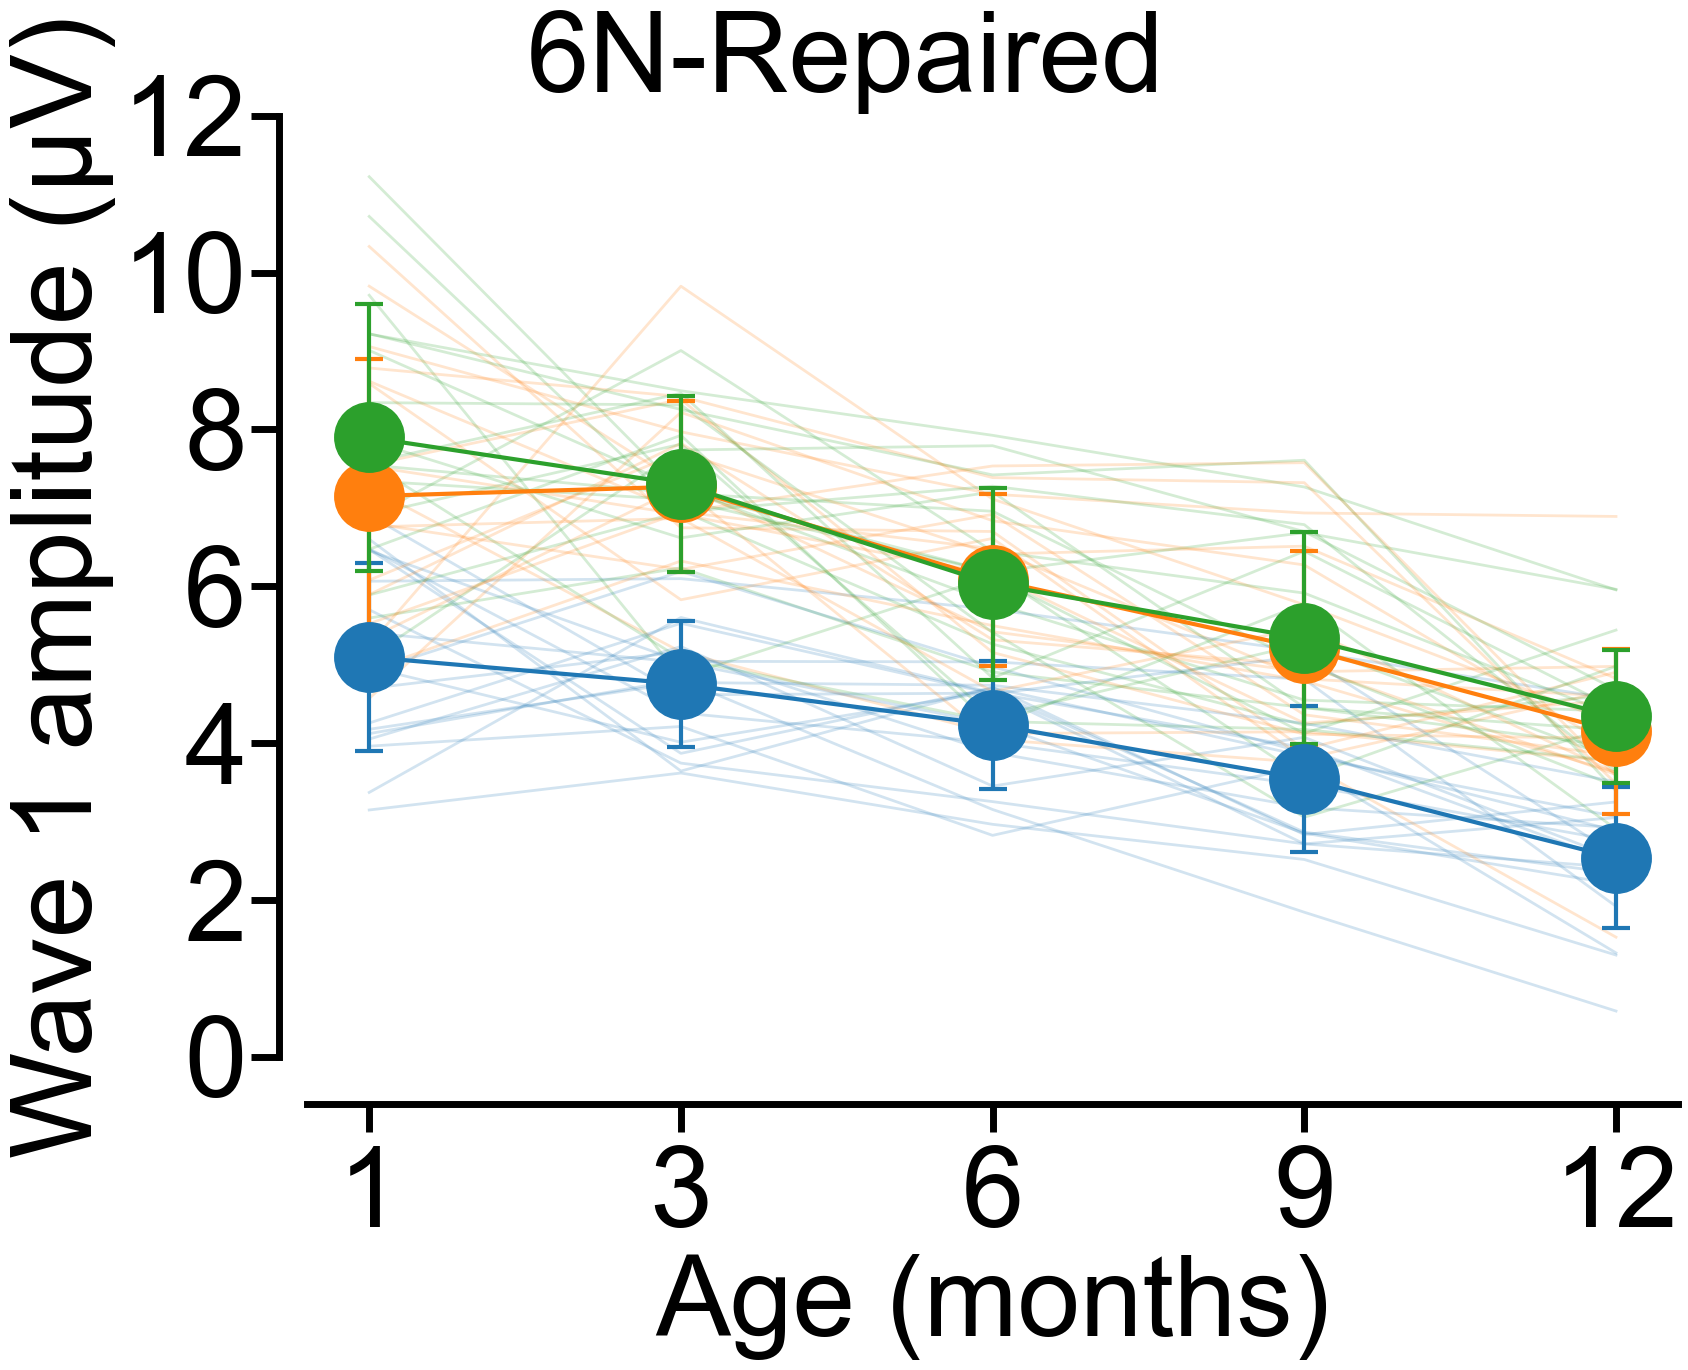

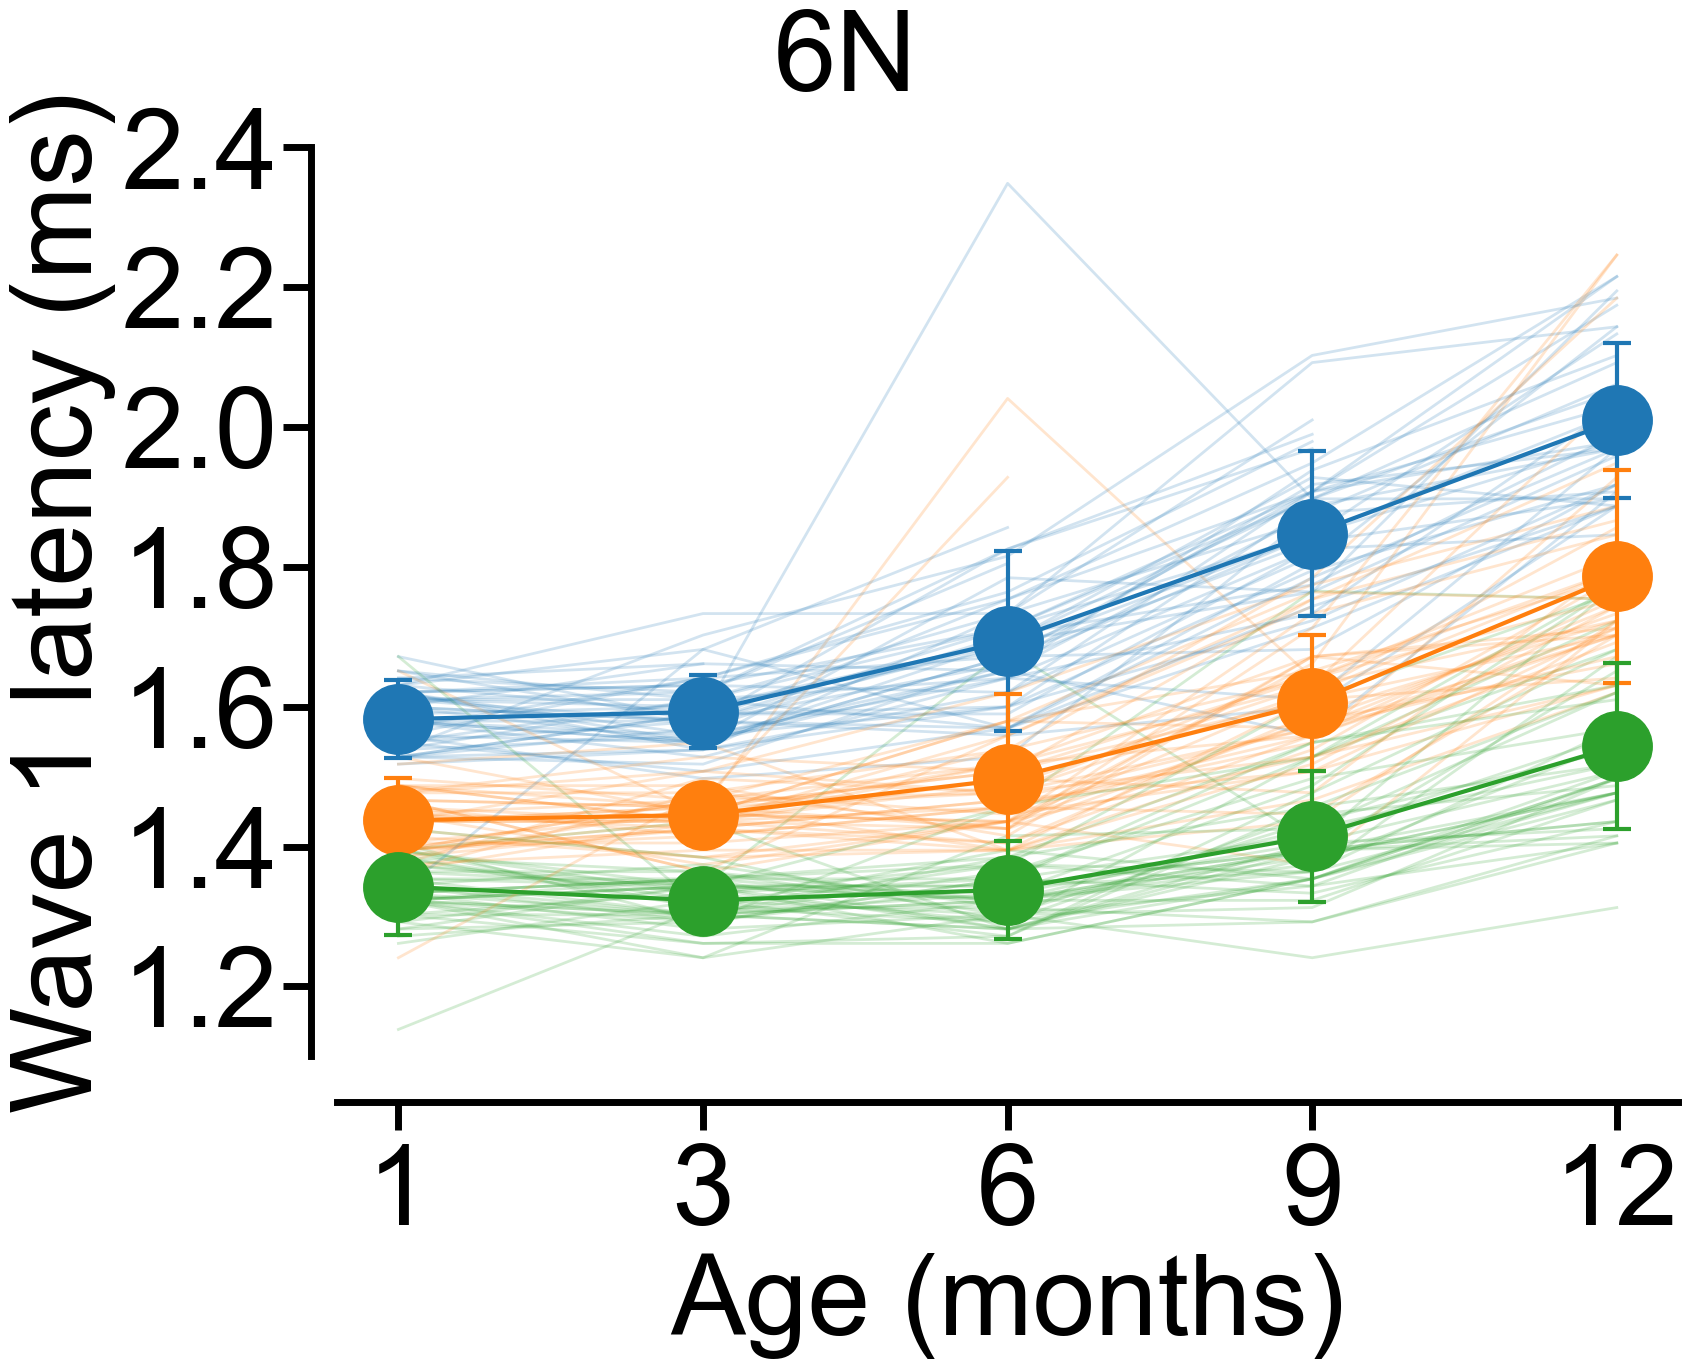

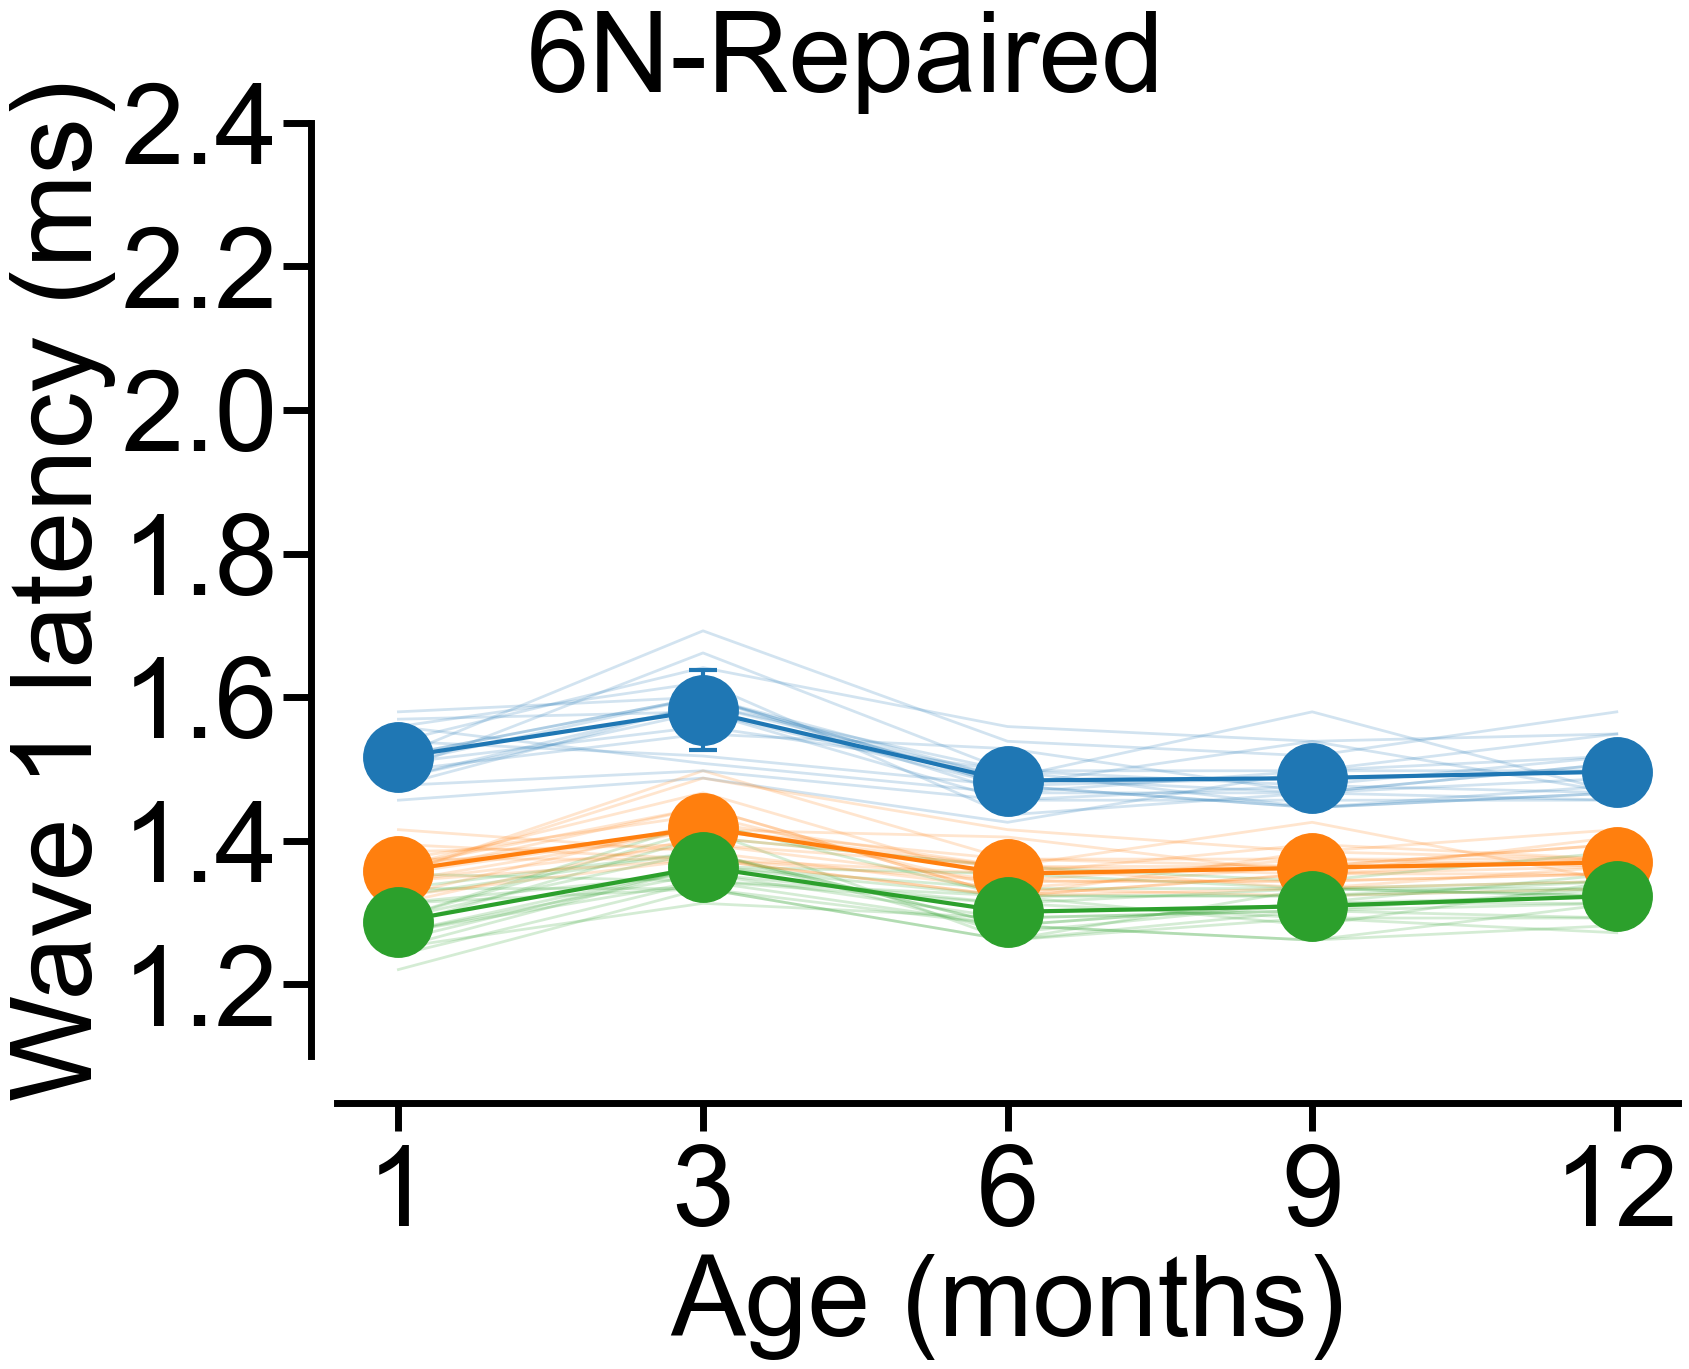

In [9]:
colorcycle = dict(zip(df['Intensity'].unique(),plt.rcParams['axes.prop_cycle'].by_key()['color'][0:]))

strain = '6N'
variable = 'Wave1 amp'
ylabel = 'Wave 1 amplitude (μV)'
f,ax = makeFigure(df,strain,variable,ylabel,colorcycle=colorcycle)
ax.set_ylim(0,12)
f.savefig('./Panels/waveampVsAge6N.pdf',dpi=1200,transparent=True)


strain = 'Repaired'
variable = 'Wave1 amp'
ylabel = 'Wave 1 amplitude (μV)'
f,ax = makeFigure(df,strain,variable,ylabel,colorcycle=colorcycle)
ax.set_ylim(0,12)
f.savefig('./Panels/waveampVsAgeRep.pdf',dpi=1200,transparent=True)

strain = '6N'
variable = 'Wave1 latency'
ylabel = 'Wave 1 latency (ms)'
f,ax = makeFigure(df,strain,variable,ylabel,colorcycle=colorcycle)
ax.set_ylim(1.1,2.4)
f.savefig('./Panels/wavelatVsAge6N.pdf',dpi=1200,transparent=True)

strain = 'Repaired'
variable = 'Wave1 latency'
ylabel = 'Wave 1 latency (ms)'
f,ax = makeFigure(df,strain,variable,ylabel,colorcycle=colorcycle)
ax.set_ylim(1.1,2.4)
f.savefig('./Panels/wavelatVsAgeRep.pdf',dpi=1200,transparent=True)
                  

In [10]:
df.groupby(['Strain','Intensity','Age'])[['Wave1 amp','Wave1 latency']].agg([mean,std,'count'])

/var/folders/n2/bkzw0ff907zgpgprdz_rg_tr0000gn/T/ipykernel_60169/2245392998.py:1: FutureWarning: The provided callable <function mean at 0x10971b2e0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df.groupby(['Strain','Intensity','Age'])[['Wave1 amp','Wave1 latency']].agg([mean,std,'count'])
/var/folders/n2/bkzw0ff907zgpgprdz_rg_tr0000gn/T/ipykernel_60169/2245392998.py:1: FutureWarning: The provided callable <function std at 0x10971b420> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  df.groupby(['Strain','Intensity','Age'])[['Wave1 amp','Wave1 latency']].agg([mean,std,'count'])
/var/folders/n2/bkzw0ff907zgpgprdz_rg_tr0000gn/T/ipykernel_60169/2245392998.py:1: FutureWarning: The provided callable <function mean at 0x10971b2e0> is currently 

Wave1 amp                 Wave1 latency            \
                                mean       std count          mean       std   
Strain   Intensity Age                                                         
6N       55        12month     0.618  0.535398    45      2.009670  0.110883   
                   1month   4.927182  1.464582    45      1.582222  0.055681   
                   3month   4.056807  0.750420    45      1.592707  0.052189   
                   6month   2.888639  0.889291    45      1.694172  0.129097   
                   9month   1.514634  0.760906    45      1.847619  0.118436   
         75        12month  1.418794  0.820413    45      1.786569  0.152619   
                   1month   7.062542  2.190117    45      1.437721  0.060215   
                   3month   5.517728  1.219478    45      1.445242  0.039652   
                   6month   3.516909  1.013116    45      1.496296  0.121989   
                   9month   2.282488  0.830944    45      1.605828  0.097009   
         95        12month  1.488767  0.783945    45      1.543476  0.118578   
                   1month   7.341915  2.204640    45      1.342906  0.069645   
                   3month   4.966701  1.506919    45      1.322849  0.038094   
                   6month   3.061335  0.855291    45      1.338348  0.070063   
                   9month   2.004024  0.736455    45      1.414508  0.093544   
Repaired 55        12month  2.536421  0.900289    18      1.496296  0.035684   
                   1month   5.096888  1.199370    18      1.516239  0.034870   
                   3month   4.753877  0.806810    18      1.581766  0.055462   
                   6month   4.234211  0.813293    18      1.483761  0.033559   
                   9month   3.542777  0.932862    18      1.487179  0.036728   
         75        12month  4.149724  1.048479    18      1.369801  0.022032   
                   1month   7.149476  1.753530    18      1.357835  0.025644   
                   3month   7.270899  1.092596    18      1.418234  0.038666   
                   6month   6.085258  1.097869    18      1.353846  0.027250   
                   9month   5.207002  1.246733    18      1.362393  0.024938   
         95        12month  4.339825  0.844479    18      1.323077  0.027476   
                   1month   7.898591  1.699929    18      1.287179  0.035919   
                   3month   7.302486  1.120847    18      1.363533  0.030964   
                   6month   6.030232  1.227229    18      1.300855  0.031317   
                   9month   5.336711  1.352811    18      1.308832  0.024153   

                                  
                           count  
Strain   Intensity Age            
6N       55        12month    35  
                   1month     45  
                   3month     45  
                   6month     44  
                   9month     42  
         75        12month    42  
                   1month     45  
                   3month     45  
                   6month     45  
                   9month     44  
         95        12month    45  
                   1month     45  
                   3month     45  
                   6month     45  
                   9month     45  
Repaired 55        12month    18  
                   1month     18  
                   3month     18  
                   6month     18  
                   9month     18  
         75        12month    18  
                   1month     18  
                   3month     18  
                   6month     18  
                   9month     18  
         95        12month    18  
                   1month     18  
                   3month     18  
                   6month     18  
                   9month     18

Compare with the MAE of the model

Amplitude MAE

In [11]:
savefolder = os.path.join('../../','results','2024-11-21-regression_results')#'2024-04-26-regressionResults'

modelNames = ['RandomForestRegressor']
intensities = ['55dB','75dB','95dB']
targetAge = ['6mont']
inputFreqs = ['[100]']# 'None'
targetAges = ['6month','9month','12month']
inputAges =  ['[\'1month\', \'3month\']']
modelType = 'waveamp'
dfs = []
dfsTest = []

for modelName in modelNames:
    for inputFreq in inputFreqs:
        for targetAge in targetAges:
            for inputAge in inputAges:
                for intensity in intensities:
                    filename = f'{modelName}{intensity}{targetAge}-{modelType}-{inputAge}-inputFreq{inputFreq}-resultsCV.csv'
                    ddf = pd.read_csv(os.path.join(savefolder,filename),index_col=0)
                    ddf['InputFreq'] = inputFreq
                    ddf['TargetAge'] = targetAge
                    ddf['InputAge'] = inputAge
                    ddf['ModelName'] = modelName
                    ddf['SoundLevel'] = intensity
                    dfs.append(ddf)

                    filename = f'{modelName}{intensity}{targetAge}-{modelType}-{inputAge}-inputFreq{inputFreq}-resultsTest.csv'
                    df2 = pd.read_csv(os.path.join(savefolder,filename),index_col=0)
                    df2['InputFreq'] = inputFreq
                    df2['TargetAge'] = targetAge
                    df2['InputAge'] = inputAge
                    df2['ModelName'] = modelName
                    df2['SoundLevel'] = intensity
                    dfsTest.append(df2)
                
masterWaveAmp = pd.concat(dfs,ignore_index=True)
masterAmpTest = pd.concat(dfsTest,ignore_index=True)
masterAmpTest['Mouse ID'] = masterAmpTest['Mouse ID'].astype(str)


masterWaveAmp['Age'] = masterWaveAmp['TargetAge']
#master['Age (months)'] = master['TargetAge'].str.split('month').apply(lambda x:int(x[0])) # Do this to comply with the threshold
avgdf = pd.DataFrame(df.groupby(['Age','Intensity'])['Wave1 amp'].mean())


masterWaveAmp['MAEpercent'] = None
for i,el in masterWaveAmp.iterrows():
    masterWaveAmp.loc[i,'MAEpercent'] = el['MAE']/avgdf.loc[(el['Age'],int(el['SoundLevel'][:2]))].values[0]
masterWaveAmp['Strain'] = 'Wave 1 amplitude'#do this for compatibility
masterWaveAmp=masterWaveAmp.rename({'SoundLevel':'Intensity'},axis=1)
masterWaveAmp['Intensity'] = masterWaveAmp['Intensity'].apply(lambda x:int(x[:2]))

   Age  Intensity      mean       std
3    0         55  0.714229  0.172881
   Age  Intensity      mean      std
6    1         55  0.736085  0.27062
   Age  Intensity      mean       std
0    2         55  0.683727  0.164743
   Age  Intensity      mean       std
4    0         75  0.825883  0.257361
   Age  Intensity      mean       std
7    1         75  0.957244  0.332084
   Age  Intensity      mean       std
1    2         75  0.992809  0.261599
   Age  Intensity      mean       std
5    0         95  1.063858  0.329873
   Age  Intensity      mean     std
8    1         95  1.030059  0.3673
   Age  Intensity      mean      std
2    2         95  0.833109  0.22673
   Age  Intensity      mean       std
3    0         55  0.218213  0.052819
   Age  Intensity      mean       std
6    1         55  0.351504  0.129229
   Age  Intensity      mean       std
0    2         55  0.586327  0.141274
   Age  Intensity      mean       std
4    0         75  0.194292  0.060545
   Age  Intensity   

(0.0, 1.0108907283611028)

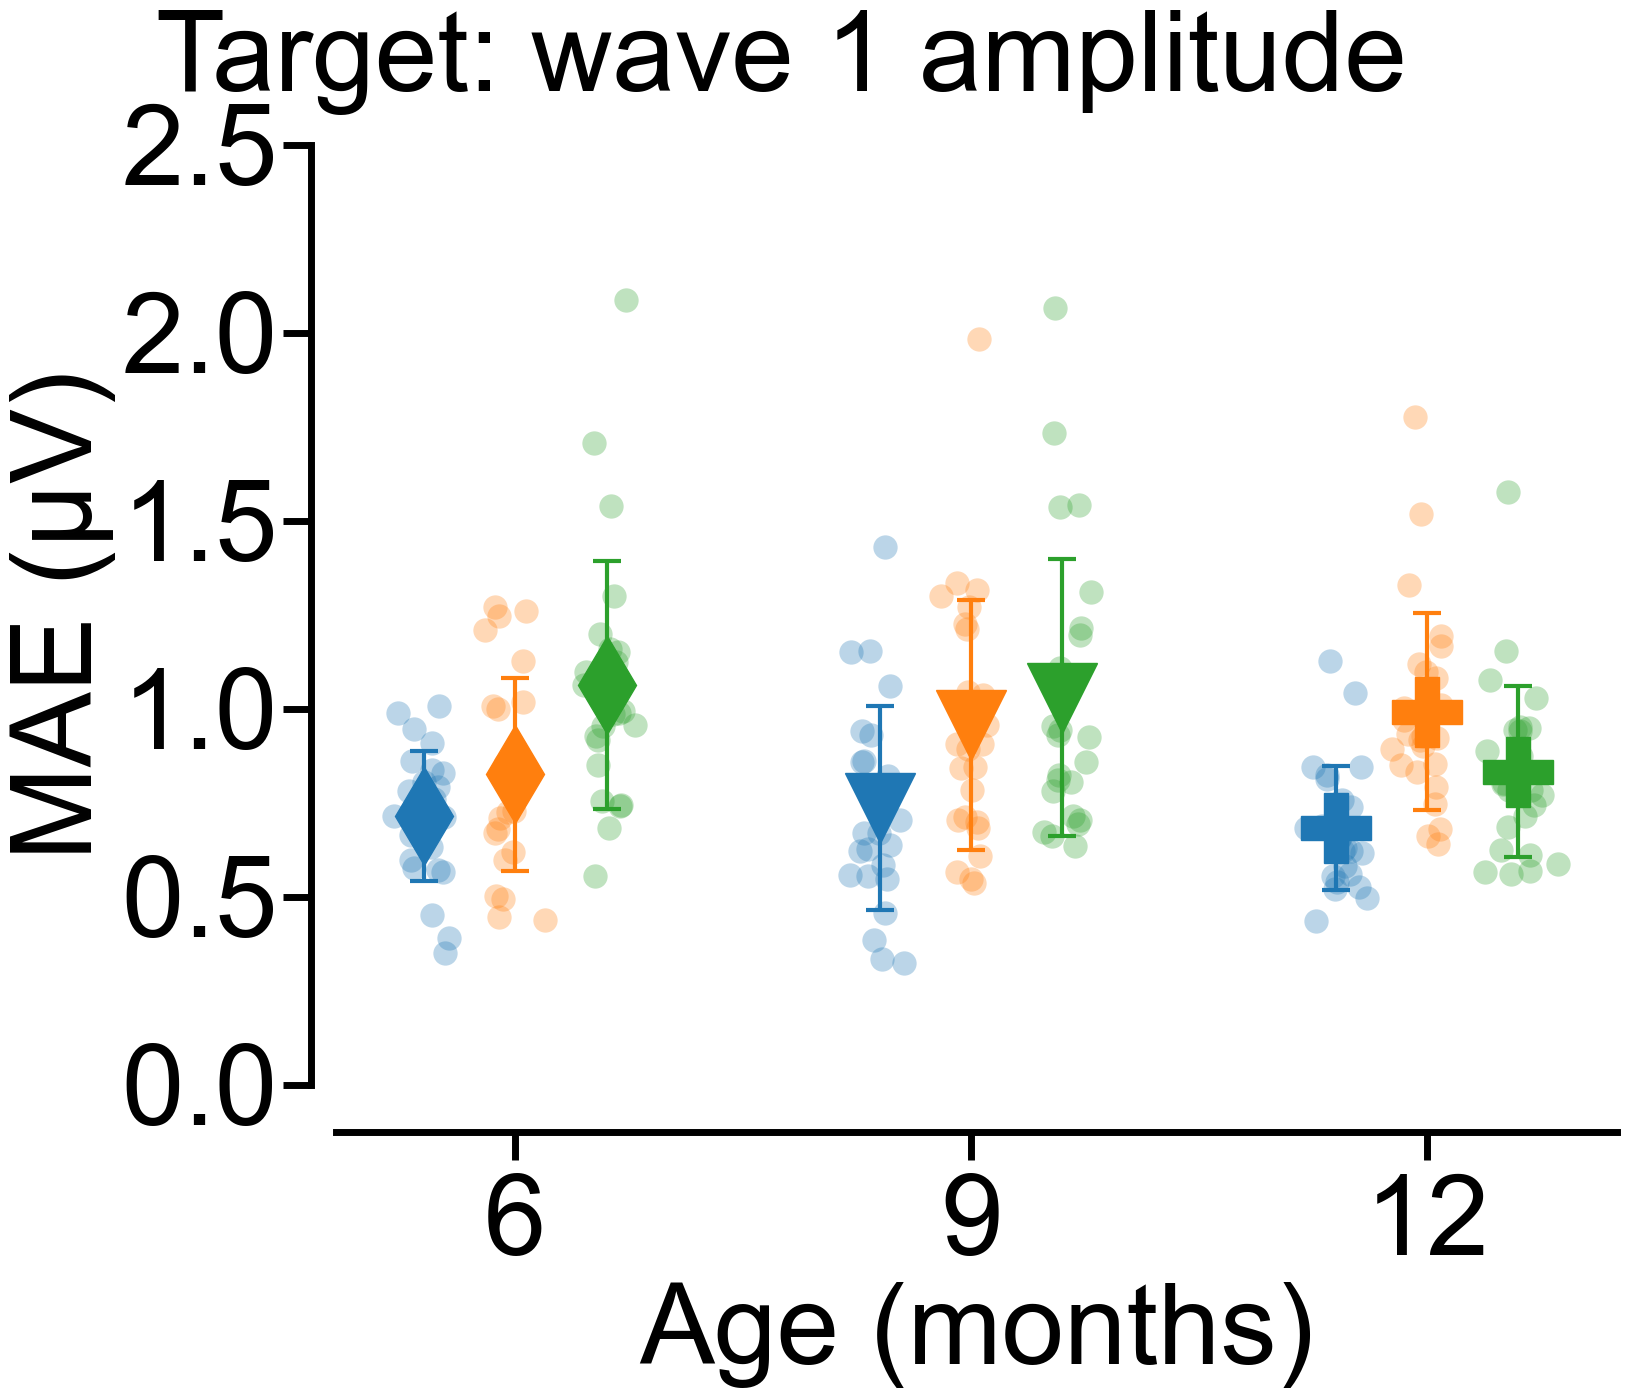

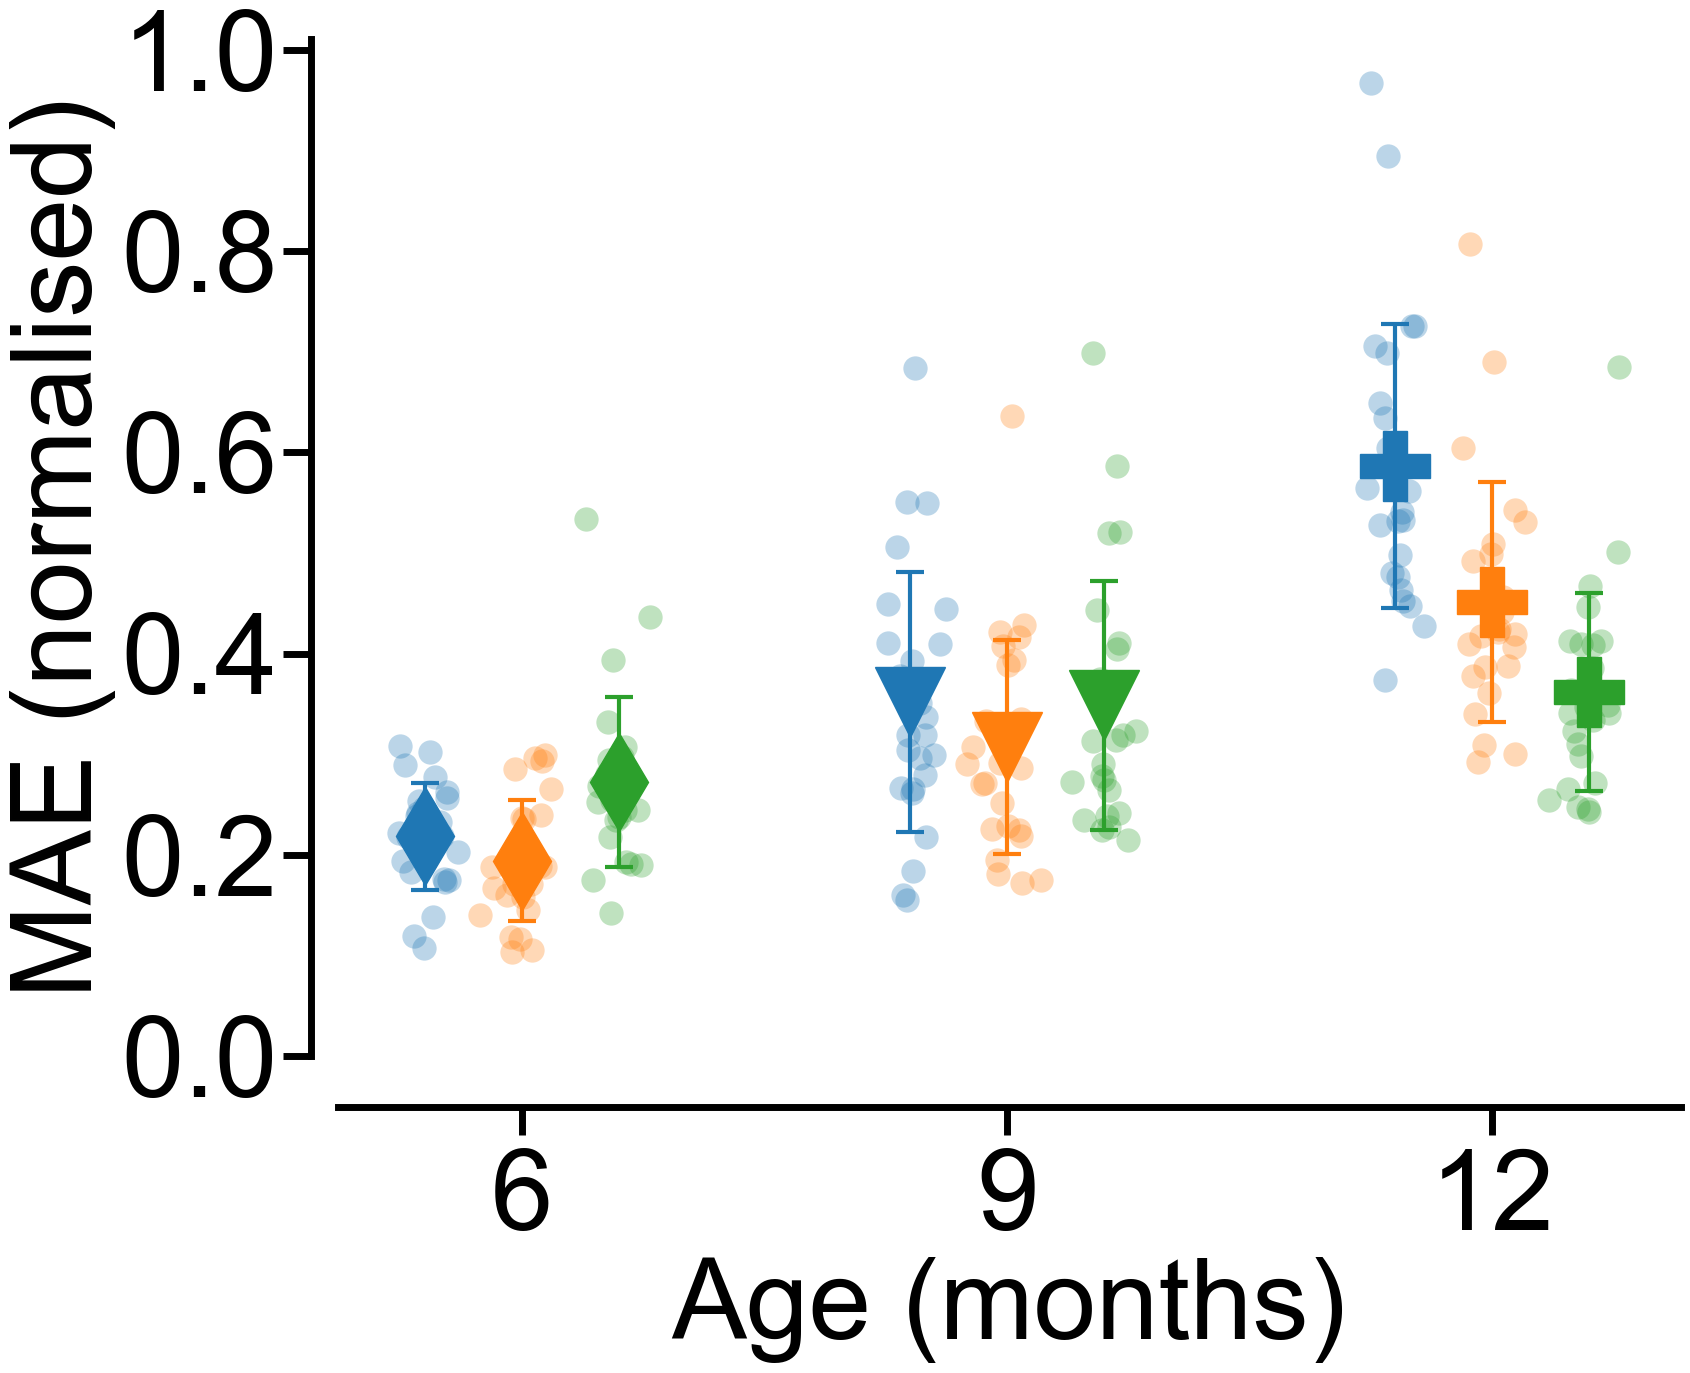

In [12]:
f,ax =makeFigureMAE(masterWaveAmp,strain='Wave 1 amplitude',variable='MAE',ylabel='MAE (μV)',colorcycle=colorcycle,title='Target: wave 1 amplitude')
ylim(0,2.5)

f.savefig('./Panels/waveampVsAgeMAE.pdf',dpi=1200,transparent=True)

makeFigureMAE(masterWaveAmp,strain='Wave 1 amplitude',variable='MAEpercent',ylabel='MAE (normalised)',colorcycle=colorcycle)
ylim(0,)

In [13]:
masterWaveAmp.groupby('Age')[['MAE','MAEpercent']].mean()

MAE MAEpercent
Age                         
12month  0.836548   0.466497
6month   0.867990   0.228207
9month   0.907796   0.335647

Latency MAE

In [14]:
savefolder = os.path.join('../../','results','2024-11-21-regression_results')#'2024-04-26-regressionResults'

modelNames = ['RandomForestRegressor']
intensities = ['55dB','75dB','95dB']
targetAge = ['6mont']
inputFreqs = ['[100]']# 'None'
targetAges = ['6month','9month','12month']
inputAges =  ['[\'1month\', \'3month\']']
modelType = 'wavelatency'
dfs = []
dfsTest = []

for modelName in modelNames:
    for inputFreq in inputFreqs:
        for targetAge in targetAges:
            for inputAge in inputAges:
                for intensity in intensities:
                    filename = f'{modelName}{intensity}{targetAge}-{modelType}-{inputAge}-inputFreq{inputFreq}-resultsCV.csv'
                    ddf = pd.read_csv(os.path.join(savefolder,filename),index_col=0)
                    ddf['InputFreq'] = inputFreq
                    ddf['TargetAge'] = targetAge
                    ddf['InputAge'] = inputAge
                    ddf['ModelName'] = modelName
                    ddf['SoundLevel'] = intensity
                    dfs.append(ddf)

                    filename = f'{modelName}{intensity}{targetAge}-{modelType}-{inputAge}-inputFreq{inputFreq}-resultsTest.csv'
                    df2 = pd.read_csv(os.path.join(savefolder,filename),index_col=0)
                    df2['InputFreq'] = inputFreq
                    df2['TargetAge'] = targetAge
                    df2['InputAge'] = inputAge
                    df2['ModelName'] = modelName
                    df2['SoundLevel'] = intensity
                    dfsTest.append(df2)
                
masterWaveLat = pd.concat(dfs,ignore_index=True)

masterLatTest = pd.concat(dfsTest,ignore_index=True)
masterLatTest['Mouse ID'] = masterLatTest['Mouse ID'].astype(str)


masterWaveLat['Age'] = masterWaveLat['TargetAge']
#master['Age (months)'] = master['TargetAge'].str.split('month').apply(lambda x:int(x[0])) # Do this to comply with the threshold
avgdf = pd.DataFrame(df.groupby(['Age','Intensity'])['Wave1 latency'].mean())


masterWaveLat['MAEpercent'] = None
for i,el in masterWaveLat.iterrows():
    masterWaveLat.loc[i,'MAEpercent'] = el['MAE']/avgdf.loc[(el['Age'],int(el['SoundLevel'][:2]))].values[0]
masterWaveLat['Strain'] = 'Wave 1 latency'#do this for compatibility
masterWaveLat=masterWaveLat.rename({'SoundLevel':'Intensity'},axis=1)
masterWaveLat['Intensity'] = masterWaveLat['Intensity'].apply(lambda x:int(x[:2]))

   Age  Intensity      mean       std
3    0         55  0.097031  0.032936
   Age  Intensity      mean      std
6    1         55  0.115535  0.02952
   Age  Intensity      mean       std
0    2         55  0.141422  0.039343
   Age  Intensity     mean       std
4    0         75  0.07568  0.026074
   Age  Intensity      mean       std
7    1         75  0.087403  0.016486
   Age  Intensity      mean      std
1    2         75  0.130797  0.03045
   Age  Intensity      mean       std
5    0         95  0.051138  0.014497
   Age  Intensity    mean       std
8    1         95  0.0526  0.012204
   Age  Intensity      mean       std
2    2         95  0.100774  0.019947
   Age  Intensity      mean       std
3    0         55  0.059416  0.020168
   Age  Intensity      mean       std
6    1         55  0.066419  0.016971
   Age  Intensity      mean       std
0    2         55  0.077056  0.021437
   Age  Intensity      mean       std
4    0         75  0.051992  0.017913
   Age  Intensity     

(0.0, 0.1512696923808721)

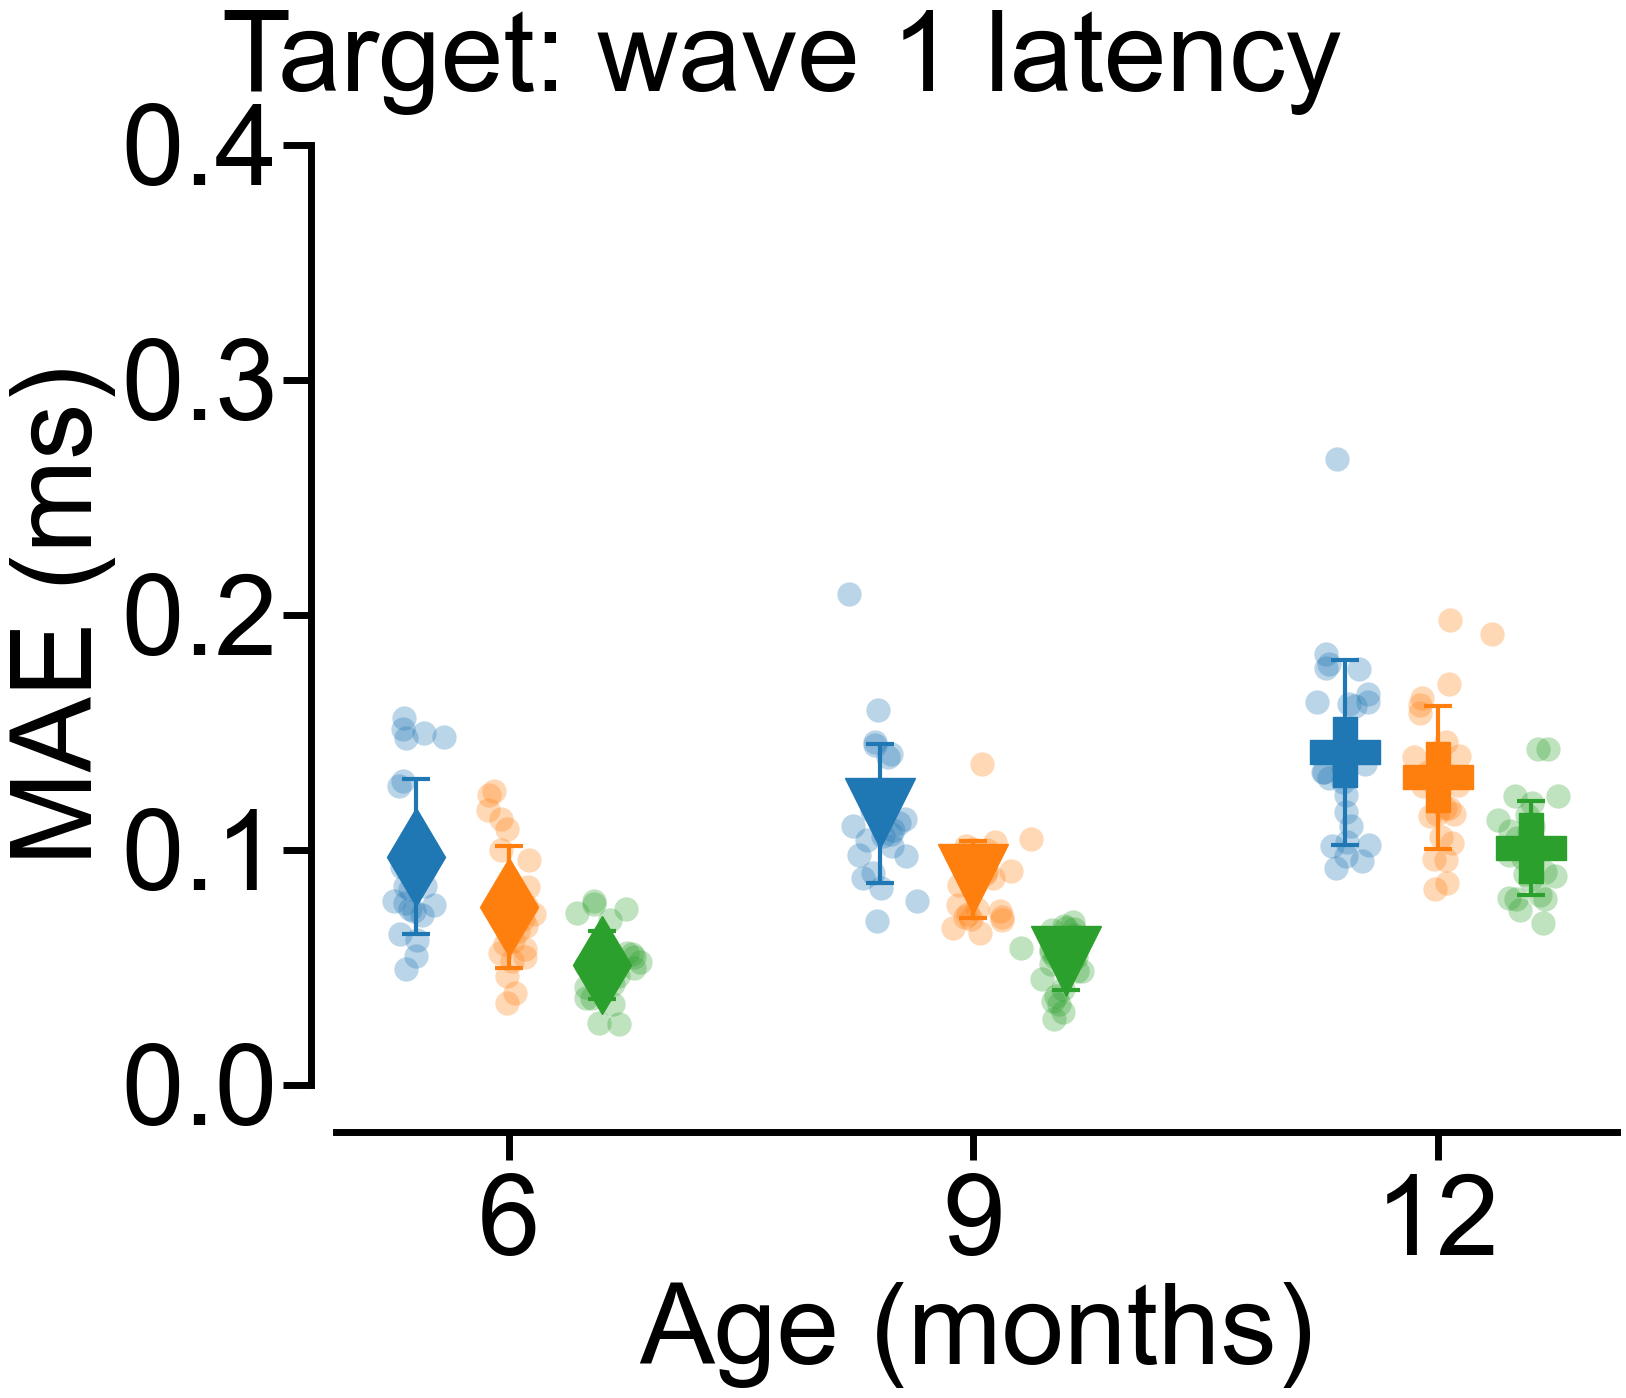

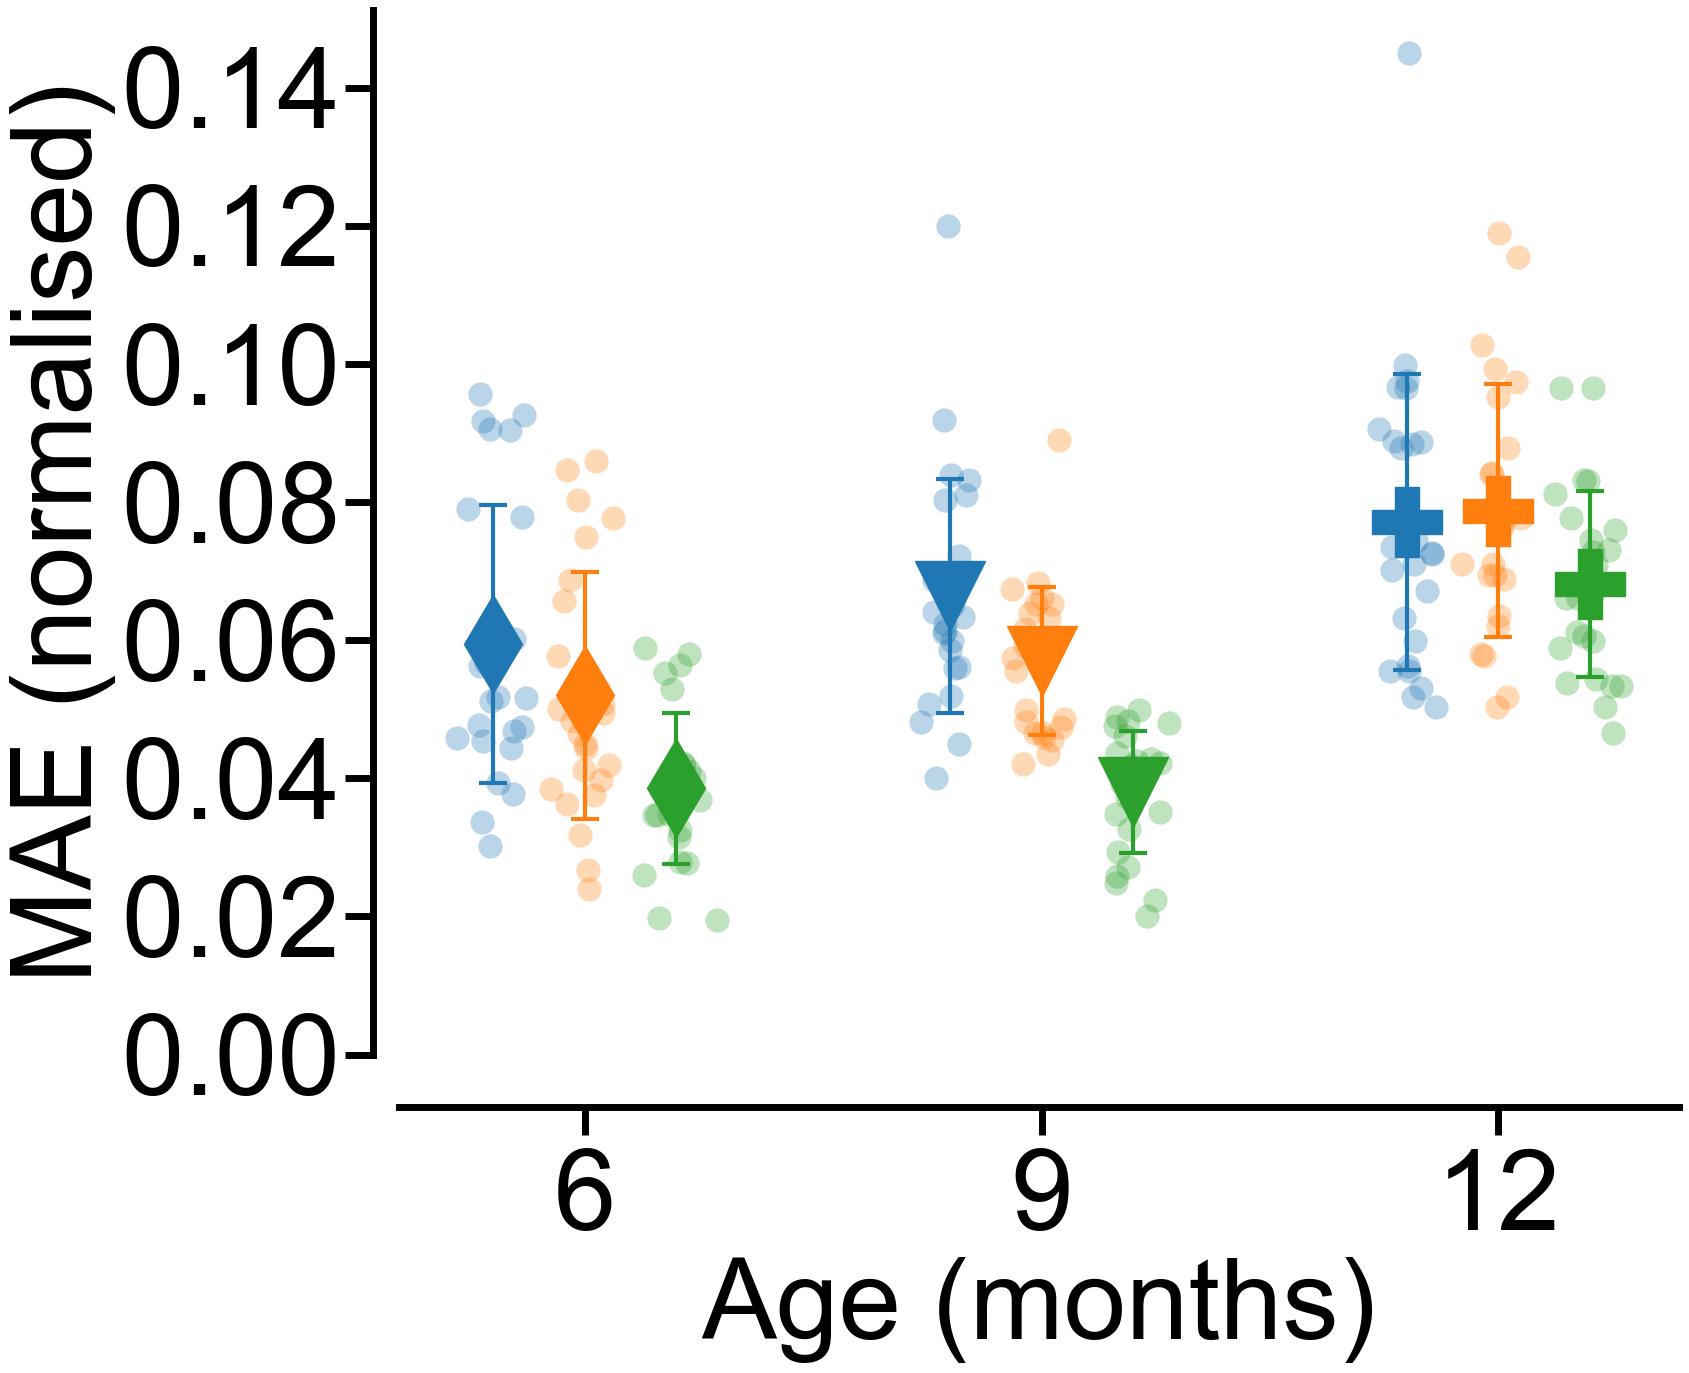

In [15]:
f,ax =makeFigureMAE(masterWaveLat,strain='Wave 1 latency',variable='MAE',ylabel='MAE (ms)',colorcycle=colorcycle,title='Target: wave 1 latency')
ylim(0,0.4)

ax.set_yticks(arange(0,0.41,0.1))
f.savefig('./Panels/wavelatVsAgeMAE.pdf',dpi=1200,transparent=True)
makeFigureMAE(masterWaveLat,strain='Wave 1 latency',variable='MAEpercent',ylabel='MAE (normalised)',colorcycle=colorcycle)
ylim(0,)

In [16]:
masterWaveLat.groupby(['Age','Intensity'])[['MAE','MAEpercent']].mean()

MAE MAEpercent
Age     Intensity                     
12month 55         0.141422   0.077056
        75         0.130797   0.078721
        95         0.100774   0.068067
6month  55         0.097031   0.059416
        75         0.075680   0.051992
        95         0.051138   0.038518
9month  55         0.115535   0.066419
        75         0.087403   0.056935
        95         0.052600   0.037997

In [17]:
# Thresholds]
frequencies = ['Click', '3 kHz', '6 kHz', '12 kHz', '18 kHz', '24 kHz',
       '30 kHz', '36 kHz', '42 kHz']

fs = 195000.0/2.0 # Acquisition sampling rate

data,thresholds,dataversion = at.loadFiles(datafolder='../../data')
thresholds['ID'] = thresholds['MouseN - AGE'].str.split(' - ',expand=True)[0].astype(int)
thresholds['Age (months)'] = thresholds['MouseN - AGE'].str.split(' - ',expand=True)[1].str.split('month',expand=True)[0].astype(int)
strain = []
for el in thresholds['ID']:
    strain.append(data.loc[data['ID']==el,'Strain'].values[0])
thresholds['Strain'] = strain
thresholds['Age'] = thresholds['Age (months)'].apply(lambda x: str(x)+'month')
thresholds['Intensity'] = 85

mouseList = thresholds.query("Age == '12month'")['ID'].unique() #chose only mice which have been investigated thorughout
thresholds = thresholds.query("ID in @mouseList")


The dataset version is: 20230914 - V41


In [18]:
thresholds

MouseN - AGE  Click  3 kHz  6 kHz  12 kHz  18 kHz  24 kHz  30 kHz  \
5     326821 - 1month     30     75     40      25      25      25      45   
6     326822 - 1month     35     70     40      20      25      30      45   
7     326823 - 1month     35     75     45      20      30      30      40   
8     326824 - 1month     30     75     40      20      25      30      45   
9     327621 - 1month     30     70     40      15      20      25      40   
..                ...    ...    ...    ...     ...     ...     ...     ...   
393  334601 - 12month     70     80     55      80     100     100     100   
394  334603 - 12month     65     75     50      80      85     100     100   
395  334602 - 12month     40     75     40      35      80     100     100   
396  334604 - 12month    100    100    100     100     100     100     100   
397  334605 - 12month     50     80     45      50      95     100     100   

     36 kHz  42 kHz      ID  Age (months)    Strain      Age  Intensity  
5        40      40  326821             1  Repaired   1month         85  
6        45      45  326822             1  Repaired   1month         85  
7        40      40  326823             1  Repaired   1month         85  
8        40      45  326824             1  Repaired   1month         85  
9        45      45  327621             1  Repaired   1month         85  
..      ...     ...     ...           ...       ...      ...        ...  
393     100     100  334601            12        6N  12month         85  
394     100     100  334603            12        6N  12month         85  
395     100     100  334602            12        6N  12month         85  
396     100     100  334604            12        6N  12month         85  
397     100     100  334605            12        6N  12month         85  

[315 rows x 15 columns]

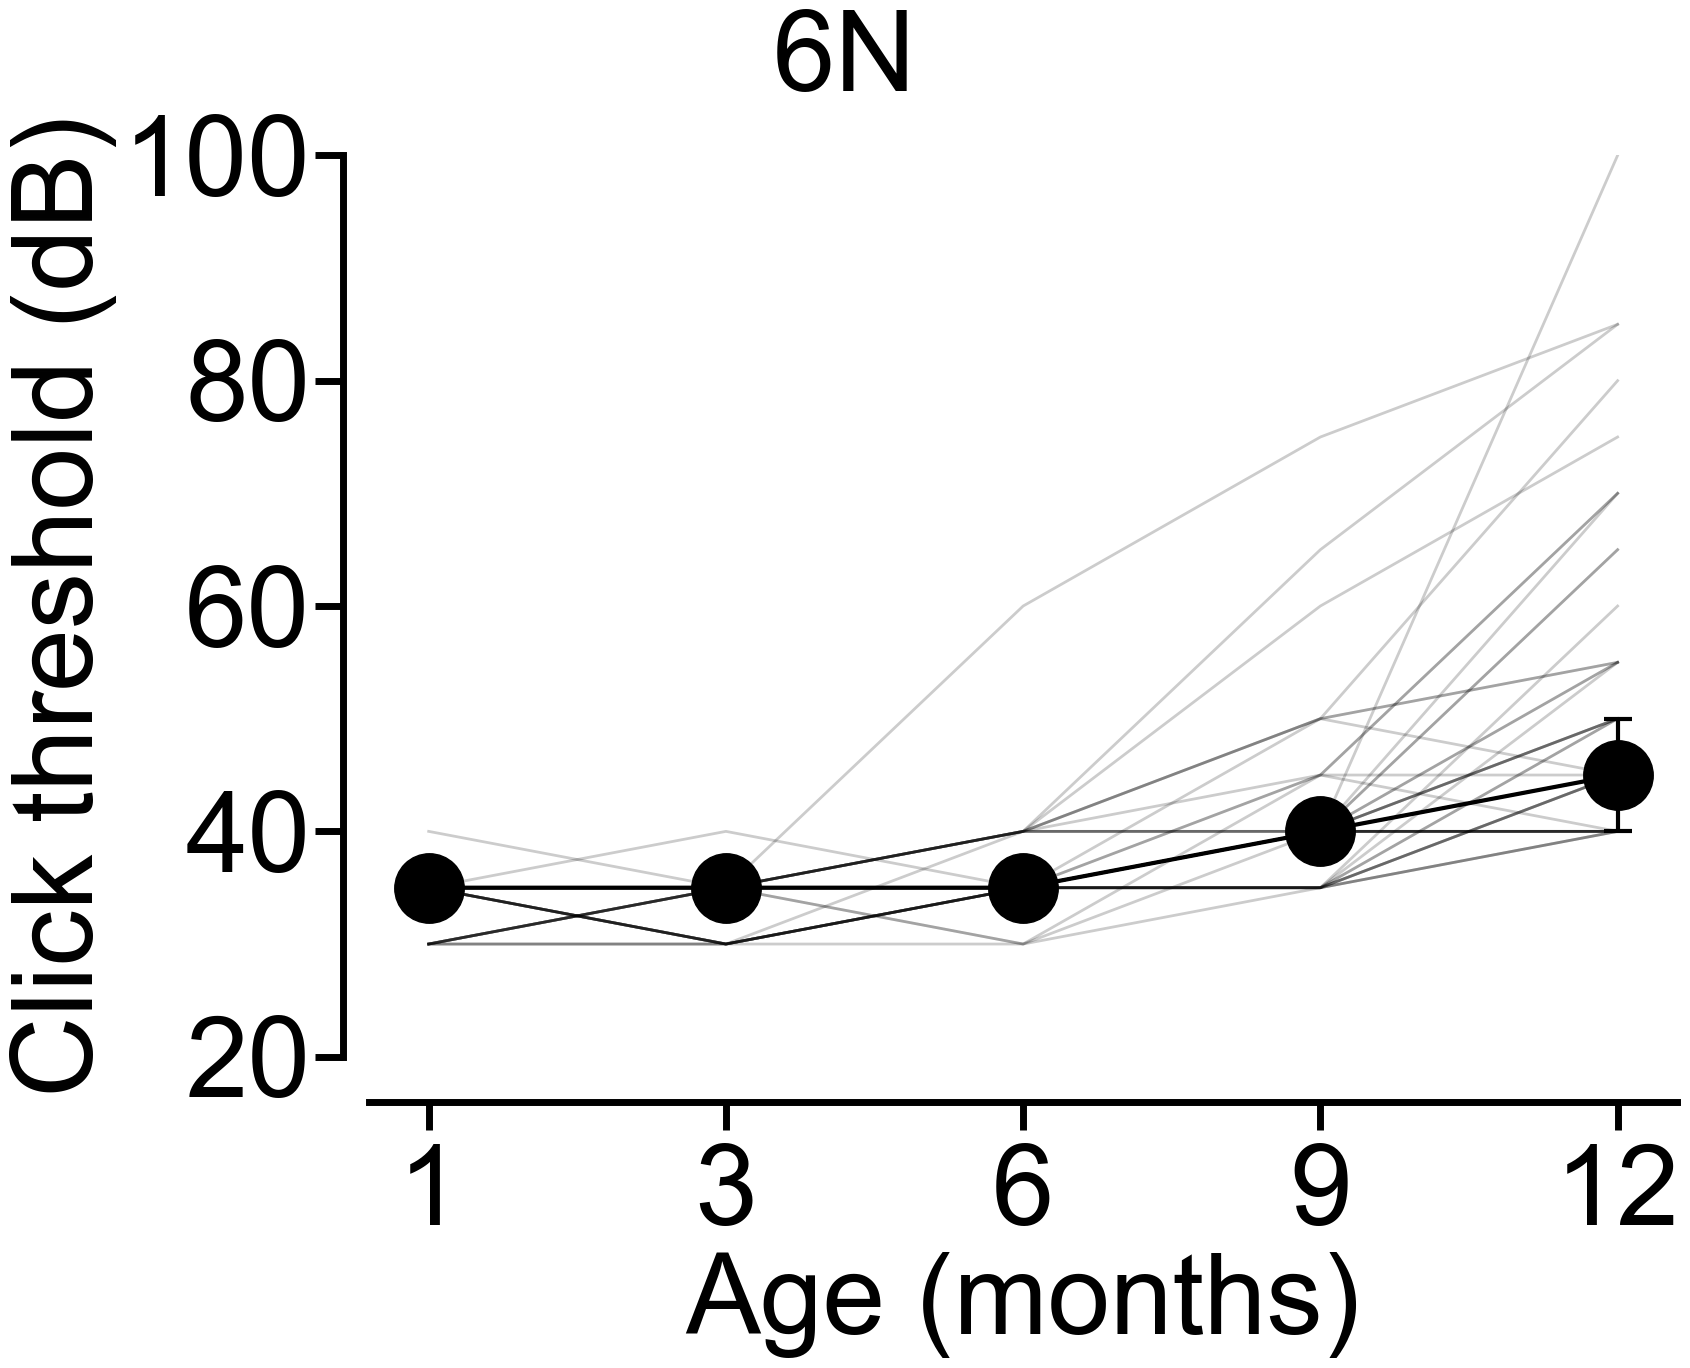

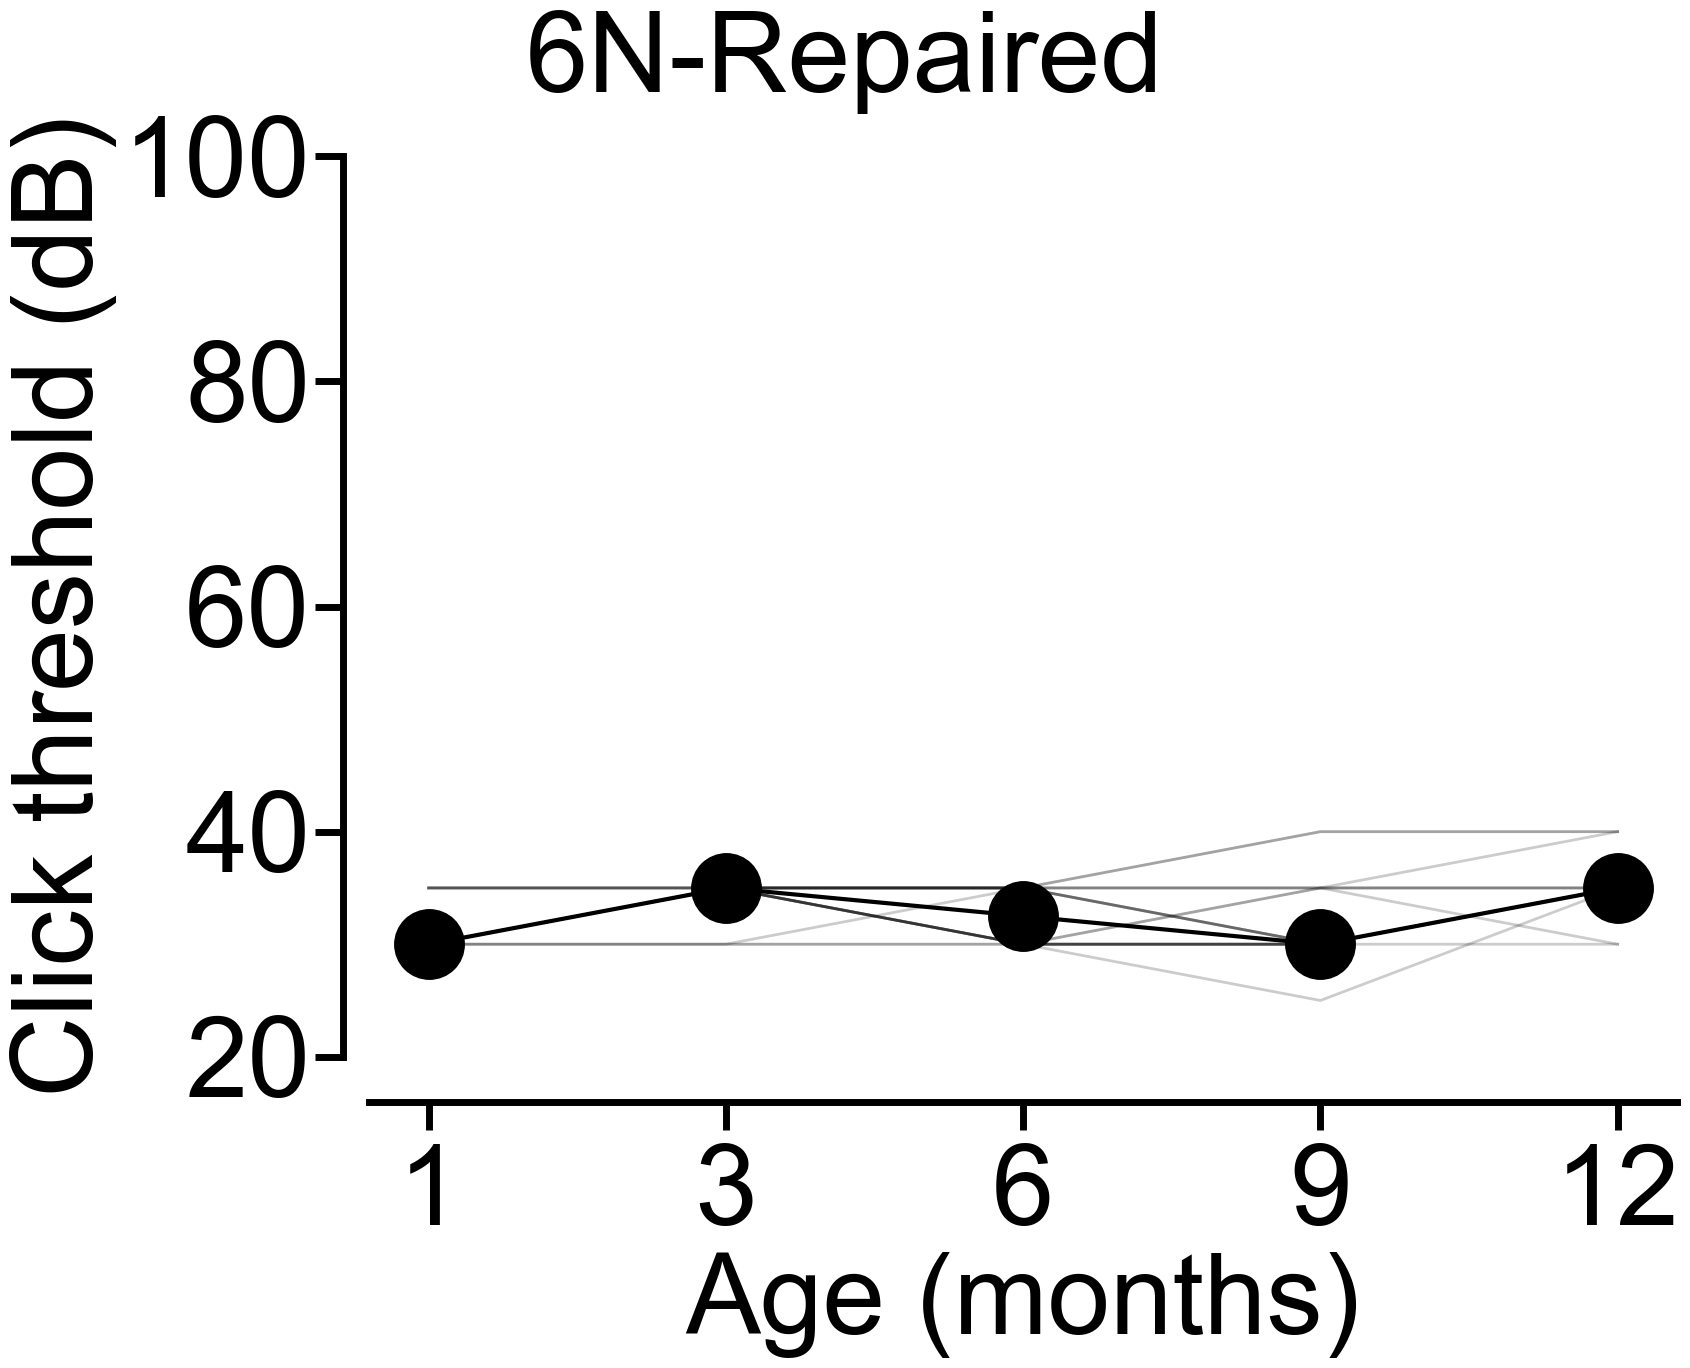

In [19]:
f,ax = makeFigure(thresholds,'6N','Click','Click threshold (dB)',colorcycle={85:'k'},ylim=(20,100),avgFunc='median',stdFunc='mad')
ax.set_yticks(arange(20,120,20))
f.savefig('./Panels/waveThreshVsAge6N.pdf',dpi=1200,transparent=True)

f2,ax = makeFigure(thresholds,'Repaired','Click','Click threshold (dB)',colorcycle={85:'k'},ylim=(20,100),avgFunc='median',stdFunc='mad')
ax.set_yticks(arange(20,120,20))
f2.savefig('./Panels/waveThreshVsAgeRep.pdf',dpi=1200,transparent=True)


In [20]:
thresholds['Mean threshold'] = thresholds[['Click', '3 kHz', '6 kHz', '12 kHz', '18 kHz', '24 kHz',
       '30 kHz', '36 kHz', '42 kHz']].mean(1)


In [21]:
meantr1month = thresholds.query("Age=='1month'")[['ID','Mean threshold']]
meantr1month['Age'] = '1month'
meantr1month2 = meantr1month.copy()
meantr1month2['Age'] = '3month'
meantr1month3 = meantr1month.copy()
meantr1month3['Age'] = '6month'
meantr1month4 = meantr1month.copy()
meantr1month4['Age'] = '9month'
meantr1month5 = meantr1month.copy()
meantr1month5['Age'] = '12month'
meantr1month = pd.concat([meantr1month,meantr1month2,meantr1month3,meantr1month4,meantr1month5]).set_index(['ID','Age'])

thresholds = thresholds.set_index(['ID','Age'])
thresholds['Shift in mean threshold'] = (thresholds['Mean threshold']-meantr1month['Mean threshold'])
thresholds=thresholds.reset_index()

In [22]:
df2 = thresholds.copy()
df2 = df2.rename({'Shift in mean threshold':'smt'},axis=1)
df2['Age'] = df2['Age'].astype('category')
#df2 = df2.query("Strain=='Repaired'")

In [23]:
df2

ID      Age      MouseN - AGE  Click  3 kHz  6 kHz  12 kHz  18 kHz  \
0    326821   1month   326821 - 1month     30     75     40      25      25   
1    326822   1month   326822 - 1month     35     70     40      20      25   
2    326823   1month   326823 - 1month     35     75     45      20      30   
3    326824   1month   326824 - 1month     30     75     40      20      25   
4    327621   1month   327621 - 1month     30     70     40      15      20   
..      ...      ...               ...    ...    ...    ...     ...     ...   
310  334601  12month  334601 - 12month     70     80     55      80     100   
311  334603  12month  334603 - 12month     65     75     50      80      85   
312  334602  12month  334602 - 12month     40     75     40      35      80   
313  334604  12month  334604 - 12month    100    100    100     100     100   
314  334605  12month  334605 - 12month     50     80     45      50      95   

     24 kHz  30 kHz  36 kHz  42 kHz  Age (months)    Strain  Intensity  \
0        25      45      40      40             1  Repaired         85   
1        30      45      45      45             1  Repaired         85   
2        30      40      40      40             1  Repaired         85   
3        30      45      40      45             1  Repaired         85   
4        25      40      45      45             1  Repaired         85   
..      ...     ...     ...     ...           ...       ...        ...   
310     100     100     100     100            12        6N         85   
311     100     100     100     100            12        6N         85   
312     100     100     100     100            12        6N         85   
313     100     100     100     100            12        6N         85   
314     100     100     100     100            12        6N         85   

     Mean threshold        smt  
0         38.333333   0.000000  
1         39.444444   0.000000  
2         39.444444   0.000000  
3         38.888889   0.000000  
4         36.666667   0.000000  
..              ...        ...  
310       87.222222  49.444444  
311       83.888889  31.666667  
312       74.444444  30.555556  
313      100.000000  61.111111  
314       80.000000  38.888889  

[315 rows x 17 columns]

In [24]:
%%R -i df2 -o out2,out0,out1,out3,ss
res.aov <- aov(smt ~ Age+Strain, df2) # 'accuracy', 'test_precision_scorer_avg',     'test_recall_scorer_avg', 'roc_auc_score'
ss <- summary(res.aov)

out2 <- as.data.frame(TukeyHSD(res.aov)[2])
out0 <- as.data.frame(TukeyHSD(res.aov)[0])
out1 <- as.data.frame(TukeyHSD(res.aov)[1])
out3 <- as.data.frame(TukeyHSD(res.aov)[3])

In [25]:
ss

o{'None':                 Df        Sum Sq       Mean Sq     F value        Pr(>F)
Age            4.0  32080.045072   8020.011268  144.201728  2.195911e-69
Strain         1.0  19435.533608  19435.533608  349.455561  1.069537e-52
Residuals    309.0  17185.532432     55.616610         NaN           NaN, }

In [26]:
out1

Age.diff    Age.lwr    Age.upr     Age.p.adj
1month-12month -28.350970 -31.997030 -24.704910  1.023404e-12
3month-12month -20.652557 -24.298617 -17.006497  1.023404e-12
6month-12month -12.760141 -16.406201  -9.114081  1.070921e-12
9month-12month  -6.102293  -9.748353  -2.456233  6.236961e-05
3month-1month    7.698413   4.052353  11.344473  1.689994e-07
6month-1month   15.590829  11.944769  19.236889  1.028067e-12
9month-1month   22.248677  18.602617  25.894737  1.023404e-12
6month-3month    7.892416   4.246356  11.538476  7.661963e-08
9month-3month   14.550265  10.904205  18.196325  1.054490e-12
9month-6month    6.657848   3.011788  10.303908  9.035677e-06

In [27]:
df2.groupby(['Strain','Age'])['smt'].agg([mean,std])

/var/folders/n2/bkzw0ff907zgpgprdz_rg_tr0000gn/T/ipykernel_60169/1579534028.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df2.groupby(['Strain','Age'])['smt'].agg([mean,std])
/var/folders/n2/bkzw0ff907zgpgprdz_rg_tr0000gn/T/ipykernel_60169/1579534028.py:1: FutureWarning: The provided callable <function mean at 0x10971b2e0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df2.groupby(['Strain','Age'])['smt'].agg([mean,std])
/var/folders/n2/bkzw0ff907zgpgprdz_rg_tr0000gn/T/ipykernel_60169/1579534028.py:1: FutureWarning: The provided callable <function std at 0x10971b420> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be us

mean       std
Strain   Age                         
6N       12month  38.012346  5.865698
         1month    0.000000  0.000000
         3month    8.592593  3.968521
         6month   21.580247  5.373214
         9month   30.543210  4.671427
Repaired 12month   4.197531  4.253335
         1month    0.000000  0.000000
         3month    5.462963  3.970891
         6month    0.617284  1.836538
         9month    1.512346  3.737995

In [28]:
thresholds

ID      Age      MouseN - AGE  Click  3 kHz  6 kHz  12 kHz  18 kHz  \
0    326821   1month   326821 - 1month     30     75     40      25      25   
1    326822   1month   326822 - 1month     35     70     40      20      25   
2    326823   1month   326823 - 1month     35     75     45      20      30   
3    326824   1month   326824 - 1month     30     75     40      20      25   
4    327621   1month   327621 - 1month     30     70     40      15      20   
..      ...      ...               ...    ...    ...    ...     ...     ...   
310  334601  12month  334601 - 12month     70     80     55      80     100   
311  334603  12month  334603 - 12month     65     75     50      80      85   
312  334602  12month  334602 - 12month     40     75     40      35      80   
313  334604  12month  334604 - 12month    100    100    100     100     100   
314  334605  12month  334605 - 12month     50     80     45      50      95   

     24 kHz  30 kHz  36 kHz  42 kHz  Age (months)    Strain  Intensity  \
0        25      45      40      40             1  Repaired         85   
1        30      45      45      45             1  Repaired         85   
2        30      40      40      40             1  Repaired         85   
3        30      45      40      45             1  Repaired         85   
4        25      40      45      45             1  Repaired         85   
..      ...     ...     ...     ...           ...       ...        ...   
310     100     100     100     100            12        6N         85   
311     100     100     100     100            12        6N         85   
312     100     100     100     100            12        6N         85   
313     100     100     100     100            12        6N         85   
314     100     100     100     100            12        6N         85   

     Mean threshold  Shift in mean threshold  
0         38.333333                 0.000000  
1         39.444444                 0.000000  
2         39.444444                 0.000000  
3         38.888889                 0.000000  
4         36.666667                 0.000000  
..              ...                      ...  
310       87.222222                49.444444  
311       83.888889                31.666667  
312       74.444444                30.555556  
313      100.000000                61.111111  
314       80.000000                38.888889  

[315 rows x 17 columns]

In [29]:
# f,ax = makeFigure(thresholds,'6N','Mean threshold','Average threshold (dB)',colorcycle={85:'k'},ylim=(20,100),avgFunc='mean',stdFunc='std')
# ax.set_yticks(arange(20,120,20))
# f.savefig('./Panels/waveAvgThreshVsAge6N.pdf',dpi=1200,transparent=True)

# f,ax = makeFigure(thresholds,'Repaired','Mean threshold','Average threshold (dB)',colorcycle={85:'k'},ylim=(20,100),avgFunc='mean',stdFunc='std')
# ax.set_yticks(arange(20,120,20))
# f.savefig('./Panels/waveAvgThreshVsAgeRep.pdf',dpi=1200,transparent=True)


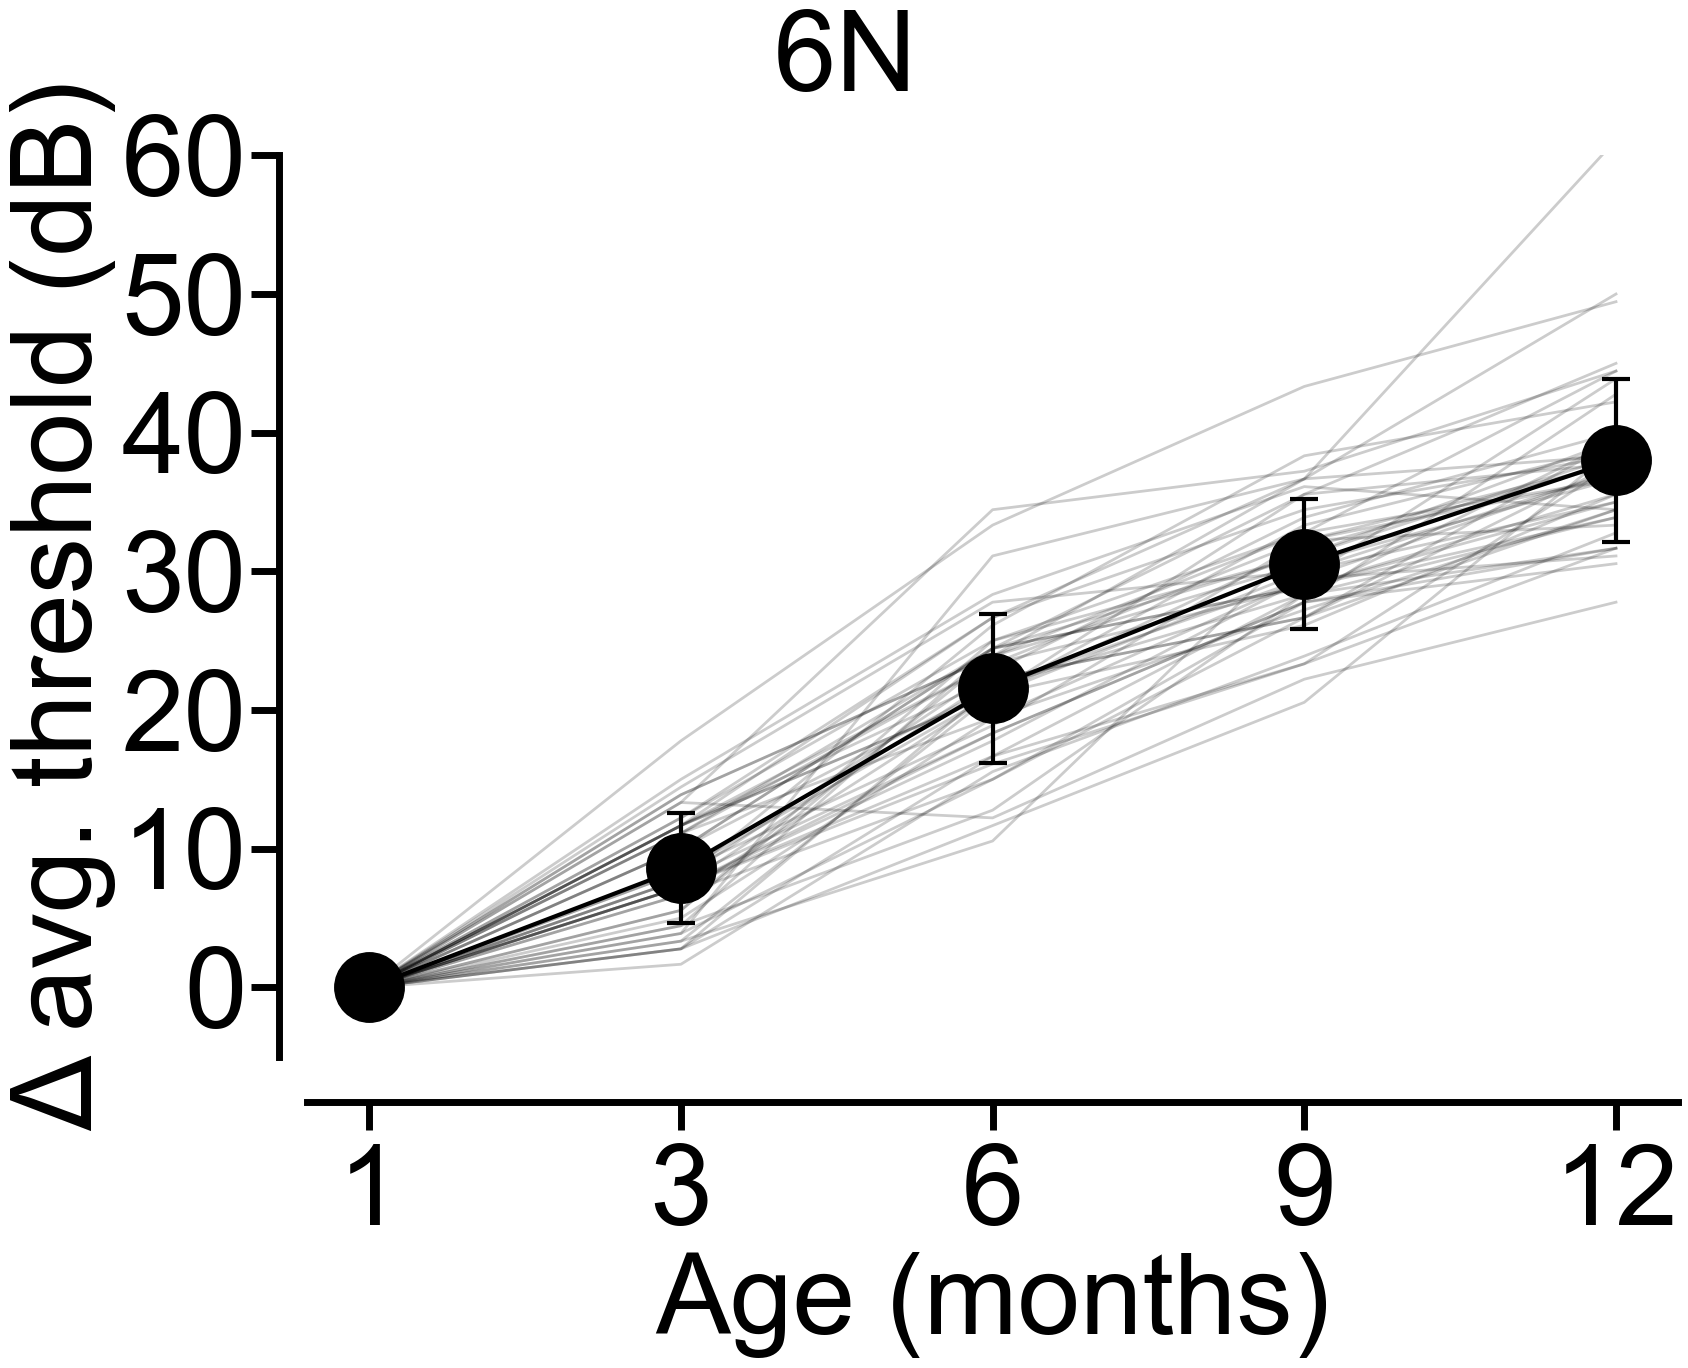

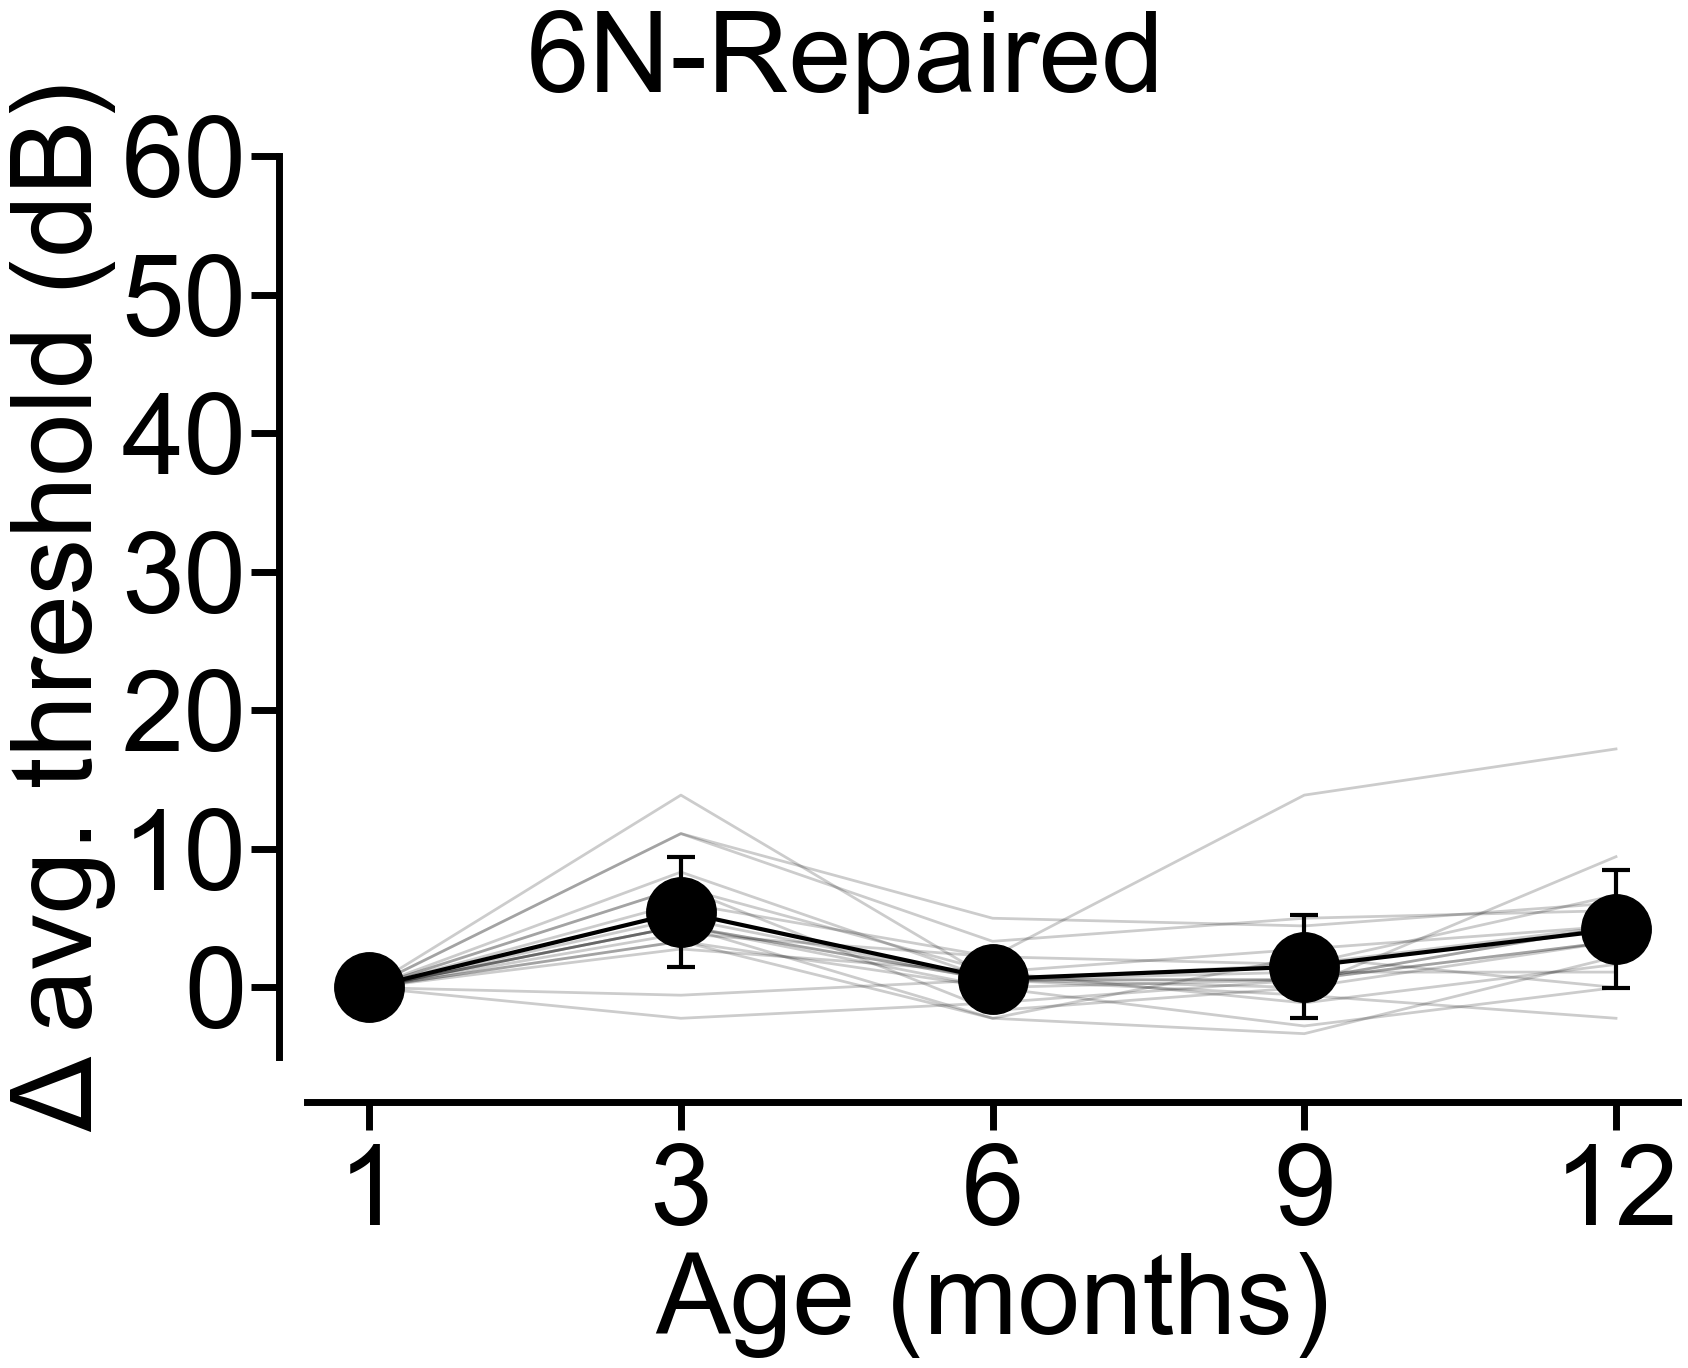

In [30]:
f,ax = makeFigure(thresholds,'6N','Shift in mean threshold','Δ avg. threshold (dB)',colorcycle={85:'k'},ylim=(-5,60),avgFunc='mean',stdFunc='std')
#ax.set_yticks(arange(20,120,20))#
f.savefig('./Panels/waveAvgThreshShiftVsAge6N.pdf',dpi=1200,transparent=True)

f,ax = makeFigure(thresholds,'Repaired','Shift in mean threshold','Δ avg. threshold (dB)',colorcycle={85:'k'},ylim=(-5,60),avgFunc='mean',stdFunc='std')
#ax.set_yticks(arange(20,120,20))
f.savefig('./Panels/waveAvgThreshShiftVsAgeRep.pdf',dpi=1200,transparent=True)

Load the result of simulation: random forest trained with click data

In [31]:
savefolder = os.path.join('../../','results','2024-11-21-regression_results')#'2024-04-26-regressionResults'
modelNames = ['RandomForestRegressor']
inputFreqs = ['[100]']#,'None'
targetAges = ['6month','9month','12month']
inputAges =  ['[\'1month\', \'3month\']']
modelType = 'DThreshold'
dfs = []
dfsTest = []

for modelName in modelNames:
    for inputFreq in inputFreqs:
        for targetAge in targetAges:
            for inputAge in inputAges:
                filename = f'{modelName}{targetAge}-{modelType}-{inputAge}-inputFreq{inputFreq}-resultsCV.csv'
                df = pd.read_csv(os.path.join(savefolder,filename),index_col=0)
                df['InputFreq'] = inputFreq
                df['TargetAge'] = targetAge
                df['InputAge'] = inputAge
                df['ModelName'] = modelName
                dfs.append(df)

                filename = f'{modelName}{targetAge}-{modelType}-{inputAge}-inputFreq{inputFreq}-resultsTest.csv'
                df2 = pd.read_csv(os.path.join(savefolder,filename),index_col=0)
                df2['InputFreq'] = inputFreq
                df2['TargetAge'] = targetAge
                df2['InputAge'] = inputAge
                df2['ModelName'] = modelName
                dfsTest.append(df2)
master = pd.concat(dfs,ignore_index=True)
master['Age'] = master['TargetAge']
#master['Age (months)'] = master['TargetAge'].str.split('month').apply(lambda x:int(x[0])) # Do this to comply with the threshold
masterTest = pd.concat(dfsTest,ignore_index=True)
masterTestMelt = masterTest.melt(value_vars = ['y_predict','y_test'],id_vars = ['Mouse ID', 'Strain', 'InputFreq', 'TargetAge','InputAge', 'ModelName'])


masterTest['Mouse ID'] = masterTest['Mouse ID'].astype(str)
masterTestMelt['Mouse ID'] = masterTestMelt['Mouse ID'].astype(str)



#Calculate the noramlised MAE (to the average threshold shift at that age)
avgThresholds = pd.DataFrame(thresholds.query("Strain=='6N'").groupby('Age')['Shift in mean threshold'].mean())

master['MAEpercent'] = None
for i,el in master.iterrows():
    master.loc[i,'MAEpercent'] = el['MAE']/avgThresholds.loc[el['Age']].values[0]
master['Strain'] = 'Δ avg. threshold'
master['Intensity']= 85

   Age  Intensity      mean      std
1    0         85  5.620029  1.05196
   Age  Intensity      mean       std
2    1         85  6.180344  1.877009
   Age  Intensity      mean       std
0    2         85  7.566492  2.154811
   Age  Intensity      mean       std
1    0         85  0.260425  0.048746
   Age  Intensity      mean       std
2    1         85  0.202348  0.061454
   Age  Intensity      mean       std
0    2         85  0.199054  0.056687


(0.0, 0.4352225851870763)

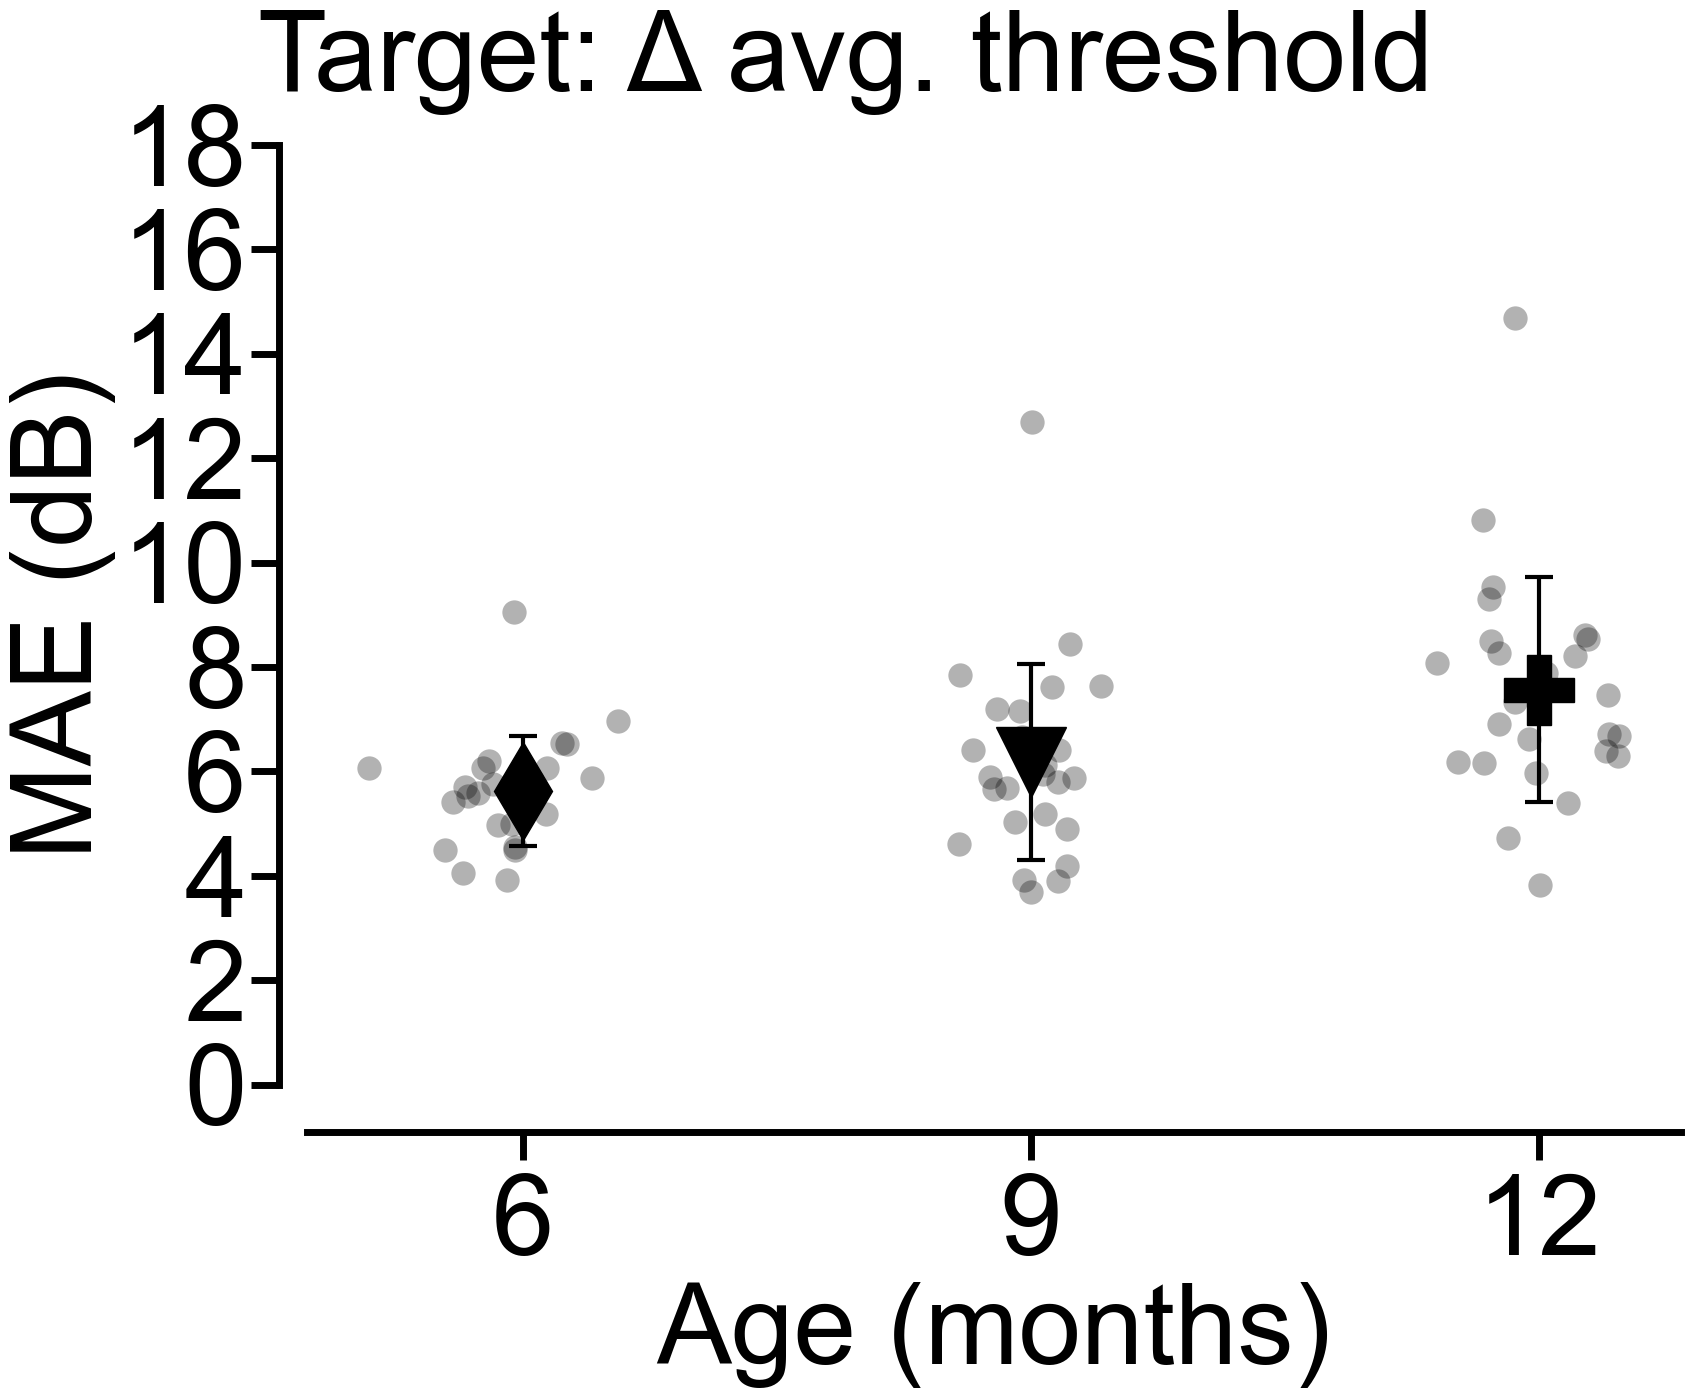

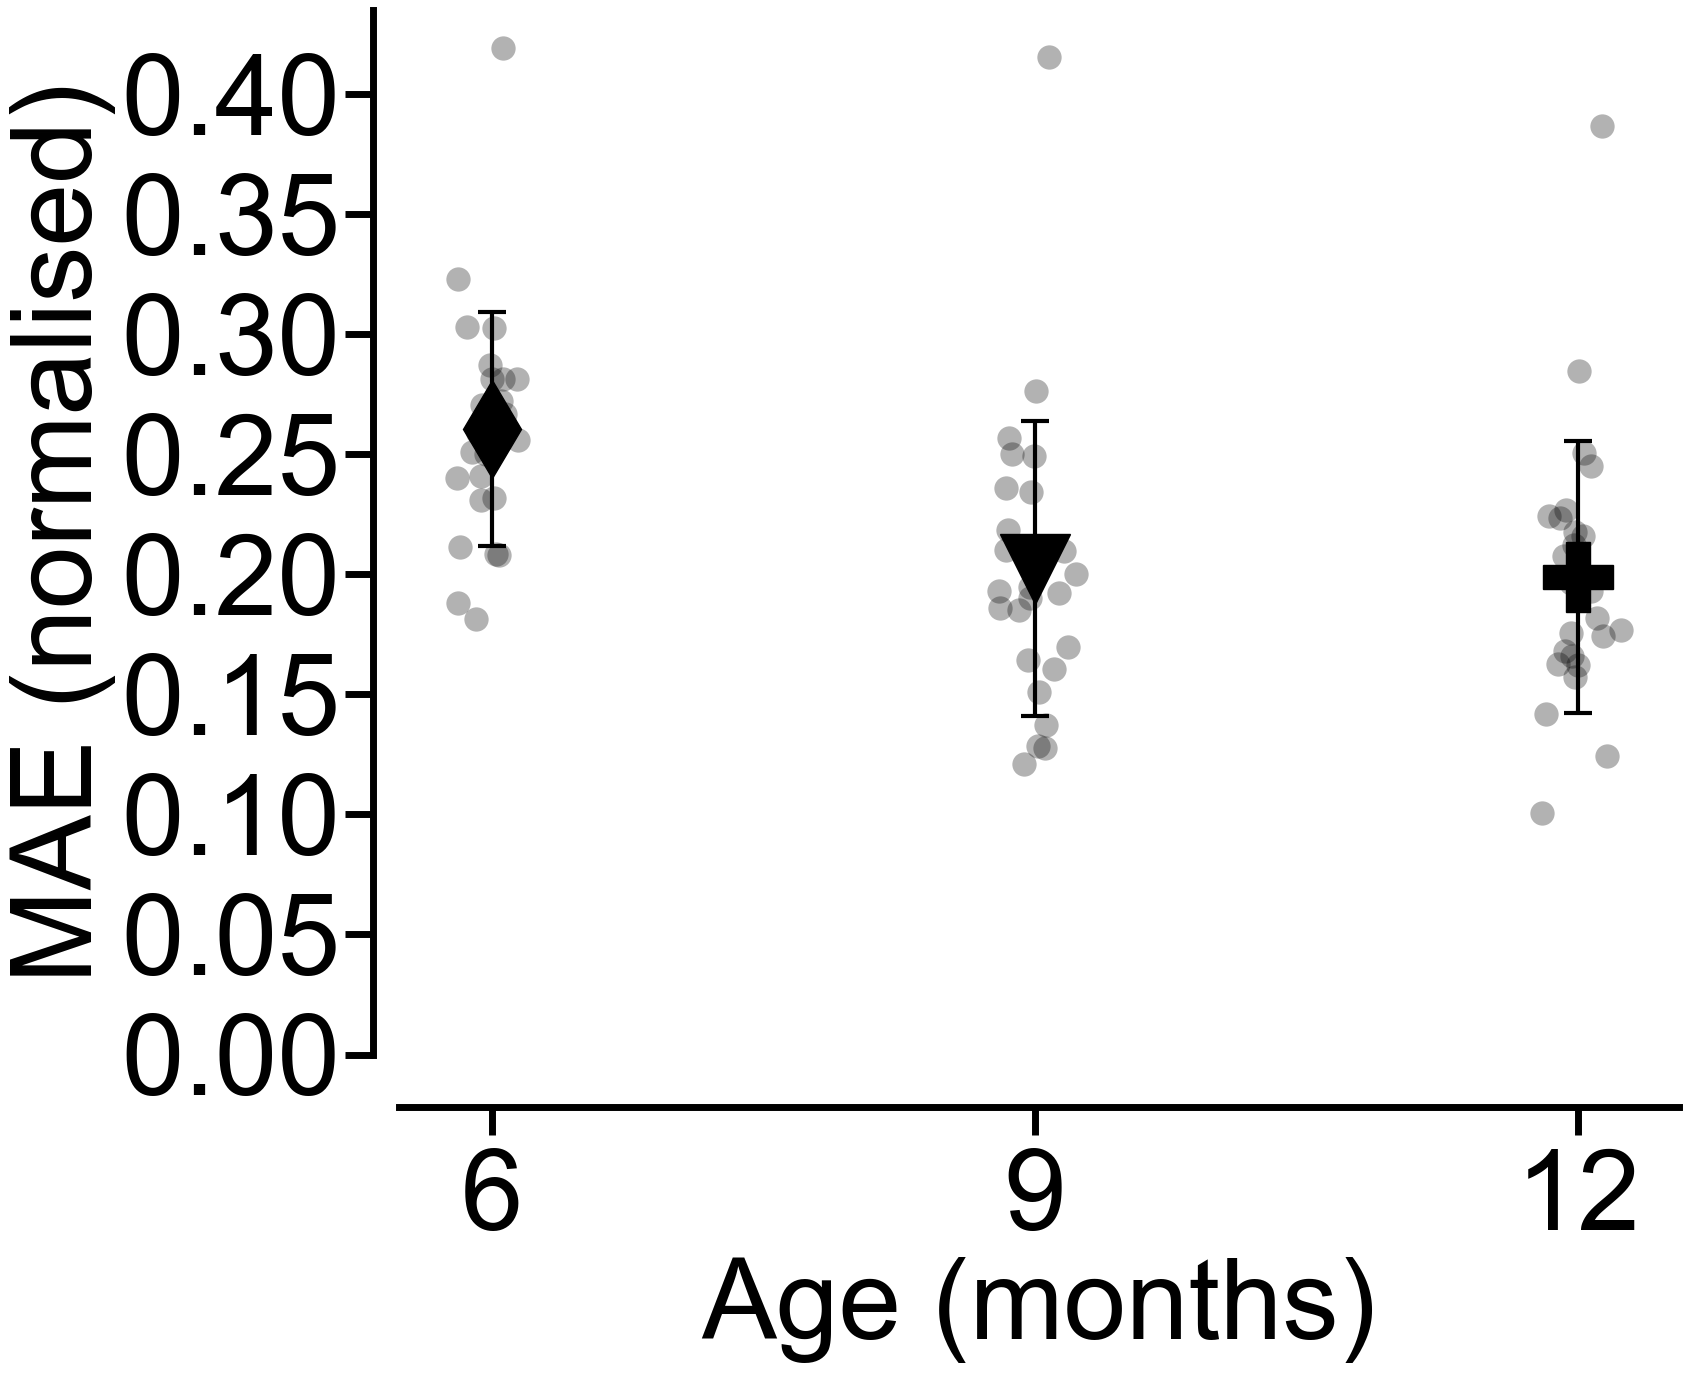

In [32]:
f,ax = makeFigureMAE(master,strain='Δ avg. threshold',variable='MAE',ylabel='MAE (dB)',colorcycle={85:'k'},
                     scatterSpread=1/10,title='Target: Δ avg. threshold')
ylim(0,18)

f.savefig('./Panels/thresholdVsAgeMAE.pdf',dpi=1200,transparent=True)

makeFigureMAE(master,strain='Δ avg. threshold',variable='MAEpercent',ylabel='MAE (normalised)',colorcycle={85:'k'})
ylim(0,)


# Average of the CV split


In [31]:
ia = "['1month', '3month']"
masterWaveAmp.query('InputAge==@ia').groupby(['Intensity','Age'])[['MAE','MAEpercent']].agg([mean,std,min,max,'count'])

/var/folders/n2/bkzw0ff907zgpgprdz_rg_tr0000gn/T/ipykernel_56420/1144420308.py:2: FutureWarning: The provided callable <function mean at 0x1221b56c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  masterWaveAmp.query('InputAge==@ia').groupby(['Intensity','Age'])[['MAE','MAEpercent']].agg([mean,std,min,max,'count'])
/var/folders/n2/bkzw0ff907zgpgprdz_rg_tr0000gn/T/ipykernel_56420/1144420308.py:2: FutureWarning: The provided callable <function std at 0x1221b57e0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  masterWaveAmp.query('InputAge==@ia').groupby(['Intensity','Age'])[['MAE','MAEpercent']].agg([mean,std,min,max,'count'])
/var/folders/n2/bkzw0ff907zgpgprdz_rg_tr0000gn/T/ipykernel_56420/1144420308.py:2: FutureWarning: The provided calla

MAE                                     MAEpercent  \
                       mean       std       min       max count       mean   
Intensity Age                                                                
55        12month  0.683727  0.164743  0.436156  1.128413    25   0.586327   
          6month   0.714229  0.172881  0.349986  1.007259    25   0.218213   
          9month   0.736085  0.270620  0.323662  1.431390    25   0.351504   
75        12month  0.992809  0.261599  0.641697  1.775527    25    0.45147   
          6month   0.825883  0.257361  0.438421  1.271165    25   0.194292   
          9month   0.957244  0.332084  0.535914  1.983667    25      0.307   
95        12month  0.833109  0.226730  0.559518  1.577315    25   0.361694   
          6month   1.063858  0.329873  0.554370  2.086493    25   0.272115   
          9month   1.030059  0.367300  0.634204  2.065953    25   0.348438   

                                                       
                        std       min       max count  
Intensity Age                                          
55        12month  0.141274  0.374023  0.967665    25  
          6month   0.052819  0.106928   0.30774    25  
          9month   0.129229  0.154559  0.683534    25  
75        12month  0.118960  0.291805  0.807403    25  
          6month   0.060545   0.10314  0.299047    25  
          9month   0.106503  0.171874  0.636186    25  
95        12month  0.098435  0.242915   0.68479    25  
          6month   0.084375  0.141797  0.533686    25  
          9month   0.124247  0.214532   0.69885    25

In [32]:
masterWaveLat.query('InputAge==@ia').groupby(['Intensity','Age'])[['MAE','MAEpercent']].agg([mean,std,'count'])

/var/folders/n2/bkzw0ff907zgpgprdz_rg_tr0000gn/T/ipykernel_56420/3268153556.py:1: FutureWarning: The provided callable <function mean at 0x1221b56c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  masterWaveLat.query('InputAge==@ia').groupby(['Intensity','Age'])[['MAE','MAEpercent']].agg([mean,std,'count'])
/var/folders/n2/bkzw0ff907zgpgprdz_rg_tr0000gn/T/ipykernel_56420/3268153556.py:1: FutureWarning: The provided callable <function std at 0x1221b57e0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  masterWaveLat.query('InputAge==@ia').groupby(['Intensity','Age'])[['MAE','MAEpercent']].agg([mean,std,'count'])
/var/folders/n2/bkzw0ff907zgpgprdz_rg_tr0000gn/T/ipykernel_56420/3268153556.py:1: FutureWarning: The provided callable <function me

MAE                 MAEpercent                
                       mean       std count       mean       std count
Intensity Age                                                         
55        12month  0.141422  0.039343    25   0.077056  0.021437    25
          6month   0.097031  0.032936    25   0.059416  0.020168    25
          9month   0.115535  0.029520    25   0.066419  0.016971    25
75        12month  0.130797  0.030450    25   0.078721  0.018326    25
          6month   0.075680  0.026074    25   0.051992  0.017913    25
          9month   0.087403  0.016486    25   0.056935  0.010739    25
95        12month  0.100774  0.019947    25   0.068067  0.013473    25
          6month   0.051138  0.014497    25   0.038518  0.010920    25
          9month   0.052600  0.012204    25   0.037997  0.008816    25

In [33]:
master.query('InputAge==@ia').groupby(['Age'])[['MAE','MAEpercent']].agg([mean,std,min,max,'count'])

/var/folders/n2/bkzw0ff907zgpgprdz_rg_tr0000gn/T/ipykernel_56420/724455559.py:1: FutureWarning: The provided callable <function mean at 0x1221b56c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  master.query('InputAge==@ia').groupby(['Age'])[['MAE','MAEpercent']].agg([mean,std,min,max,'count'])
/var/folders/n2/bkzw0ff907zgpgprdz_rg_tr0000gn/T/ipykernel_56420/724455559.py:1: FutureWarning: The provided callable <function std at 0x1221b57e0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  master.query('InputAge==@ia').groupby(['Age'])[['MAE','MAEpercent']].agg([mean,std,min,max,'count'])
/var/folders/n2/bkzw0ff907zgpgprdz_rg_tr0000gn/T/ipykernel_56420/724455559.py:1: FutureWarning: The provided callable <built-in function min> is currently 

MAE                                      MAEpercent            \
             mean       std       min        max count       mean       std   
Age                                                                           
12month  7.566492  2.154811  3.831180  14.694383    25   0.199054  0.056687   
6month   5.620029  1.051960  3.918172   9.048535    25   0.260425  0.048746   
9month   6.180344  1.877009  3.697696  12.692172    25   0.202348  0.061454   

                                   
              min       max count  
Age                                
12month  0.100788  0.386569    25  
6month   0.181563  0.419297    25  
9month   0.121064  0.415548    25

In [34]:
master

RMSE        MAE          MAPE        R2   MaxError InputFreq  \
0    7.277726   6.526341  2.643935e+15  0.475911  12.032302     [100]   
1    6.566481   5.703531  2.903586e+15  0.462179  12.387331     [100]   
2    6.077986   4.561678  2.740833e+00  0.635113  12.704897     [100]   
3    5.092167   4.056846  4.358903e-01  0.708286  10.141710     [100]   
4    7.576145   6.970914  5.078860e+00  0.522096  11.929284     [100]   
..        ...        ...           ...       ...        ...       ...   
70  11.171668   8.210588  5.386059e-01  0.534075  27.299066     [100]   
71   9.423432   7.889321  7.385421e-01  0.471121  17.895345     [100]   
72   5.083661   3.831180  5.836036e-01  0.820381  10.019483     [100]   
73  17.511119  14.694383  6.087663e+00 -0.030851  30.505237     [100]   
74   9.784861   6.162181  4.466134e+15  0.625128  24.231952     [100]   

   TargetAge              InputAge              ModelName      Age MAEpercent  \
0     6month  ['1month', '3month']  RandomForestRegressor   6month   0.302422   
1     6month  ['1month', '3month']  RandomForestRegressor   6month   0.264294   
2     6month  ['1month', '3month']  RandomForestRegressor   6month   0.211382   
3     6month  ['1month', '3month']  RandomForestRegressor   6month   0.187989   
4     6month  ['1month', '3month']  RandomForestRegressor   6month   0.323023   
..       ...                   ...                    ...      ...        ...   
70   12month  ['1month', '3month']  RandomForestRegressor  12month   0.215998   
71   12month  ['1month', '3month']  RandomForestRegressor  12month   0.207546   
72   12month  ['1month', '3month']  RandomForestRegressor  12month   0.100788   
73   12month  ['1month', '3month']  RandomForestRegressor  12month   0.386569   
74   12month  ['1month', '3month']  RandomForestRegressor  12month    0.16211   

              Strain  Intensity  
0   Δ avg. threshold         85  
1   Δ avg. threshold         85  
2   Δ avg. threshold         85  
3   Δ avg. threshold         85  
4   Δ avg. threshold         85  
..               ...        ...  
70  Δ avg. threshold         85  
71  Δ avg. threshold         85  
72  Δ avg. threshold         85  
73  Δ avg. threshold         85  
74  Δ avg. threshold         85  

[75 rows x 13 columns]

Let's make the test figures

In [33]:
def makeFigureTest(df,mouseIds,targetAges,label,colorcycle,intensities = [1],title ='',ylim=None,colorEncodeIntensity = False,figsize=(17,14),showyax = True,showxlabel=True):
    f= figure(figsize=figsize)
    f.suptitle(title,fontsize=fontSize,y=1)
    gs= gridspec.GridSpec(1, 1,figure=f)



    dff = df.copy()

    ax = plt.subplot(gs[0])
    if ylim is not None:
        ax.set_ylim(ylim)
        ax.set_xlim(ylim)
        ax.plot(ylim,ylim,'--',color='grey',linewidth=3)
    
    symbols = ["d","v","P"]
    for intens in intensities:
        for i,id in enumerate(mouseIds):
                if intens==1:
                    df2 = dff.query('`Mouse ID`==@id')
                else:
                    df2 = dff.query('`Mouse ID`==@id & SoundLevel==@intens')
                if colorEncodeIntensity:
                    color = colorcycle[intens]
                else:
                    color = colorcycle[id]
                plot(df2['y_test'],df2['y_predict'],'-',
                    markersize=markersize,clip_on=False,linewidth=3,color = color)
                for j,age in enumerate(targetAges):
                    df3 = df2.query('TargetAge==@age')
                    plot(df3['y_test'],df3['y_predict'],symbols[j],markeredgecolor=color,markerfacecolor=[1,1,1,1],markeredgewidth=3,
                        markersize=markersize*0.7,clip_on=False,linewidth=3) 
#            plot(df2['Age'].apply(lambda x: {'1month':0,'3month':1,'6month':2,'9month':3,'12month':4}[x]),df2[variable].values.T,linewidth=2,alpha=0.2,label=intensity,color=colorcycle[intensity])
    
 

    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.left.set_visible(True)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_visible(True)

    ax.set_xlabel(f'Real {label}')
    ax.set_ylabel(f'Predicted {label}')
    # ax.set_xticks(arange(5),[1,3,6,9,12])
    #ax.spines['left'].set_position(('axes', -0.05))
    #ax.spines['bottom'].set_position(('axes', -0.05))
    #ax.tick_params(axis='y', which='minor', left=True)
    ax.tick_params(axis="y", direction="out", which="minor", right=False, top=False,left=True)
    ax.tick_params(axis="x", direction="out", which="minor", right=False, top=False,left=False,bottom=True)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
       item.set_fontsize(fontSize)

    gs.tight_layout(f) 
    if showyax == False:
            ax.yaxis.set_visible(False)
            ax.spines.left.set_visible(False)
    if showxlabel == False:
         ax.set_xlabel(' ')
    return f,ax

In [34]:
ia = "['1month', '3month']"
targetAges = ['6month', '9month','12month']
masterTest = masterTest.query('InputAge==@ia')
mouseIds = masterTest['Mouse ID'].unique()
cmap = plt.cm.get_cmap('tab20b', len(mouseIds)).colors
cmap2 = plt.cm.get_cmap('tab20b', 3).colors
colorcycle = {}
colorcycle3 = {}
for i,mid in enumerate(mouseIds):
    colorcycle[mid] = cmap[i,:]
    colorcycle3[mid] = 'k'
colorcycle2 = dict(zip(['55dB','75dB','95dB'],plt.rcParams['axes.prop_cycle'].by_key()['color'][0:]))

/var/folders/n2/bkzw0ff907zgpgprdz_rg_tr0000gn/T/ipykernel_60169/2536677170.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20b', len(mouseIds)).colors
/var/folders/n2/bkzw0ff907zgpgprdz_rg_tr0000gn/T/ipykernel_60169/2536677170.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap2 = plt.cm.get_cmap('tab20b', 3).colors


In [35]:
len(masterTest['Mouse ID'].unique())

16

In [36]:
from sklearn.metrics import r2_score, mean_absolute_error
print(r2_score(masterTest['y_test'],masterTest['y_predict']))
print(mean_absolute_error(masterTest['y_test'],masterTest['y_predict']))

0.6645925803293093
4.944718470565578


In [37]:
for age in targetAges:
    el = masterTest.query("TargetAge==@age")
    print(r2_score(el['y_test'],el['y_predict']))
    print(mean_absolute_error(el['y_test'],el['y_predict']))

0.6483664128179341
4.286409329482247
0.6245675401027092
5.31215134252435
0.6265363656532874
5.235594739690137


In [38]:
masterTest.query("TargetAge=='12month' & Strain=='Repaired'")

y_test  y_predict Mouse ID    Strain InputFreq TargetAge  \
33  0.000000   5.168842   327636  Repaired     [100]   12month   
38  2.222222  13.205714   327620  Repaired     [100]   12month   
42  3.333333  37.498311   326822  Repaired     [100]   12month   
43  4.444444   6.721849   326824  Repaired     [100]   12month   
44  5.555556   5.985417   327619  Repaired     [100]   12month   

                InputAge              ModelName  
33  ['1month', '3month']  RandomForestRegressor  
38  ['1month', '3month']  RandomForestRegressor  
42  ['1month', '3month']  RandomForestRegressor  
43  ['1month', '3month']  RandomForestRegressor  
44  ['1month', '3month']  RandomForestRegressor

In [ ]:
file_name = {326243:'good',331174:'bad',331184:'ugly',332774:'uglier'} repaired : 326821

In [60]:
masterTest['Mouse ID'].unique()

array(['333773', '327636', '335027', '331176', '332774', '334603',
       '327620', '333774', '333799', '330578', '326822', '326824',
       '327619', '332783', '333783', '333771'], dtype=object)

In [65]:
thresholds[thresholds['ID']==326822]

ID      Age      MouseN - AGE  Click  3 kHz  6 kHz  12 kHz  18 kHz  \
1   326822   1month   326822 - 1month     35     70     40      20      25   
19  326822   3month   326822 - 3month     35     75     45      25      30   
39  326822   6month   326822 - 6month     35     65     35      20      25   
55  326822   9month   326822 - 9month     35     75     30      20      25   
72  326822  12month  326822 - 12month     30     90     40      20      25   

    24 kHz  30 kHz  36 kHz  42 kHz  Age (months)    Strain  Intensity  \
1       30      45      45      45             1  Repaired         85   
19      45      60      60      45             3  Repaired         85   
39      30      45      45      40             6  Repaired         85   
55      35      45      50      40             9  Repaired         85   
72      30      40      70      40            12  Repaired         85   

    Mean threshold  Shift in mean threshold  
1        39.444444                 0.000000  
19       46.666667                 7.222222  
39       37.777778                -1.666667  
55       39.444444                 0.000000  
72       42.777778                 3.333333

In [64]:
masterTest[masterTest['Mouse ID']=='326822']['y_test'].values

array([-1.66666667,  0.        ,  3.33333333])

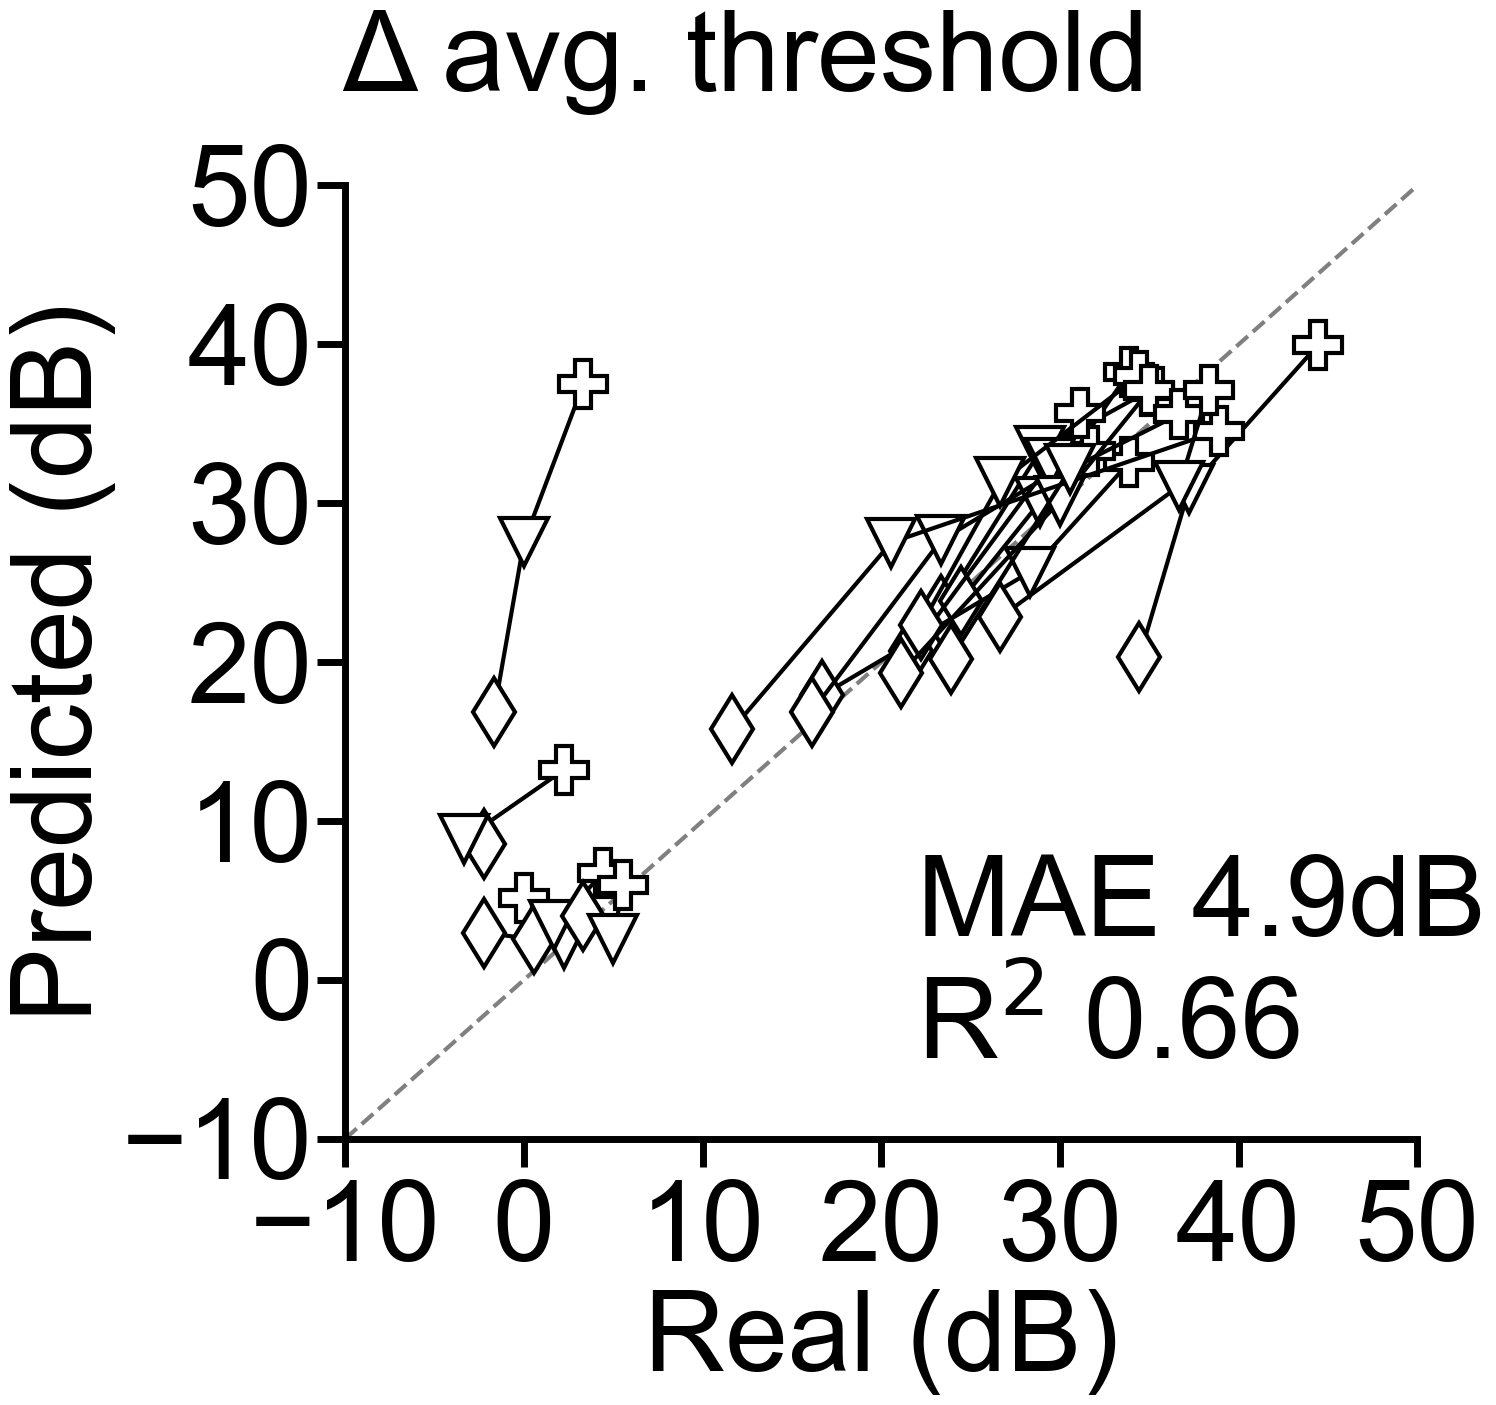

In [39]:
f,ax = makeFigureTest(masterTest,mouseIds,targetAges,'(dB)',title='Δ avg. threshold',ylim=(-10,50),colorcycle=colorcycle3,figsize=(15,14))
r2 = r2_score(masterTest['y_test'],masterTest['y_predict'])
mae= mean_absolute_error(masterTest['y_test'],masterTest['y_predict'])
ax.text(22,-5,f'MAE {mae:.1f}dB\nR$^2$ {r2:.2f}',fontsize=fontSize)


f.savefig('./Panels/thresholdVsAgeTest.pdf',dpi=1200,transparent=True)


In [42]:
ia = "['1month', '3month']"
sl = '75dB'
masterAmpTest2 = masterAmpTest.query("InputAge==@ia")

In [43]:
print("One summary for all the models combined")
from sklearn.metrics import r2_score, mean_absolute_error
print(f"R2: {r2_score(masterAmpTest2['y_test'],masterAmpTest2['y_predict'])}")
print(f"MAE: {mean_absolute_error(masterAmpTest2['y_test'],masterAmpTest2['y_predict'])}")

print("\nOne summary for one model at each intensity")
for intens in ['55dB','75dB','95dB']:

    el = masterAmpTest2.query("SoundLevel==@intens")
    print(f'{intens}')
    print(f"R2: {r2_score(el['y_test'],el['y_predict'])}")
    print(f"MAE: {mean_absolute_error(el['y_test'],el['y_predict'])}")


print("\nOne summary for one model at each intensity and at each age")
for intens in ['55dB','75dB','95dB']:
    for age in targetAges:
        print(f'{age} - {intens}')
        el = masterAmpTest2.query("TargetAge==@age & SoundLevel==@intens")
        print(f"R2: {r2_score(el['y_test'],el['y_predict'])}")
        print(f"MAE: {mean_absolute_error(el['y_test'],el['y_predict'])}")


One summary for all the models combined
R2: 0.6656850917541015
MAE: 0.8323776125149808

One summary for one model at each intensity
55dB
R2: 0.5922502571168904
MAE: 0.7536692286488571
75dB
R2: 0.6412206873524849
MAE: 0.8956143307774699
95dB
R2: 0.6791032630393665
MAE: 0.8478492781186157

One summary for one model at each intensity and at each age
6month - 55dB
R2: 0.32786736337877787
MAE: 0.8303461161480854
9month - 55dB
R2: 0.3617648075758475
MAE: 0.8678473266546438
12month - 55dB
R2: 0.5987406140393612
MAE: 0.562814243143842
6month - 75dB
R2: 0.5251965470084796
MAE: 1.0147067062144153
9month - 75dB
R2: 0.5690638439645102
MAE: 0.9031049693696056
12month - 75dB
R2: 0.6337284801176644
MAE: 0.7690313167483886
6month - 95dB
R2: 0.7256212215794237
MAE: 0.7036214361746145
9month - 95dB
R2: 0.7053326387364247
MAE: 0.7638161421159559
12month - 95dB
R2: 0.5187099784029071
MAE: 1.0761102560652762


(<Figure size 1700x1400 with 1 Axes>,
 <Axes: xlabel='Real (μV)', ylabel='Predicted (μV)'>)

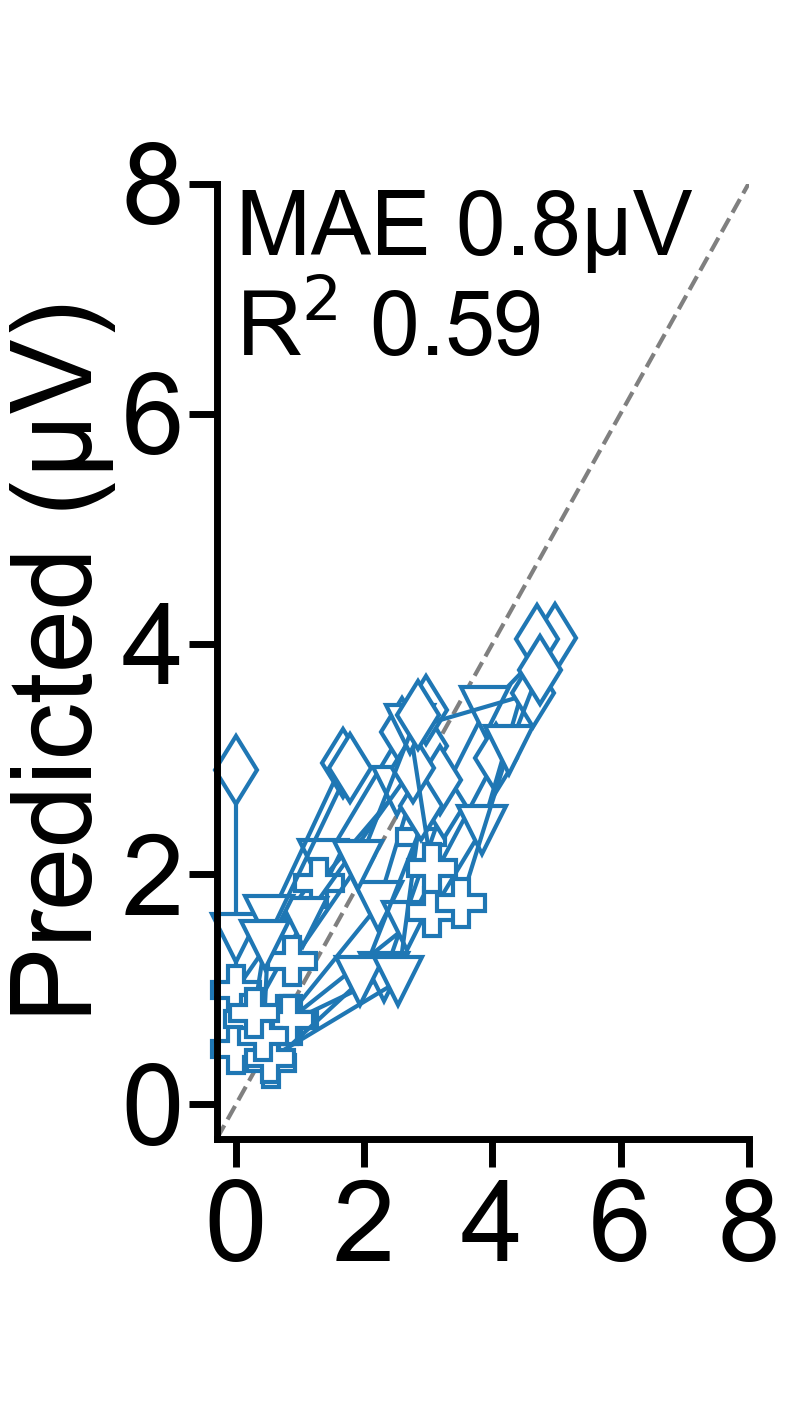

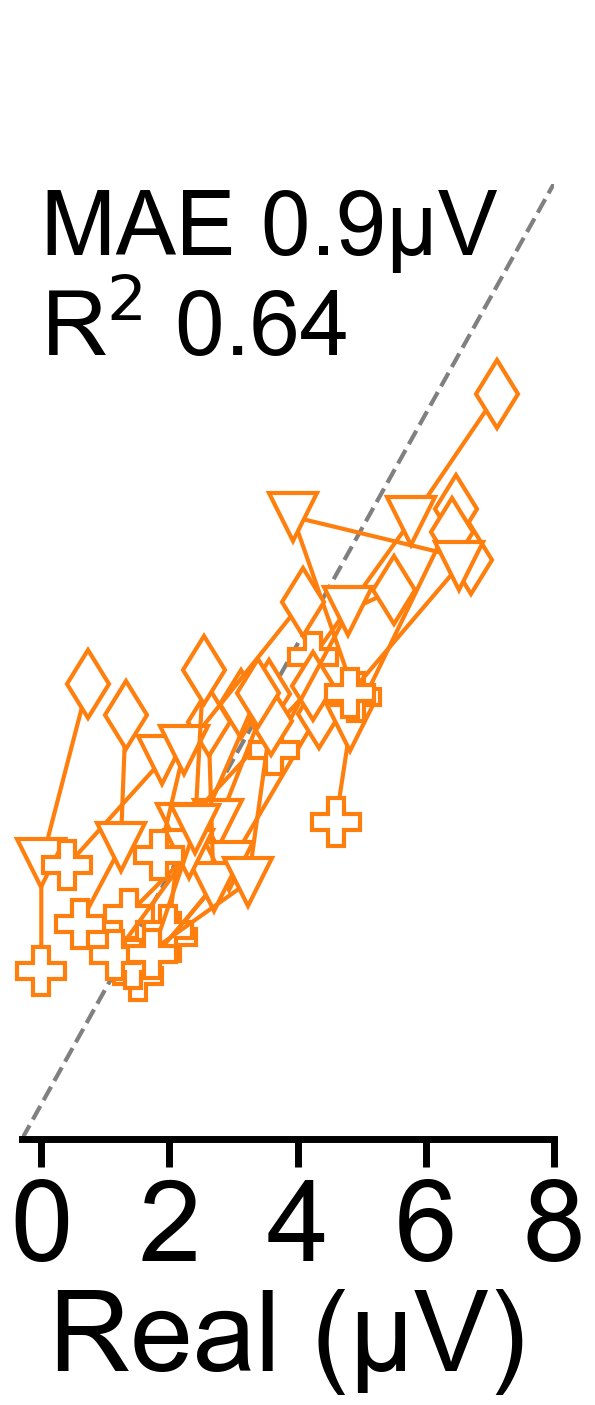

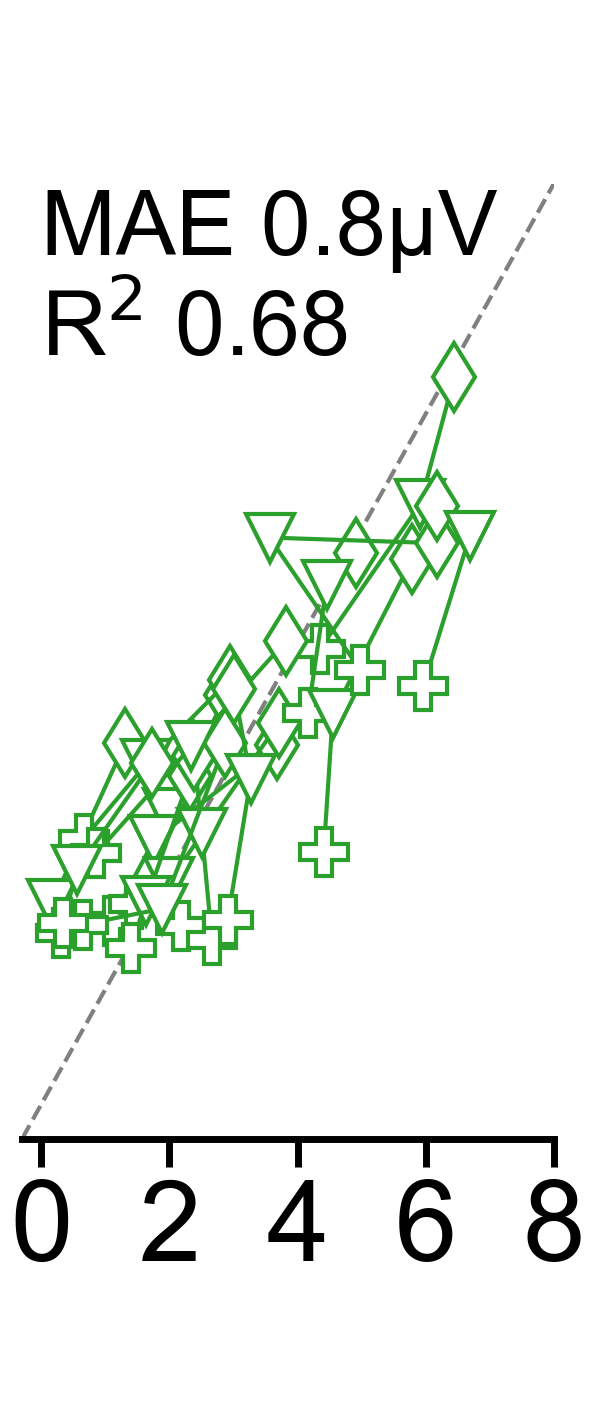

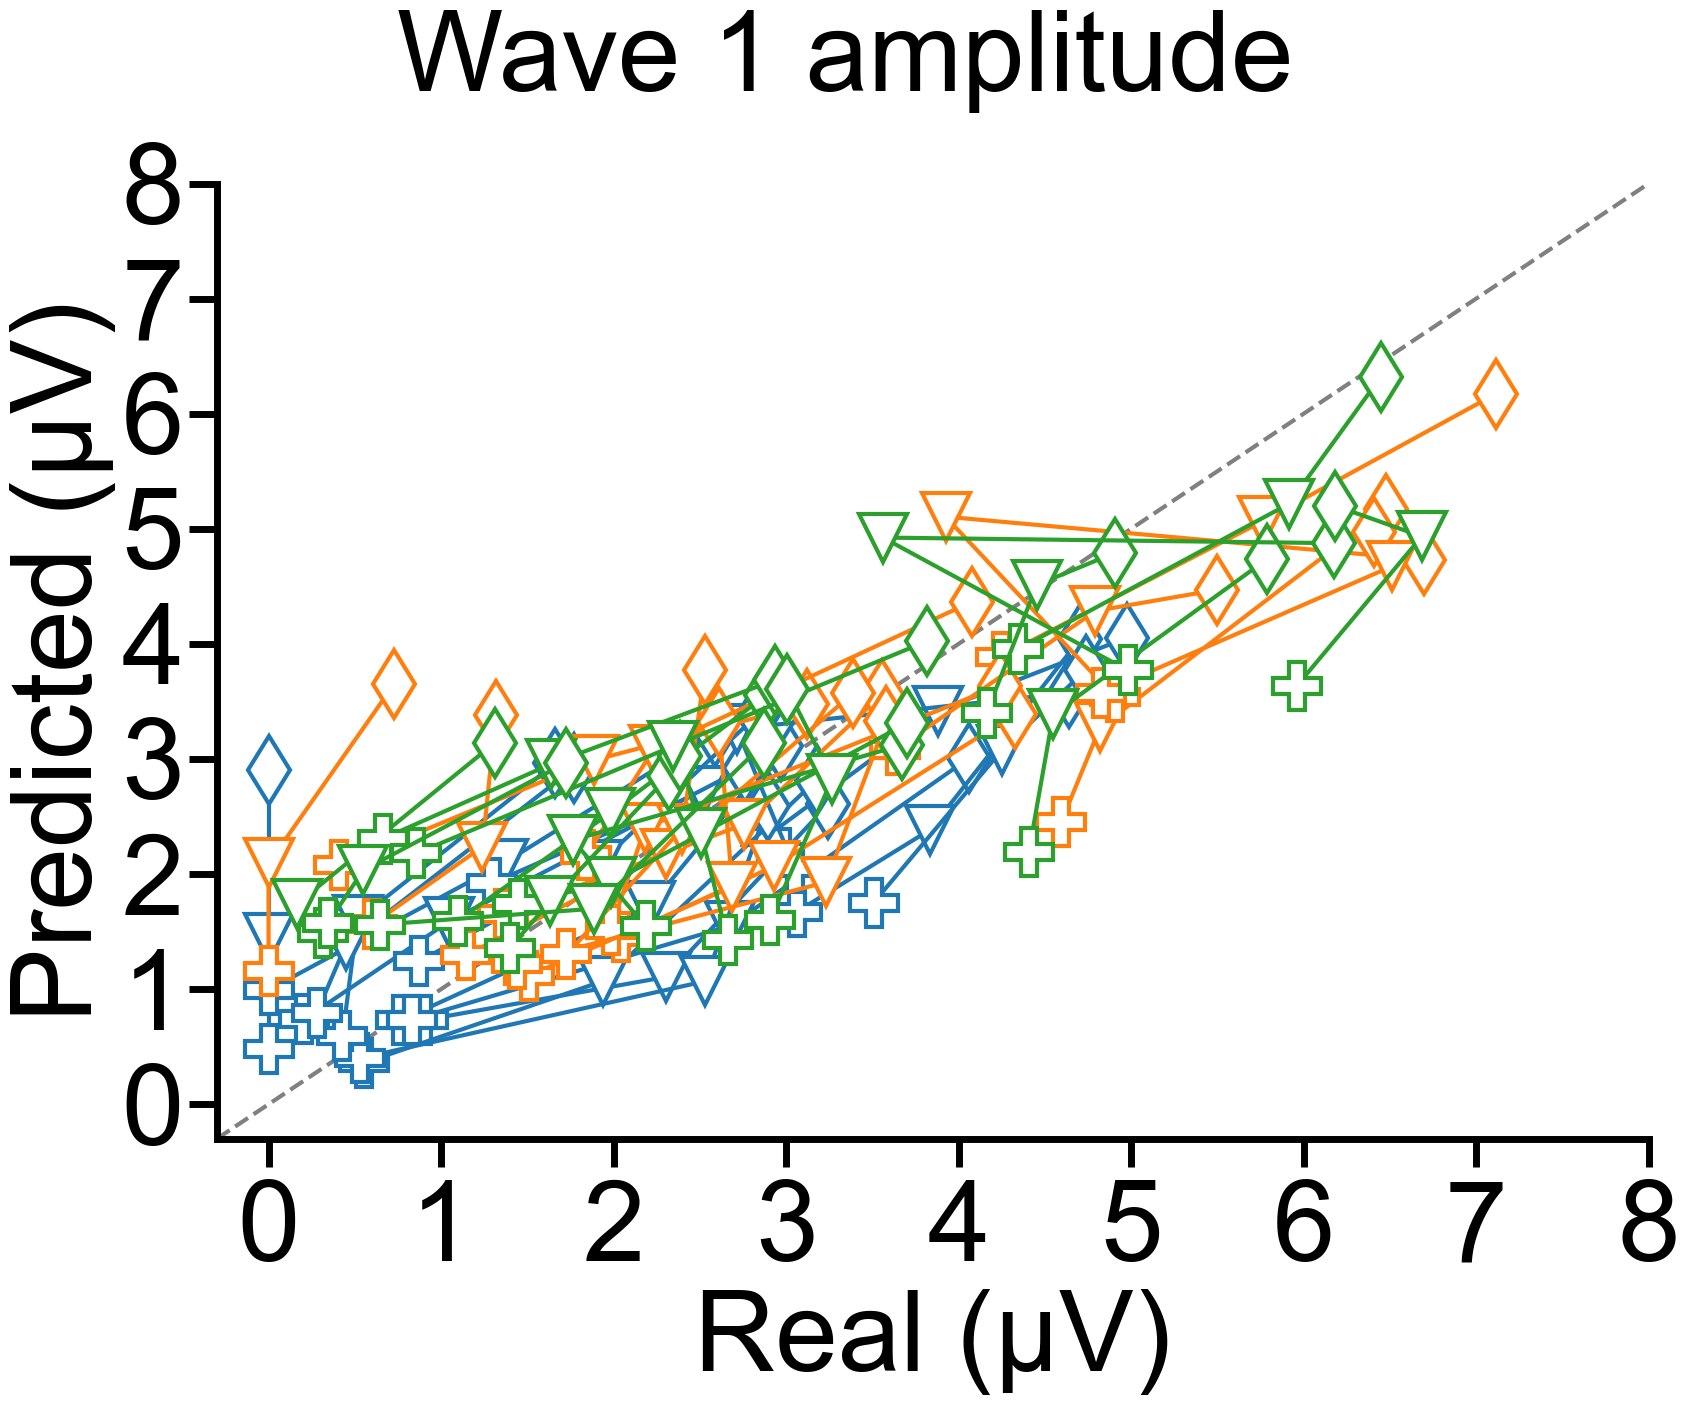

In [44]:
for intens in ['55dB','75dB','95dB']:
    showy = False if intens!='55dB' else True
    showxlabel = False if intens!='75dB' else True
    f,ax = makeFigureTest(masterAmpTest2,mouseIds,targetAges,'(μV)',intensities=[intens],title=' ',ylim=(-0.3,8),colorcycle=colorcycle2,
                          colorEncodeIntensity=True,figsize=(8,14),showyax=showy,showxlabel = showxlabel)
    ax.set_xticks(arange(0,8.1,2))
    ax.set_yticks(arange(0,8.1,2))
    
    el = masterAmpTest2.query("SoundLevel==@intens")
    r2 = r2_score(el['y_test'],el['y_predict'])
    mae= mean_absolute_error(el['y_test'],el['y_predict'])
    ax.text(0,6.5,f'MAE {mae:.1f}μV\nR$^2$ {r2:.2f}',fontsize=fontSize*0.8)


    f.savefig(f'./Panels/ampVsAgeTest{intens}.pdf',dpi=1200,transparent=True)
makeFigureTest(masterAmpTest.query("InputAge==@ia"),mouseIds,targetAges,'(μV)',intensities=['55dB','75dB','95dB'],title='Wave 1 amplitude',ylim=(-0.3,8),colorcycle=colorcycle2,colorEncodeIntensity=True)

In [45]:
ia = "['1month', '3month']"
masterLatTest2 = masterLatTest.query("InputAge==@ia")

In [46]:
print("One summary for all the models combined")
from sklearn.metrics import r2_score, mean_absolute_error
print(f"R2: {r2_score(masterLatTest2['y_test'],masterLatTest2['y_predict'])}")
print(f"MAE: {mean_absolute_error(masterLatTest2['y_test'],masterLatTest2['y_predict'])}")

print("\nOne summary for one model at each intensity")
for intens in ['55dB','75dB','95dB']:

    el = masterLatTest2.query("SoundLevel==@intens")
    print(f'{intens}')
    print(f"R2: {r2_score(el['y_test'],el['y_predict'])}")
    print(f"MAE: {mean_absolute_error(el['y_test'],el['y_predict'])}")


print("\nOne summary for one model at each intensity and at each age")
for intens in ['55dB','75dB','95dB']:
    for age in targetAges:
        print(f'{age} - {intens}')
        el = masterLatTest2.query("TargetAge==@age & SoundLevel==@intens")
        print(f"R2: {r2_score(el['y_test'],el['y_predict'])}")
        print(f"MAE: {mean_absolute_error(el['y_test'],el['y_predict'])}")

One summary for all the models combined
R2: 0.7644168345710768
MAE: 0.07892397411072141

One summary for one model at each intensity
55dB
R2: 0.6854743866173882
MAE: 0.087740740740477
75dB
R2: 0.569010896064302
MAE: 0.0849985754982359
95dB
R2: 0.4546024294929425
MAE: 0.06403260609345134

One summary for one model at each intensity and at each age
6month - 55dB
R2: 0.5512287371083893
MAE: 0.06298290598290554
9month - 55dB
R2: 0.6247484199606834
MAE: 0.08636324786324805
12month - 55dB
R2: 0.6412465712064914
MAE: 0.11387606837527742
6month - 75dB
R2: 0.19780333257334037
MAE: 0.07273717948717956
9month - 75dB
R2: 0.5522194578103437
MAE: 0.08144871794871812
12month - 75dB
R2: 0.5775725065490512
MAE: 0.10080982905880999
6month - 95dB
R2: 0.05453917902428995
MAE: 0.035292735042735085
9month - 95dB
R2: 0.2780567154588658
MAE: 0.06934354477844634
12month - 95dB
R2: 0.3762655452181206
MAE: 0.08746153845917258


(<Figure size 1700x1400 with 1 Axes>,
 <Axes: xlabel='Real (ms)', ylabel='Predicted (ms)'>)

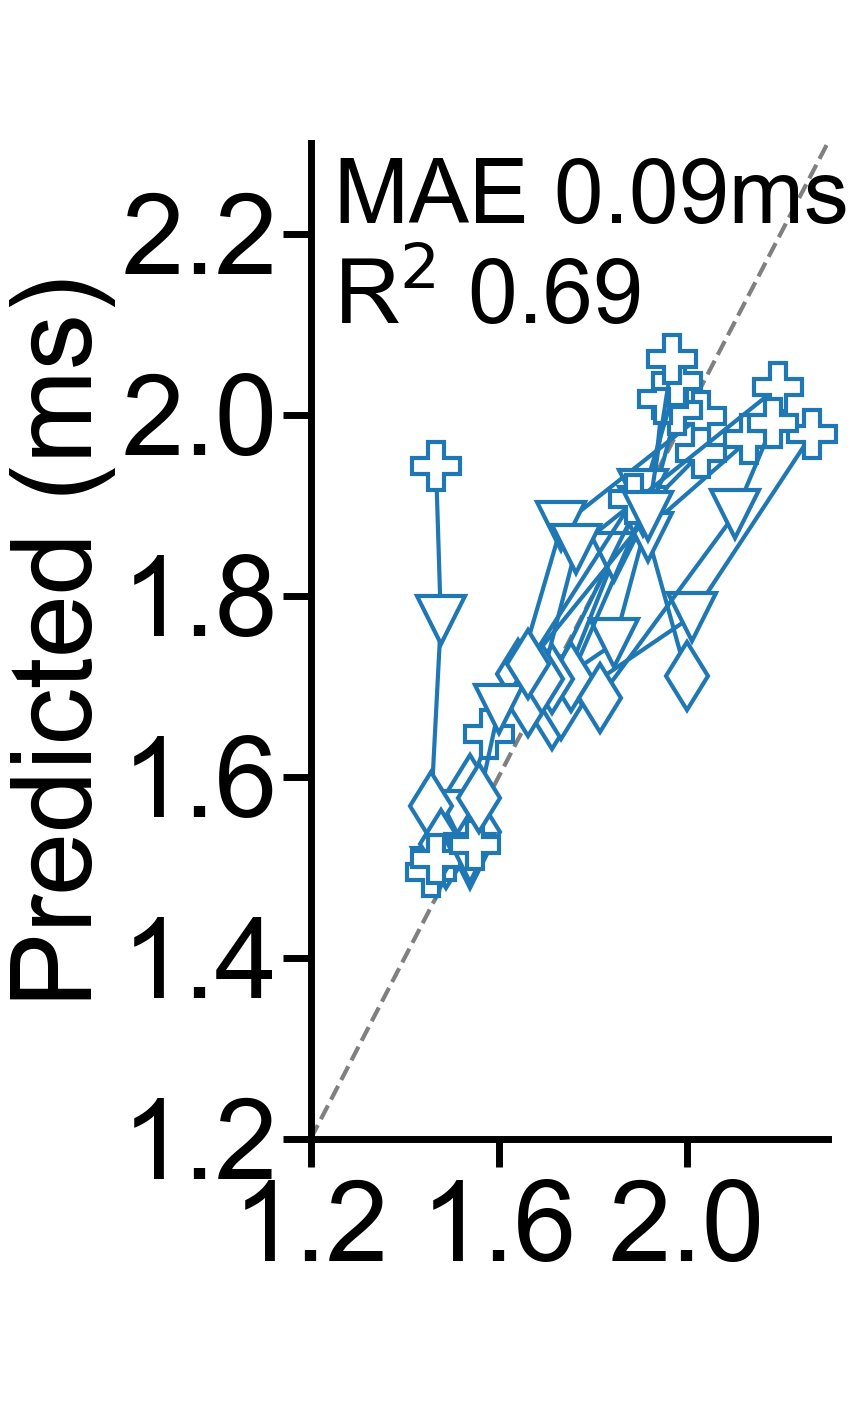

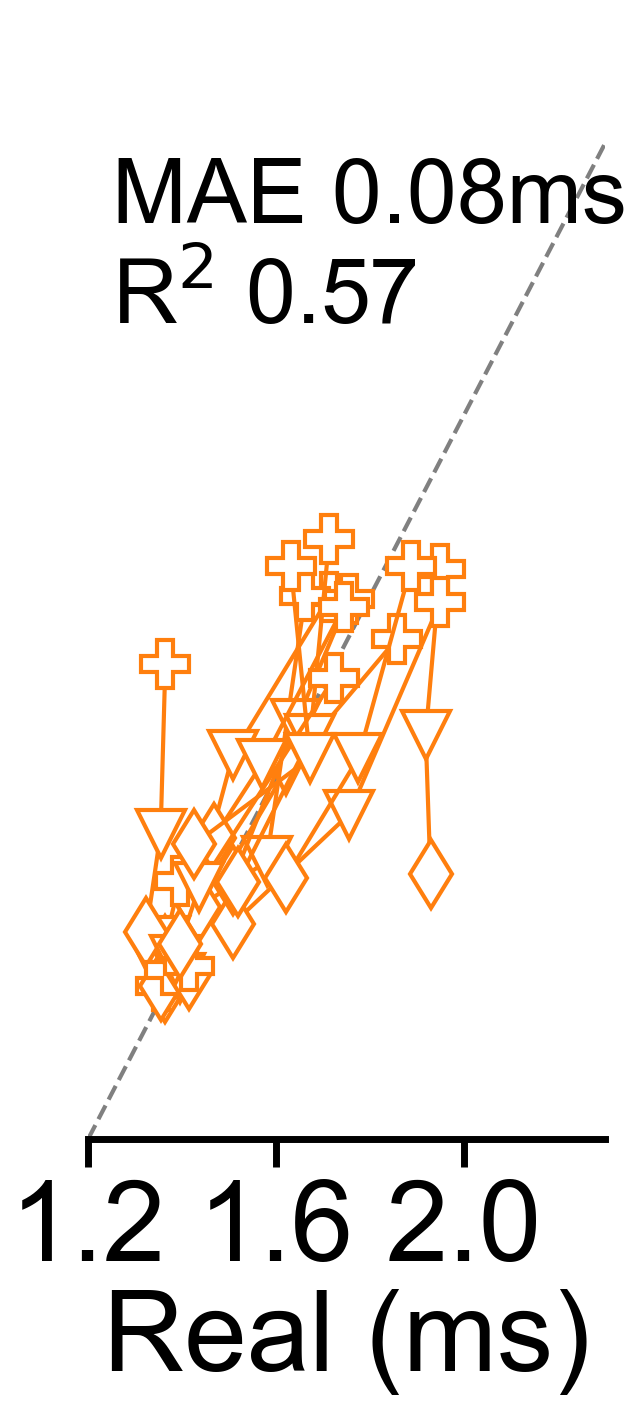

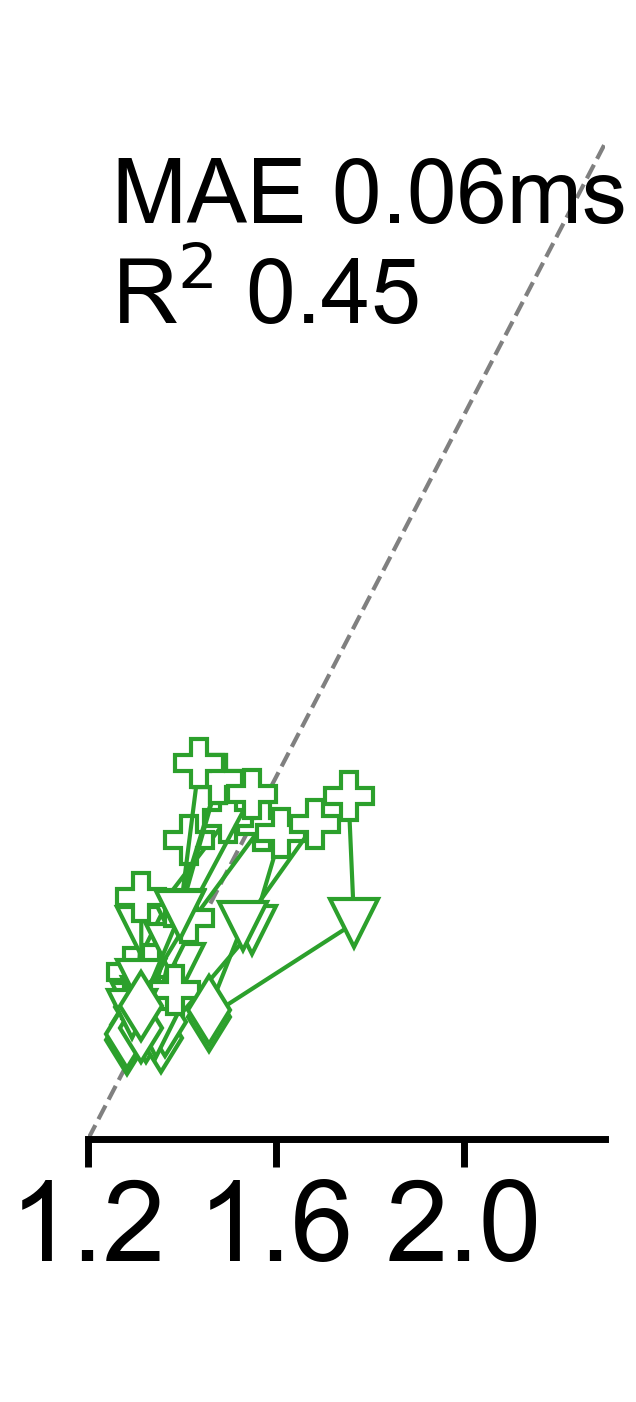

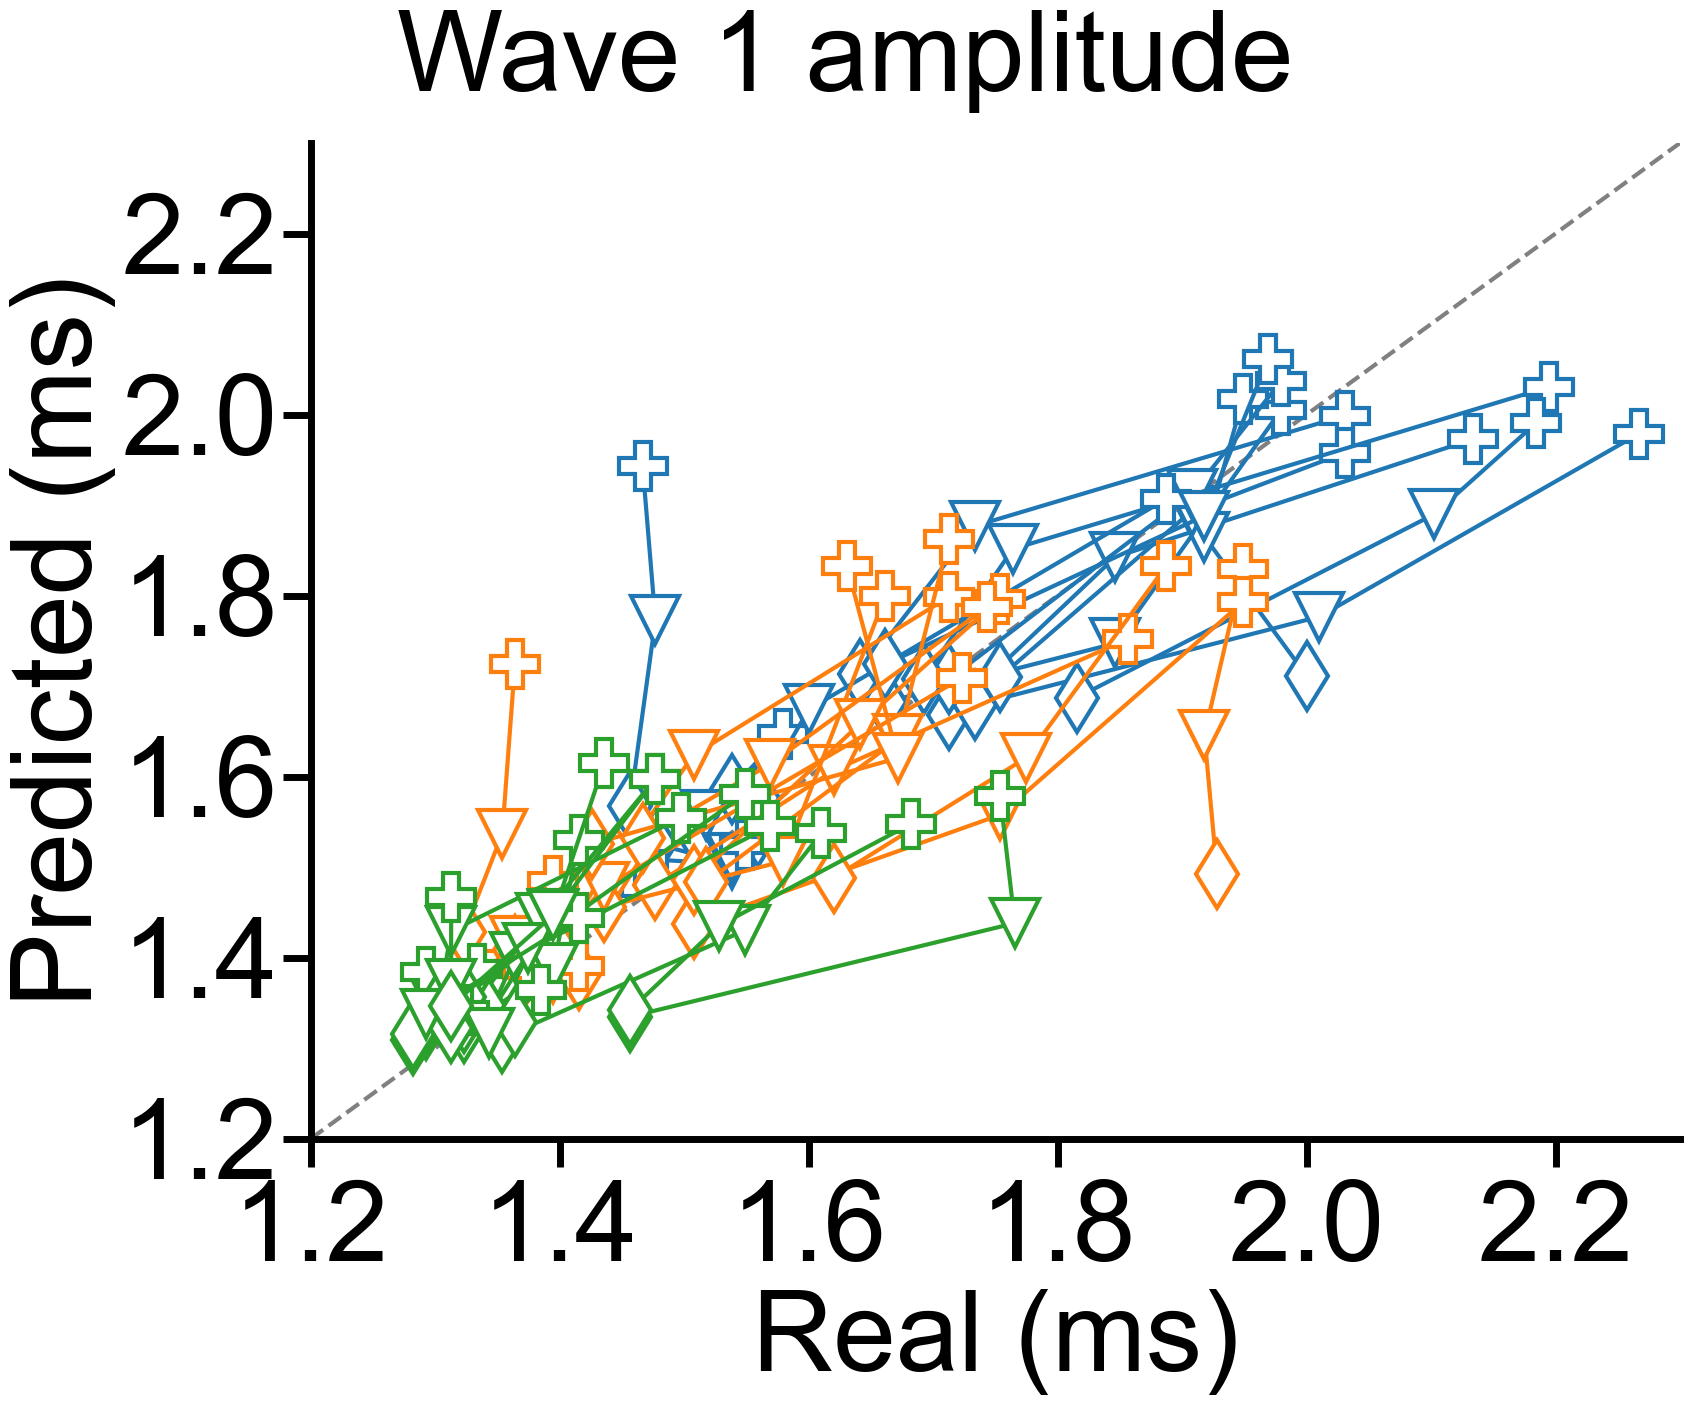

In [47]:


for intens in ['55dB','75dB','95dB']:
    showy = False if intens!='55dB' else True
    showxlabel = False if intens!='75dB' else True
    f,ax = makeFigureTest(masterLatTest2,mouseIds,targetAges,'(ms)',intensities=[intens],title=' ',ylim=(1.2,2.3),colorcycle=colorcycle2,
                          colorEncodeIntensity=True,figsize=(8.65,14),showyax=showy,showxlabel = showxlabel)
    ax.set_xticks(arange(1.2,2.3,0.4))
    
    el = masterLatTest2.query("SoundLevel==@intens")
    r2 = r2_score(el['y_test'],el['y_predict'])
    mae= mean_absolute_error(el['y_test'],el['y_predict'])
    ax.text(1.25,2.1,f'MAE {mae:.2f}ms\nR$^2$ {r2:.2f}',fontsize=fontSize*0.8,clip_on=False)

    f.savefig(f'./Panels/latVsAgeTest{intens}.pdf',dpi=1200,transparent=True)


makeFigureTest(masterLatTest.query("InputAge==@ia"),mouseIds,targetAges,'(ms)',intensities=['55dB','75dB','95dB'],ylim=(1.2,2.3),title='Wave 1 amplitude',colorcycle=colorcycle2,colorEncodeIntensity=True)

In [48]:
masterLatTest2.query("TargetAge=='9month' & SoundLevel=='75dB'")

y_test  y_predict Mouse ID    Strain InputFreq TargetAge  \
64  1.620513   1.607043   333773        6N     [100]    9month   
65  1.353846   1.380821   327636  Repaired     [100]    9month   
66  1.507692   1.624000   335027        6N     [100]    9month   
67  1.579487   1.506564   331176        6N     [100]    9month   
68  1.917949   1.646154   332774        6N     [100]    9month   
69  1.753846   1.557846   334603        6N     [100]    9month   
70  1.364103   1.418051   327620  Repaired     [100]    9month   
71  1.641026   1.658154   333774        6N     [100]    9month   
72  1.671795   1.641709   333799        6N     [100]    9month   
73  1.569231   1.614051   330578        6N     [100]    9month   
74  1.353846   1.536684   326822  Repaired     [100]    9month   
75  1.394872   1.377846   326824  Repaired     [100]    9month   
76  1.384615   1.397778   327619  Repaired     [100]    9month   
77  1.435897   1.477607   332783        6N     [100]    9month   
78  1.774359   1.620547   333783        6N     [100]    9month   
79  1.671795   1.620615   333771        6N     [100]    9month   

                InputAge              ModelName SoundLevel  
64  ['1month', '3month']  RandomForestRegressor       75dB  
65  ['1month', '3month']  RandomForestRegressor       75dB  
66  ['1month', '3month']  RandomForestRegressor       75dB  
67  ['1month', '3month']  RandomForestRegressor       75dB  
68  ['1month', '3month']  RandomForestRegressor       75dB  
69  ['1month', '3month']  RandomForestRegressor       75dB  
70  ['1month', '3month']  RandomForestRegressor       75dB  
71  ['1month', '3month']  RandomForestRegressor       75dB  
72  ['1month', '3month']  RandomForestRegressor       75dB  
73  ['1month', '3month']  RandomForestRegressor       75dB  
74  ['1month', '3month']  RandomForestRegressor       75dB  
75  ['1month', '3month']  RandomForestRegressor       75dB  
76  ['1month', '3month']  RandomForestRegressor       75dB  
77  ['1month', '3month']  RandomForestRegressor       75dB  
78  ['1month', '3month']  RandomForestRegressor       75dB  
79  ['1month', '3month']  RandomForestRegressor       75dB

In [49]:
# Create custom legends

/var/folders/n2/bkzw0ff907zgpgprdz_rg_tr0000gn/T/ipykernel_56420/2911792169.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  tight_layout()


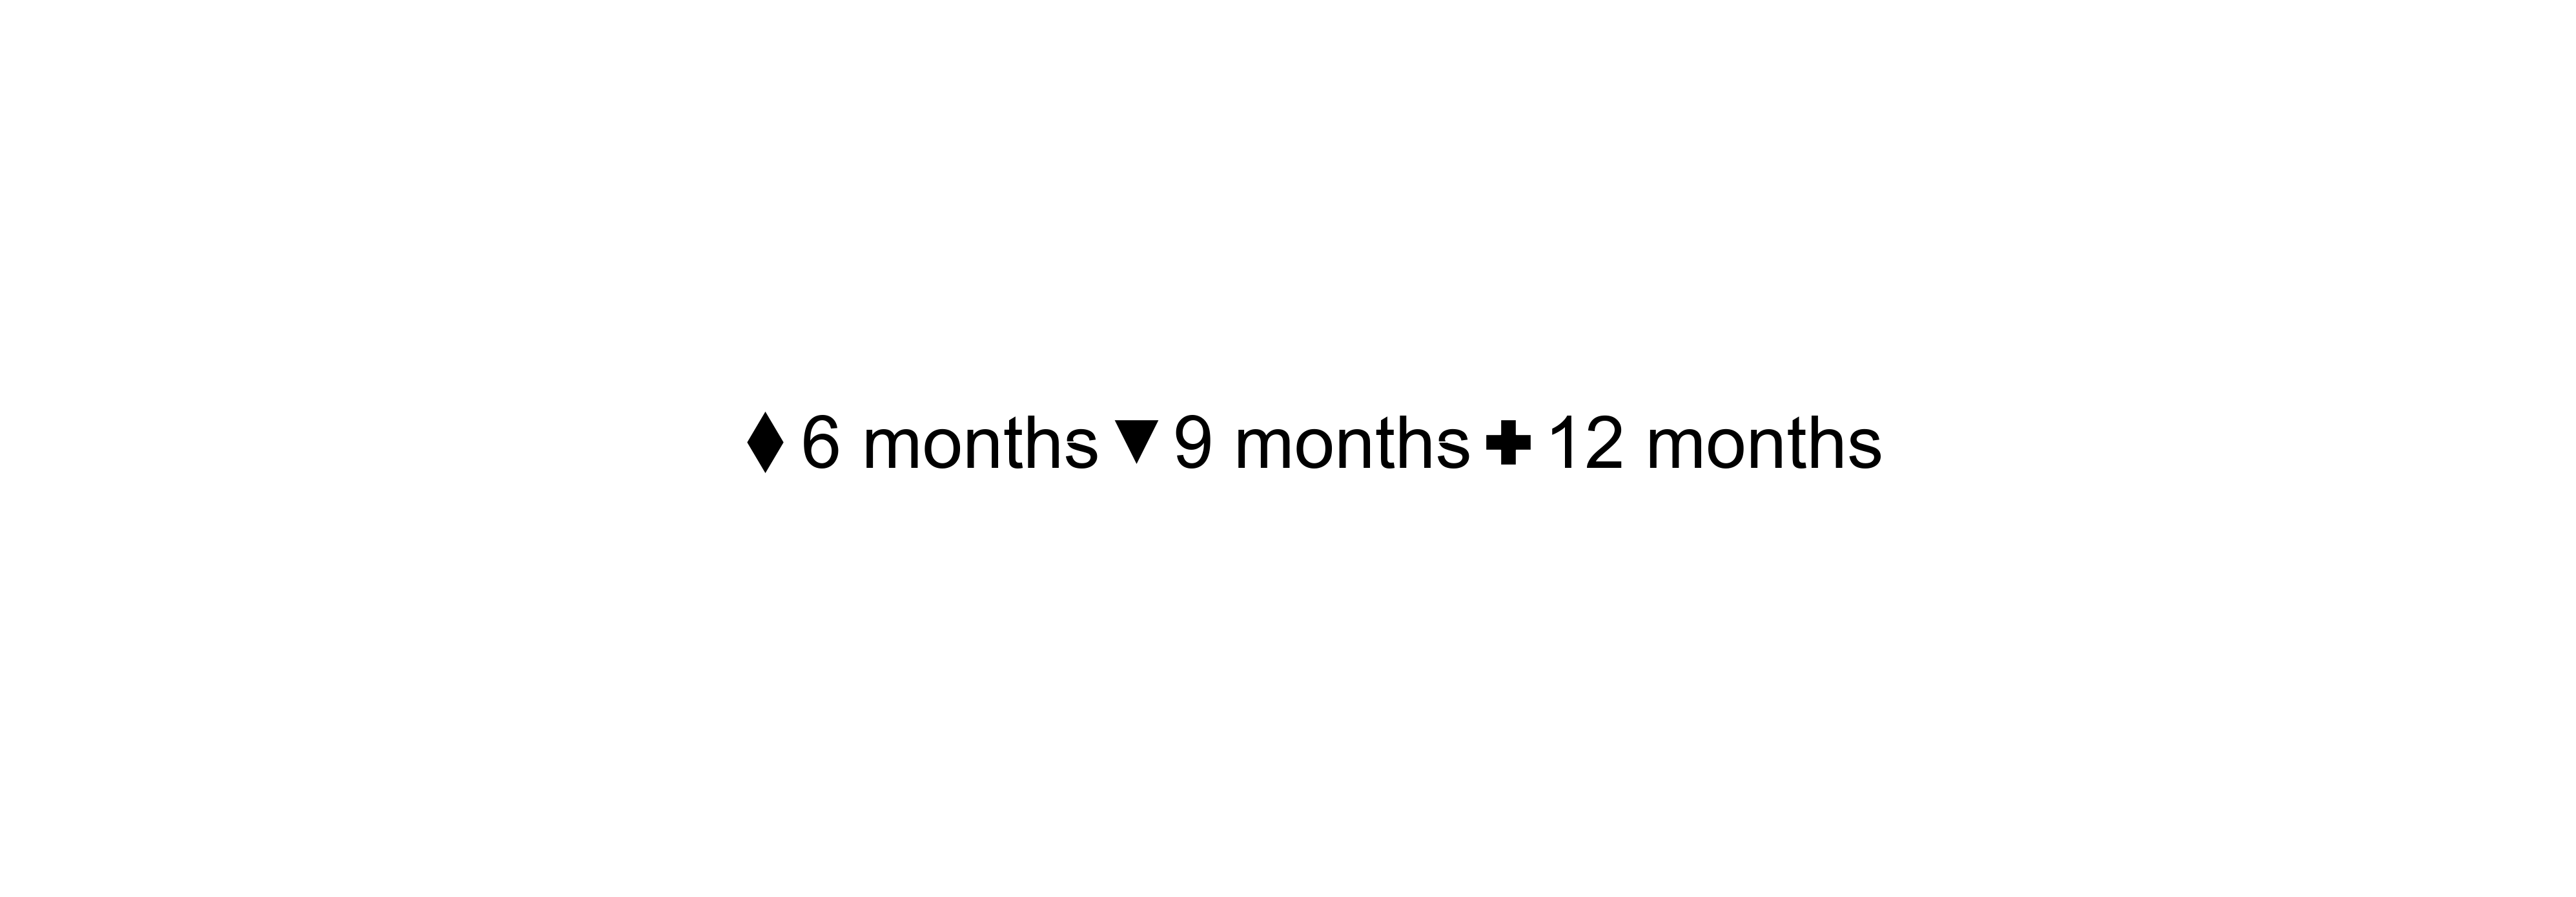

In [50]:

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
legend_elements = [
                   Line2D([0], [0], marker='d', color='w', label='6 months',
                          markerfacecolor='k', markersize=markersize),
                     Line2D([0], [0], marker='v', color='w', label='9 months',
                            markerfacecolor='k', markersize=markersize),
                     Line2D([0], [0], marker='P', color='w', label='12 months',
                            markerfacecolor='k', markersize=markersize),
                   ]

# Create the figure
f= figure(figsize=(40,14))
gs= gridspec.GridSpec(1, 1,figure=f)

ax = plt.subplot(gs[0])
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)

ax.legend(handles=legend_elements, fontsize=fontSize,loc='center',ncol=3,frameon=False,
          mode=None,columnspacing=-.5,handletextpad = -0.5)
gs.tight_layout(f) 
tight_layout()
savefig('./Panels/Figure8Lenged.pdf',transparent=True,dpi=1200)

In [51]:
import abrTools as at 
X_train,  X_test,y_train,y_test,mouseIDtrain,mouseIDtest,mouseStrainTrain,mouseStrainTest,dataVersion = at.createFutureThresholdDataset(datafolder ='../../data',test_size=0.25,inputFreqs=[100],inputs = ['1month','3month'] ,
                                                                                                                                        strains = ['6N','Repaired'],target = '6month',mode = 'waveamp',
                                                                                                                                        targetFrequency=[100],targetIntensity=[55])#,frequencies=[100,])
  

The dataset version is: 20230914 - V41


/Users/federico/Desktop/ABR-ML 2/ABR-ML-analysis/notebooks/Paper/../../src/abrTools.py:1077: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  masterAll = pd.concat(rows,ignore_index=True)
/Users/federico/Desktop/ABR-ML 2/ABR-ML-analysis/notebooks/Paper/../../src/abrTools.py:1103: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  masterAll = pd.concat([masterAll,rowsToAddDf],ignore_index=True)
/Users/federico/Desktop/ABR-ML 2/ABR-ML-analysis/notebooks/Paper/../../src/abrTools.py:1103: FutureWarning: The

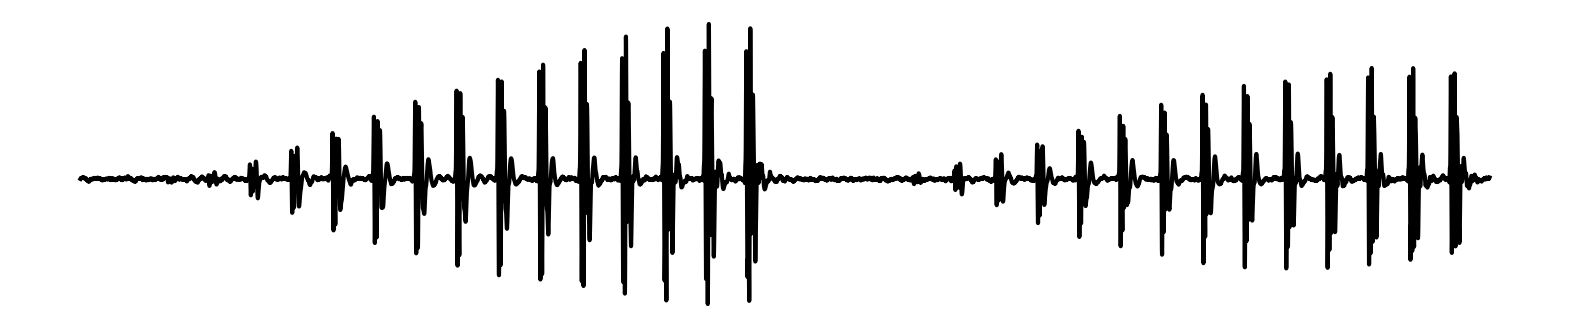

In [52]:
f= figure(figsize=(20,4))

plot(X_train.mean(0),'k',linewidth=3)
ax = gca()
# ax.text(20000,5,'1 month click ABR',ha='center',fontsize=fontSize)
# ax.text(56000,5,'3 months click ABR',ha='center',fontsize=fontSize)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)
f.savefig('./Panels/regressiontrace.pdf',dpi=1200,transparent=True)